In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [3]:
data = pd.read_csv('/content/final_data.csv')

In [4]:
data.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      298038       5715510        Closed      currency 1         -586   
1      221655       5715839        Closed      currency 1        -2365   
2      386362       5717347        Closed      currency 1         -806   
3      281442       5724781        Closed      currency 1        -1491   
4      455046       5725054        Closed      currency 1         -389   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -339.0             -553.0   
1                   0              -2061.0            -2061.0   
2                   0               -502.0             -502.0   
3                   0              -1310.0            -1310.0   
4                   0                -86.0             -115.0   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  ...  FLAG_DOCUMENT_18  \
0                    0.00                   0  ...                 0   
1                    0.00                   0  ...                 0   
2                10039.05                   0  ...                 0   
3                    0.00                   0  ...                 0   
4                    0.00                   0  ...                 0   

   FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
0                 0                 0                 0   
1                 0                 0                 0   
2                 0                 0                 0   
3                 0                 0                 0   
4                 0                 0                 0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        4.0   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                       0.0   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         4.0                       0.0   
4                         0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         4.0  
1                        1.0                         5.0  
2                        0.0                         1.0  
3                        1.0                         2.0  
4                        0.0                         2.0  

[5 rows x 175 columns]

# Data Pre-Processing

In [ ]:
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

In [5]:
irrelevant_columns = [
     'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
    'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
    'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'NFLAG_LAST_APPL_IN_DAY',
    'PRODUCT_COMBINATION', 'NAME_CONTRACT_TYPE_x', 'NAME_CONTRACT_TYPE_y',
    'WEEKDAY_APPR_PROCESS_START_x', 'WEEKDAY_APPR_PROCESS_START_y','CREDIT_DAY_OVERDUE','AMT_CREDIT_MAX_OVERDUE','SELLERPLACE_AREA', 'FLAG_OWN_CAR', 'DAYS_LAST_DUE_1ST_VERSION', 'NAME_PORTFOLIO',
     'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE','FLAG_MOBIL','YEARS_BEGINEXPLUATATION_AVG','CODE_REJECT_REASON', 'CNT_PAYMENT'
]

data = data.drop(columns=irrelevant_columns, errors='ignore')
print("Dataset Shape After Dropping Irrelevant Columns:", data.shape)

Dataset Shape After Dropping Irrelevant Columns: (7192, 137)


In [42]:
duplicates = data.duplicated()
print(f"Jumlah data duplikat: {duplicates.sum()}")

Jumlah data duplikat: 0


In [7]:
missing_values = data.isnull().mean() * 100
missing_values_sorted = missing_values.sort_values(ascending=False)


print("Missing Values (%) per Column:")
print(missing_values_sorted)

Missing Values (%) per Column:
COMMONAREA_AVG                69.187987
COMMONAREA_MEDI               69.187987
COMMONAREA_MODE               69.187987
NONLIVINGAPARTMENTS_AVG       68.784761
NONLIVINGAPARTMENTS_MODE      68.784761
                                ...    
DAYS_TERMINATION               0.000000
DAYS_LAST_DUE                  0.000000
DAYS_FIRST_DUE                 0.000000
DAYS_FIRST_DRAWING             0.000000
AMT_REQ_CREDIT_BUREAU_YEAR     0.000000
Length: 137, dtype: float64


In [8]:
cols_to_drop = missing_values_sorted[missing_values_sorted > 0.5].index
data_cleaned = data.drop(columns=cols_to_drop)

print(data_cleaned.shape)

(7192, 87)


In [9]:
for col in numerical_cols:
    if col in data.columns:
        data[col].fillna(data[col].median(), inplace=True)

<ipython-input-9-dabc1dfc55f8>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)


In [10]:
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'MONTHS_BALANCE_x', 'SK_ID_PREV', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_INST_MIN_REGULARITY', 'CNT_INSTALMENT_MATURE_CUM', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'AMT_INSTALMENT', 'AMT_APPLICATION', 'AMT_CREDIT_x', 'HOUR_APPR_PROCESS_START_x', 'DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_y', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOU

In [11]:
label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Feature Engineering

In [12]:
data['AGE'] = -data['DAYS_BIRTH'] // 365

In [13]:
data['EMPLOYMENT_DURATION'] = -data['DAYS_EMPLOYED'] // 365

In [14]:
data['AMT_INCOME_TOTAL_LOG'] = np.log1p(data['AMT_INCOME_TOTAL'])

In [15]:
y = data['TARGET']
X = data.drop(['TARGET', 'SK_ID_CURR'], axis=1, errors='ignore')

In [16]:
selector = SelectKBest(score_func=f_classif, k=20)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [10 26 28 34] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [17]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [18]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

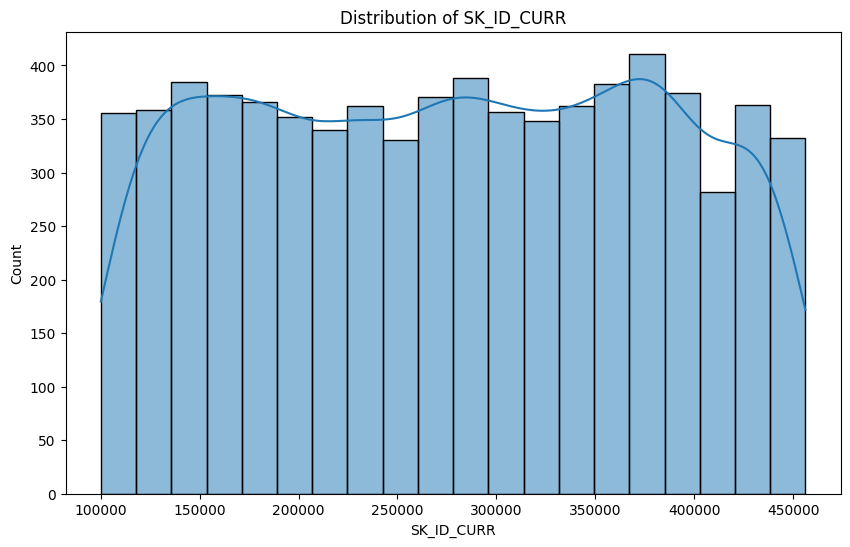

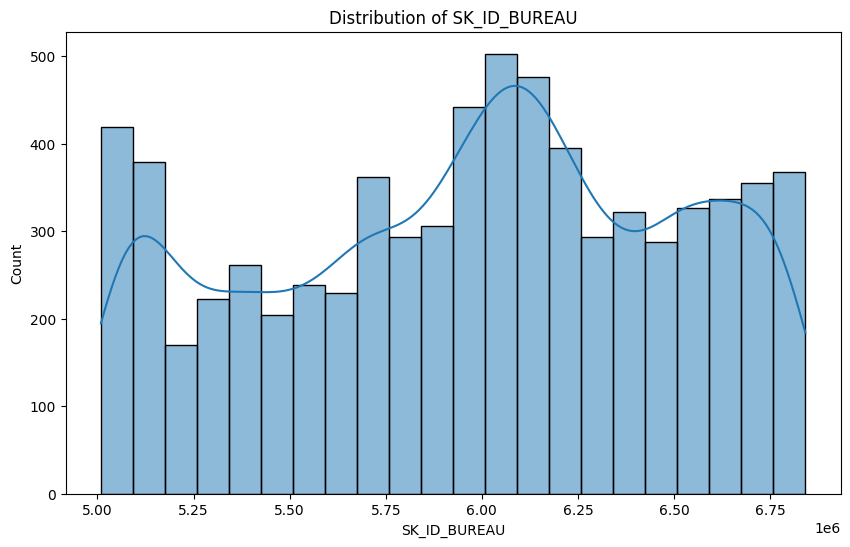

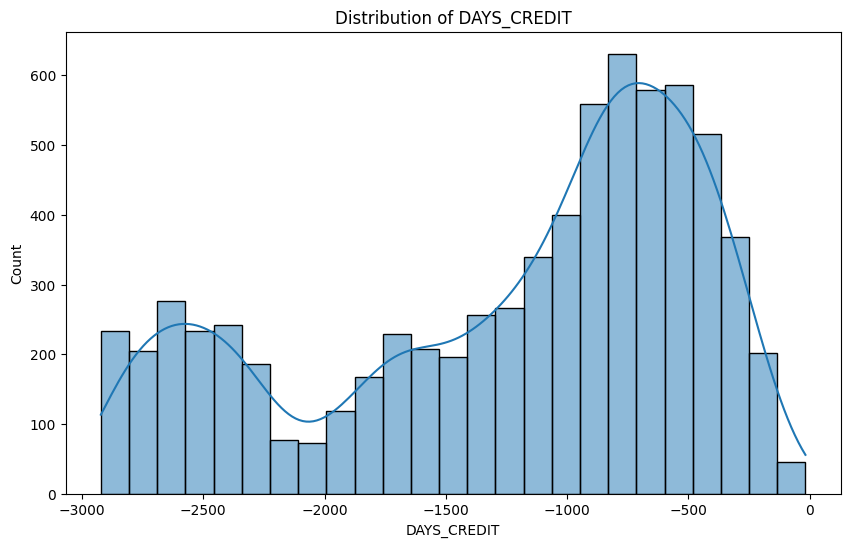

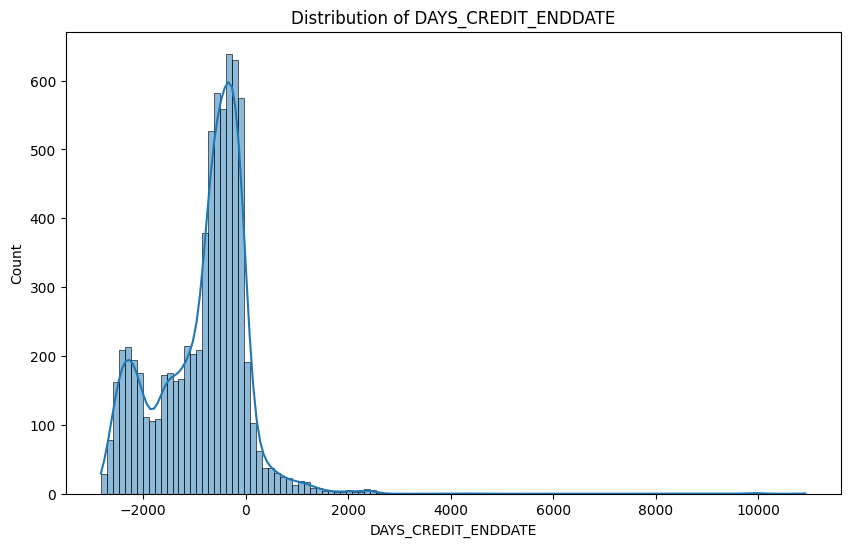

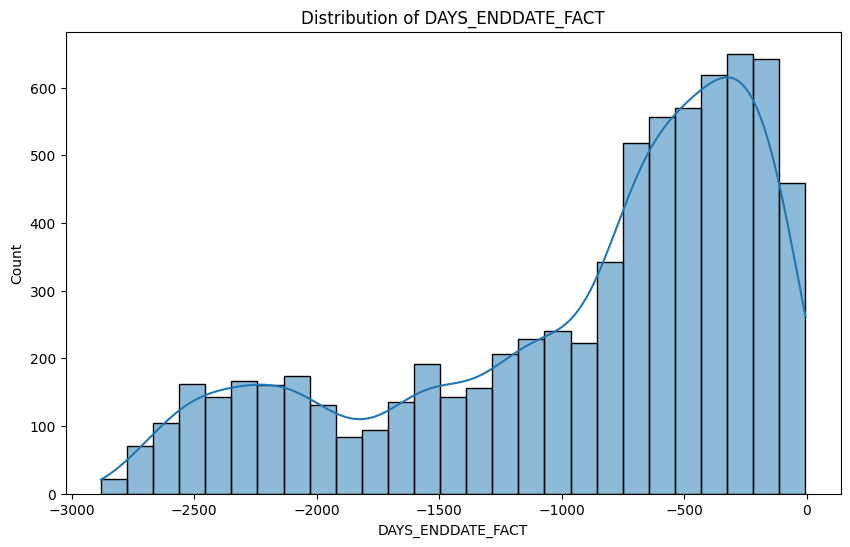

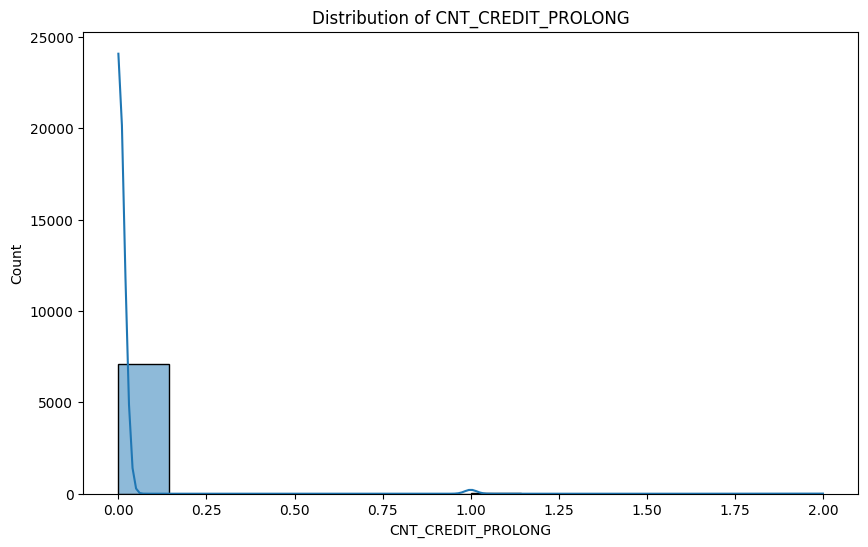

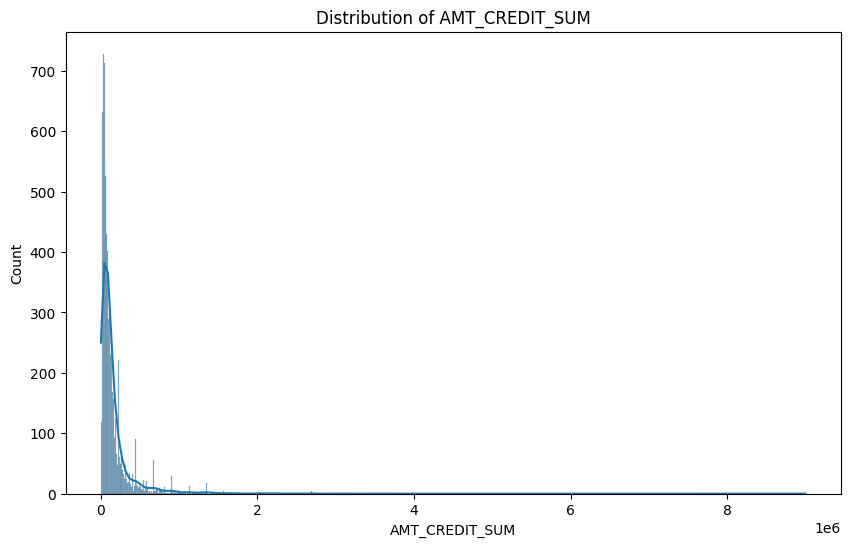

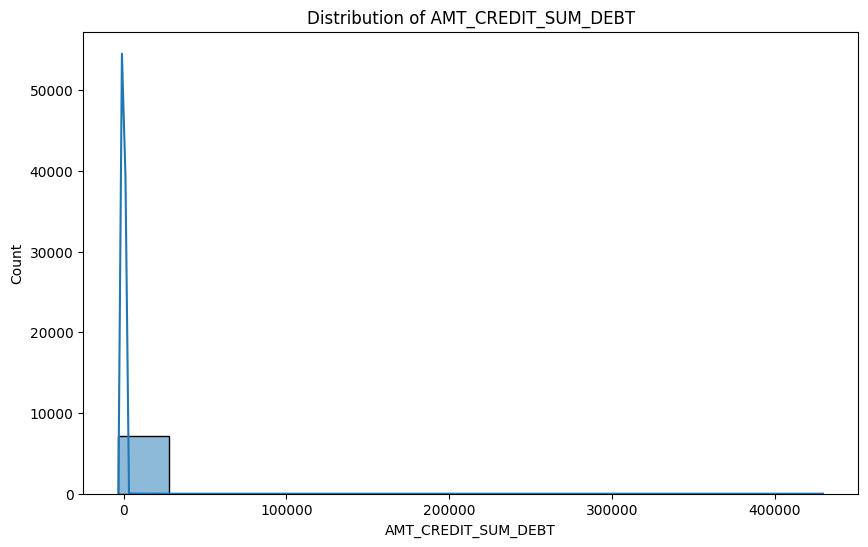

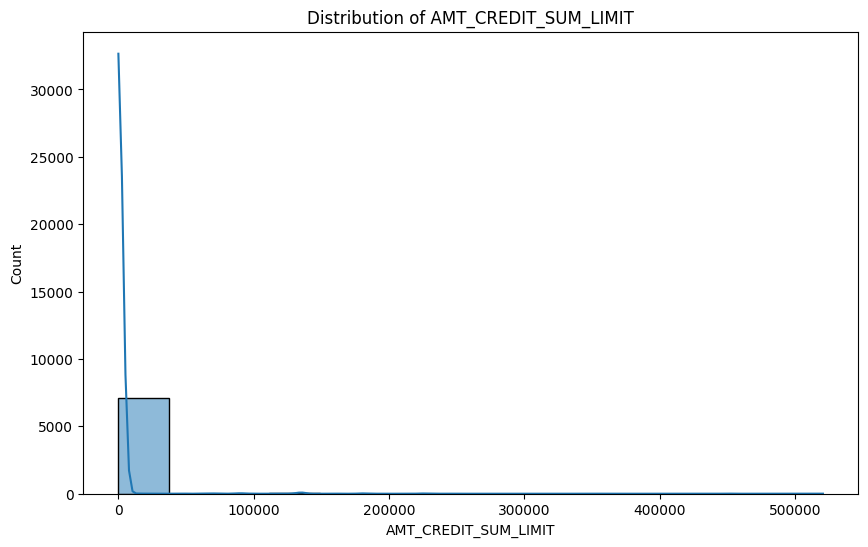

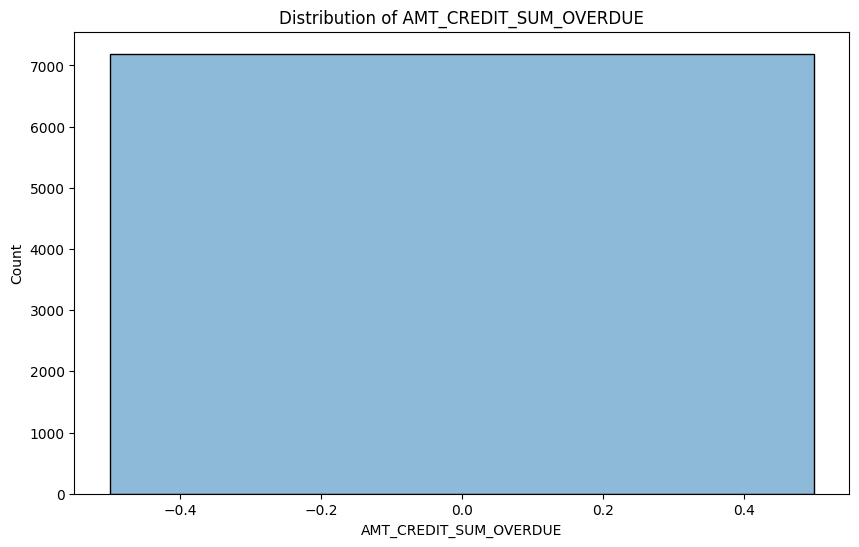

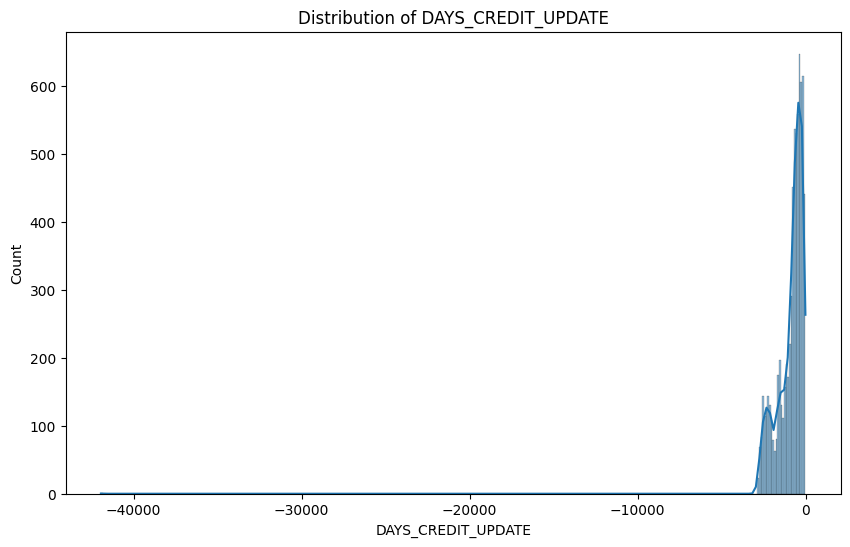

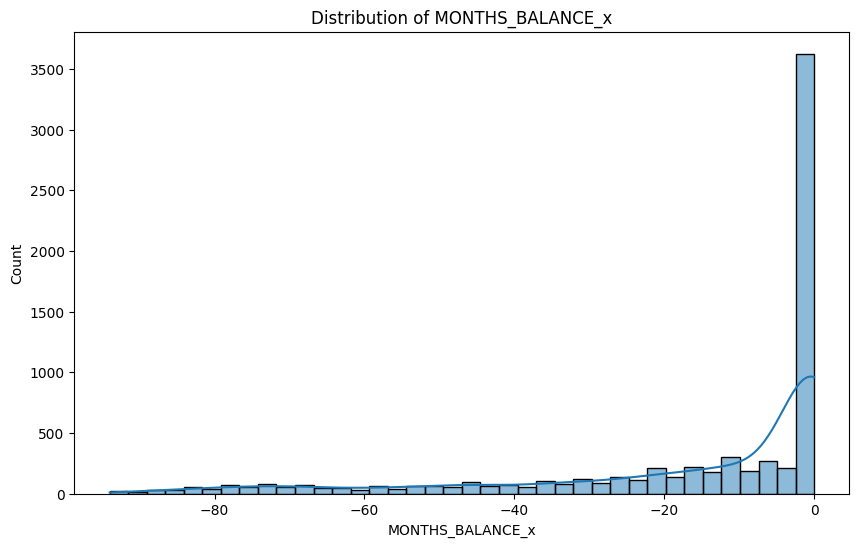

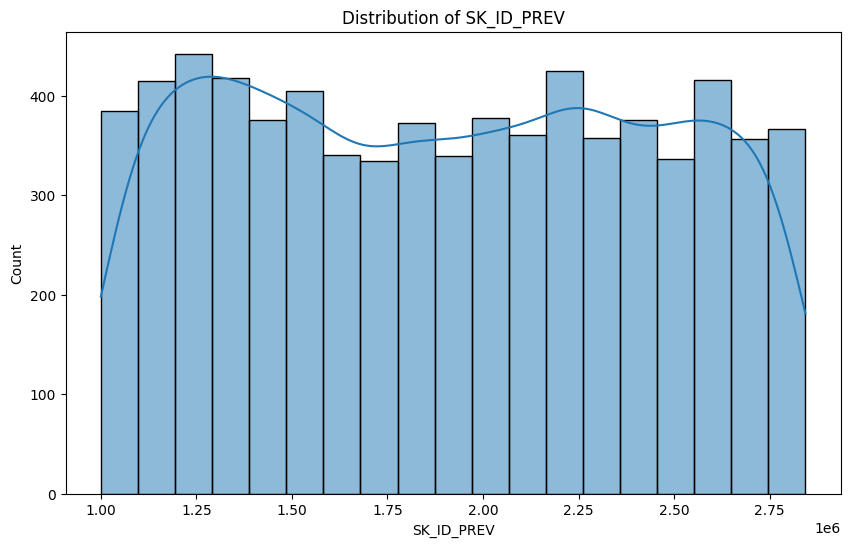

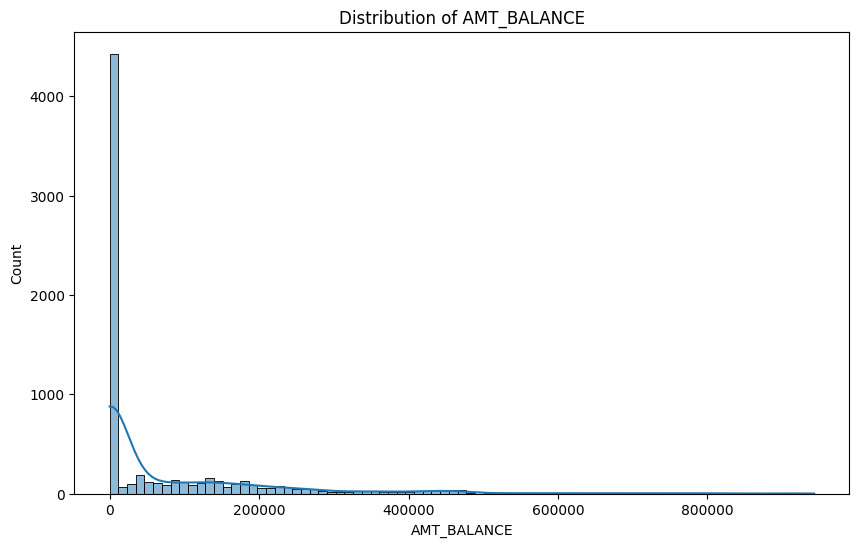

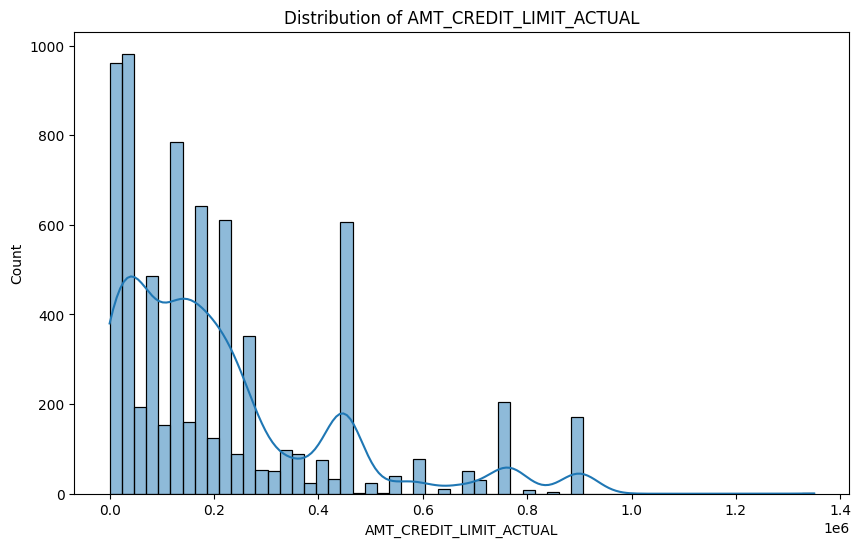

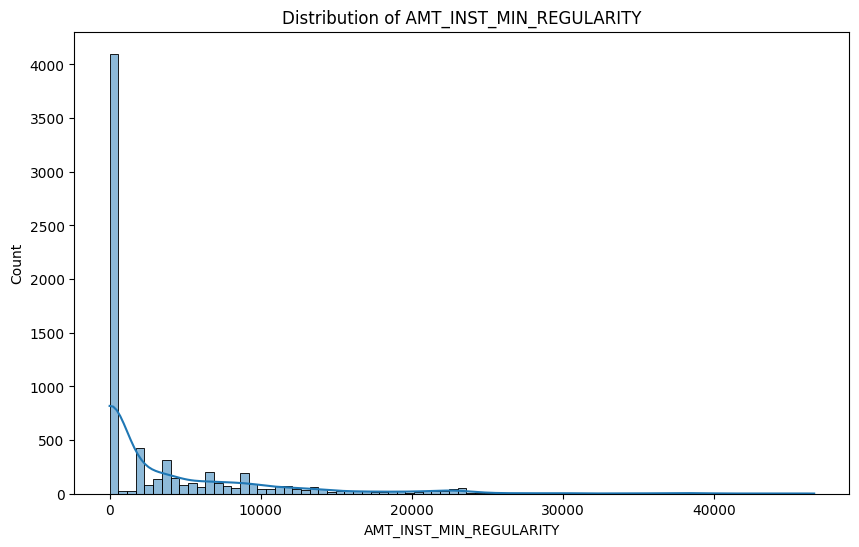

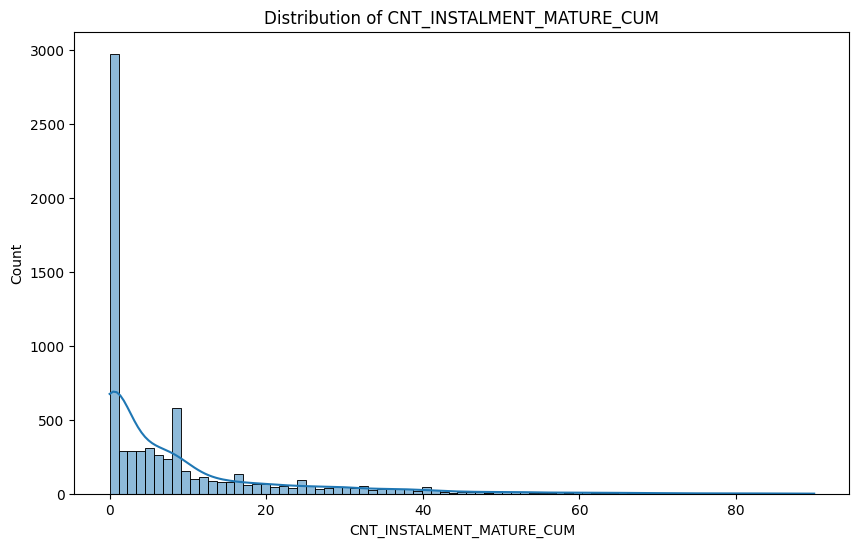

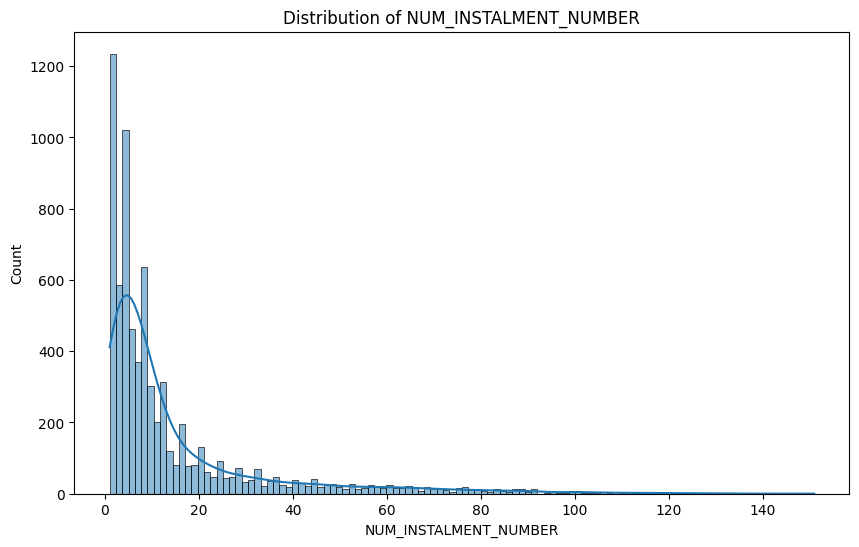

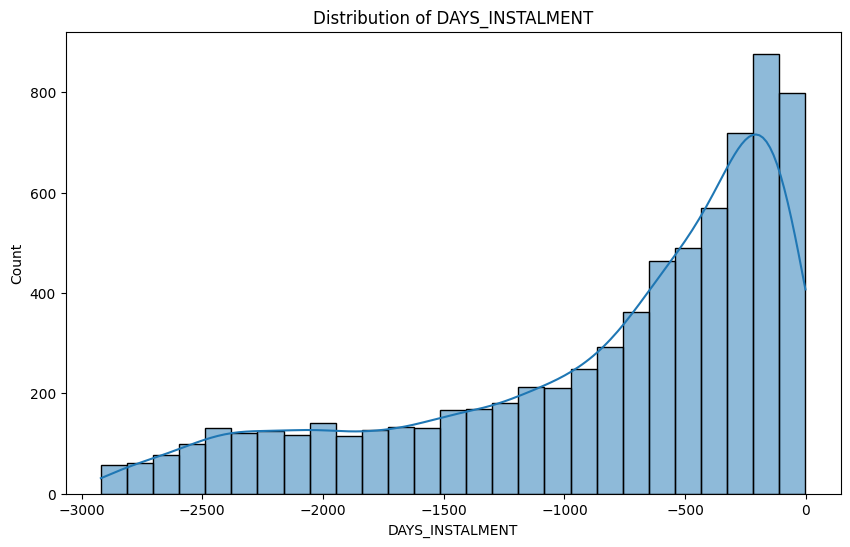

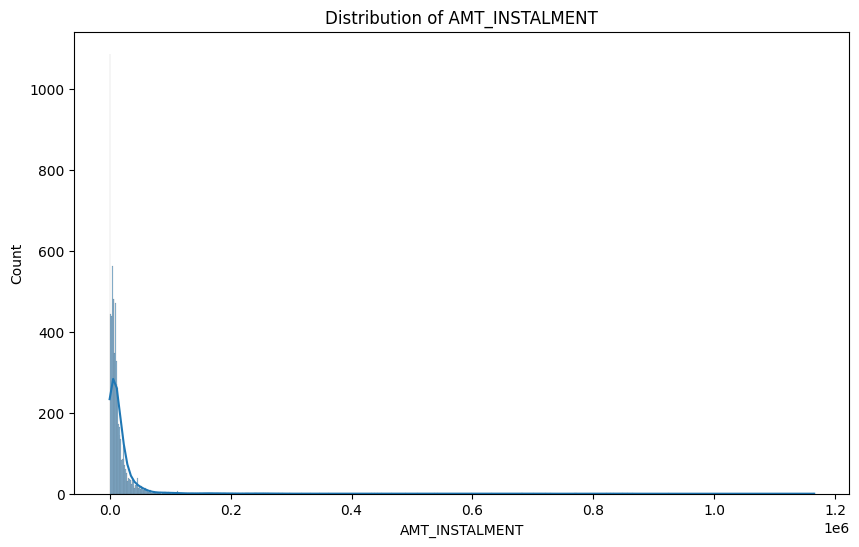

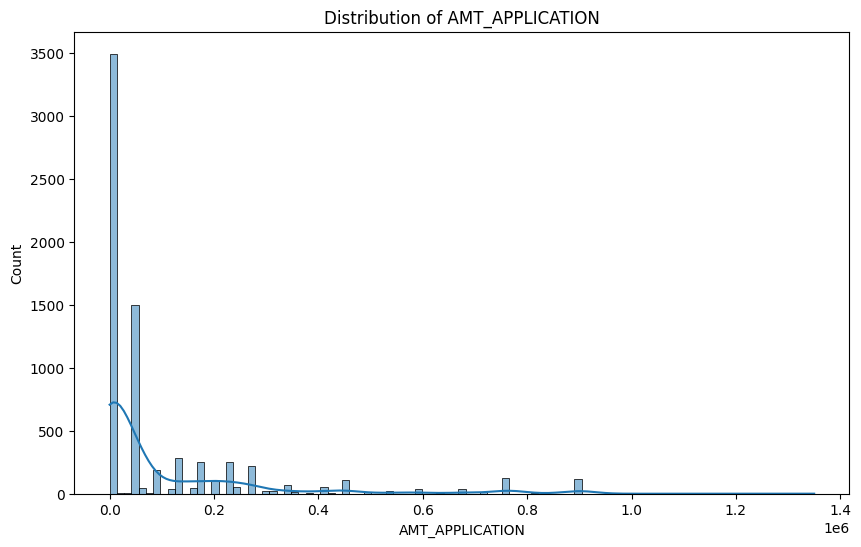

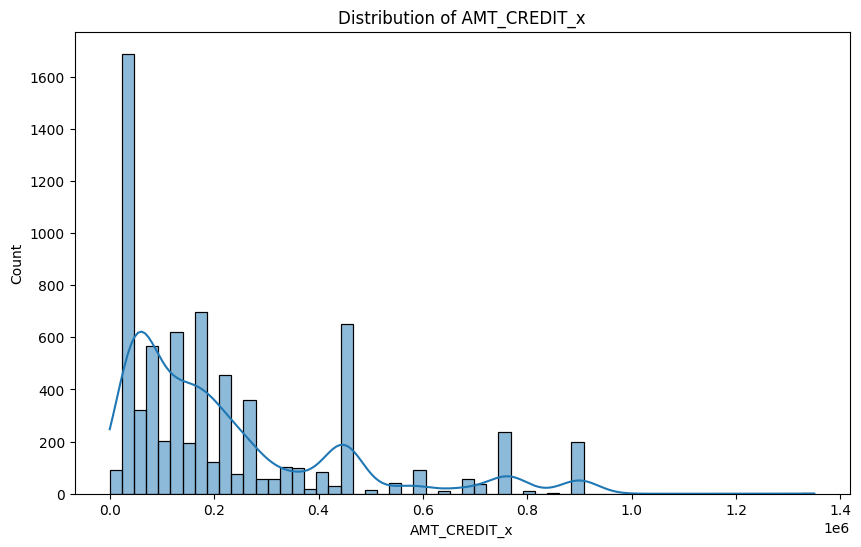

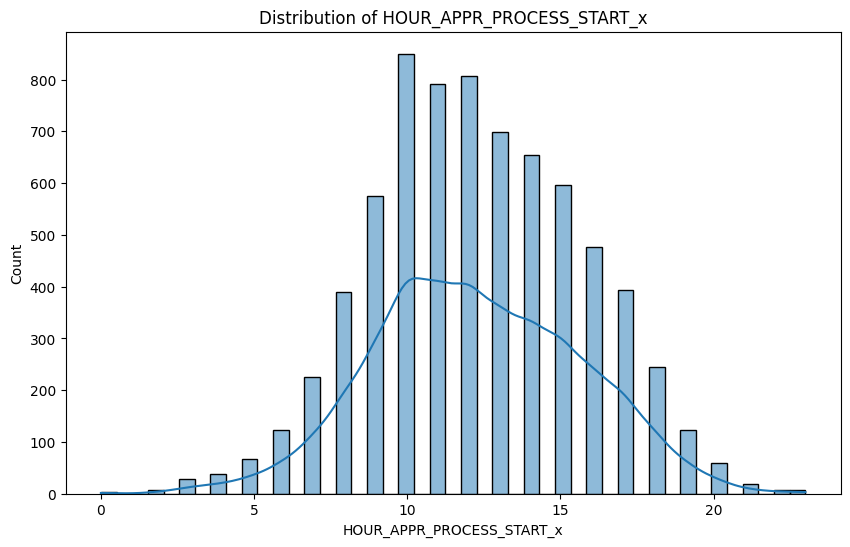

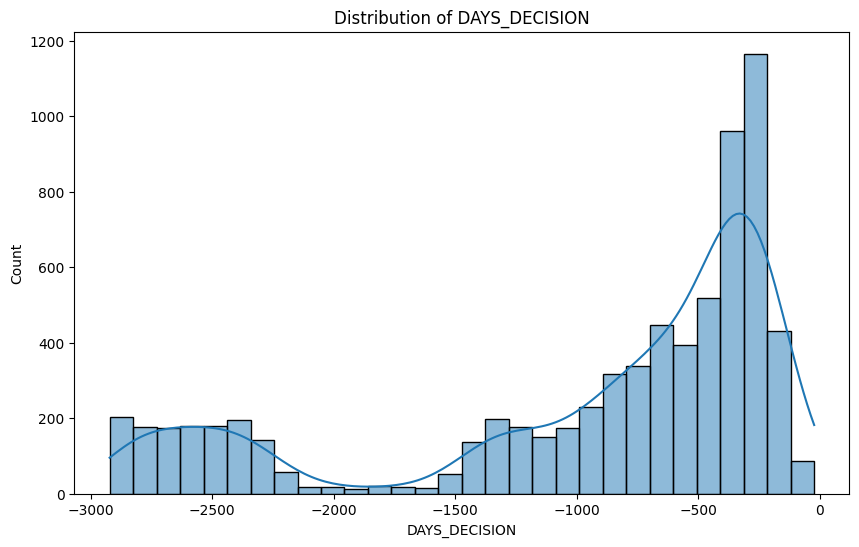

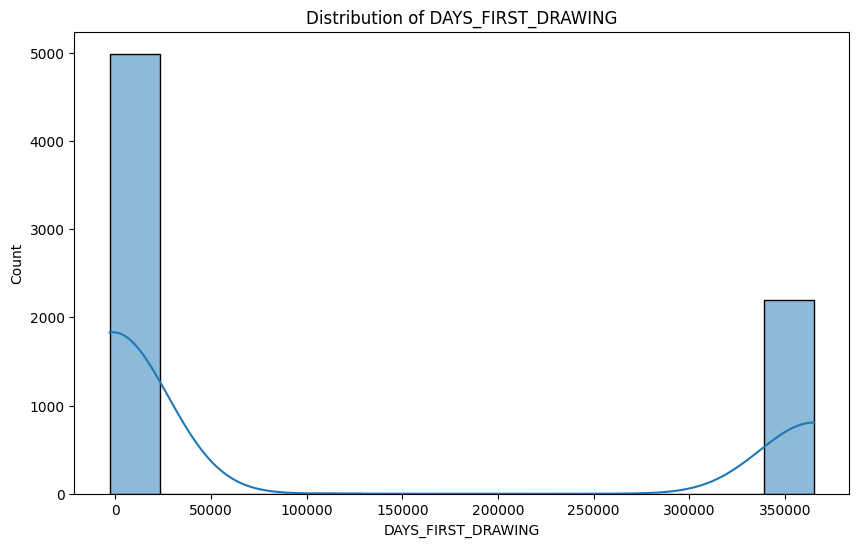

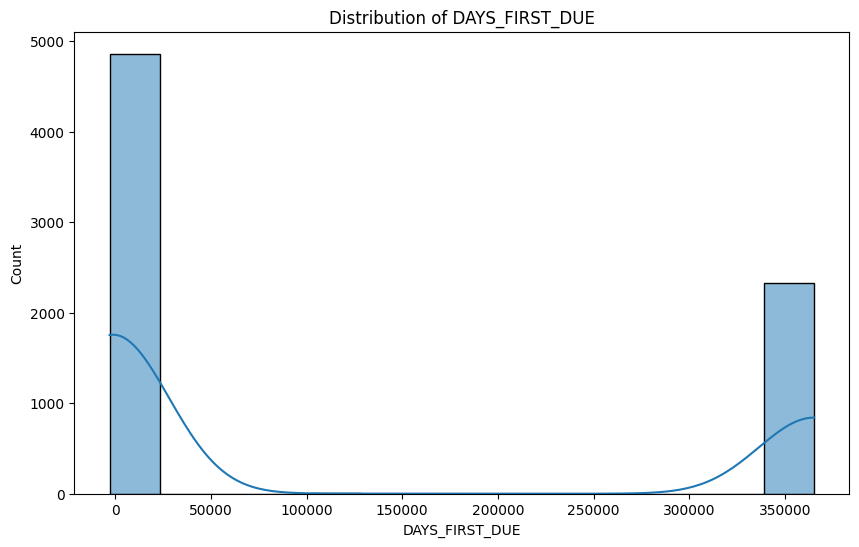

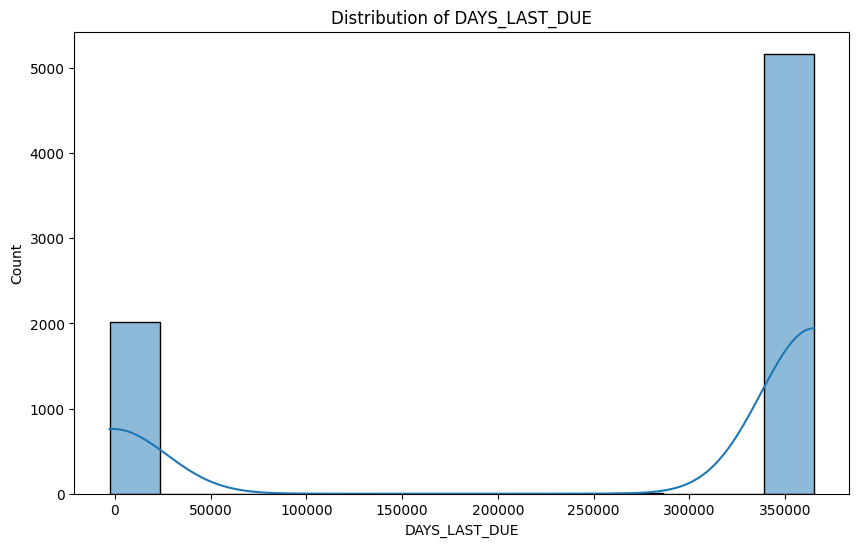

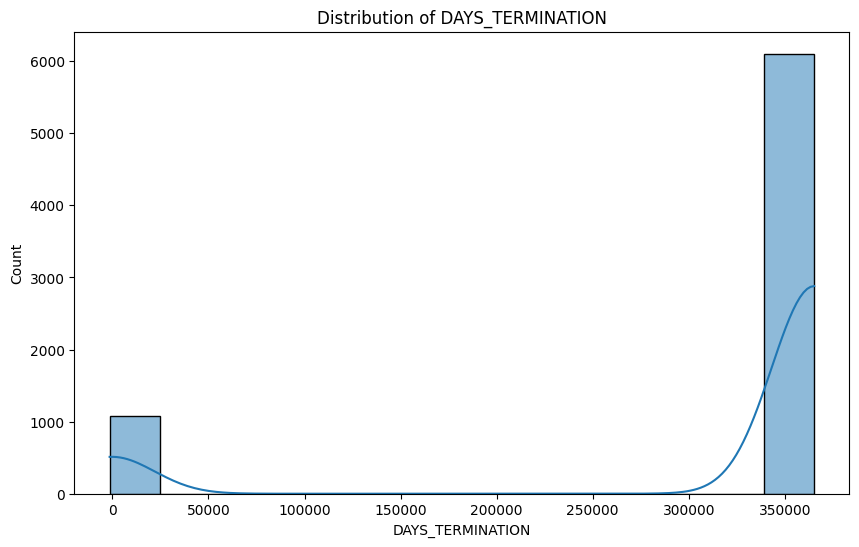

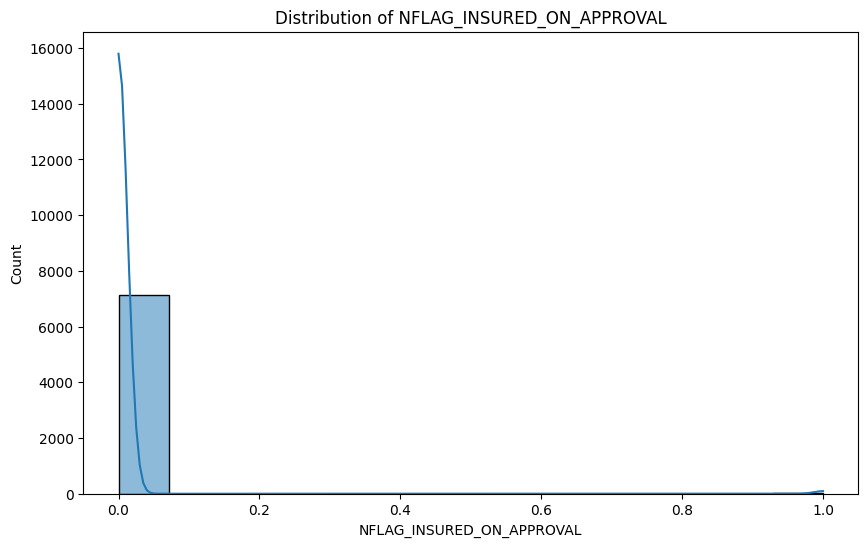

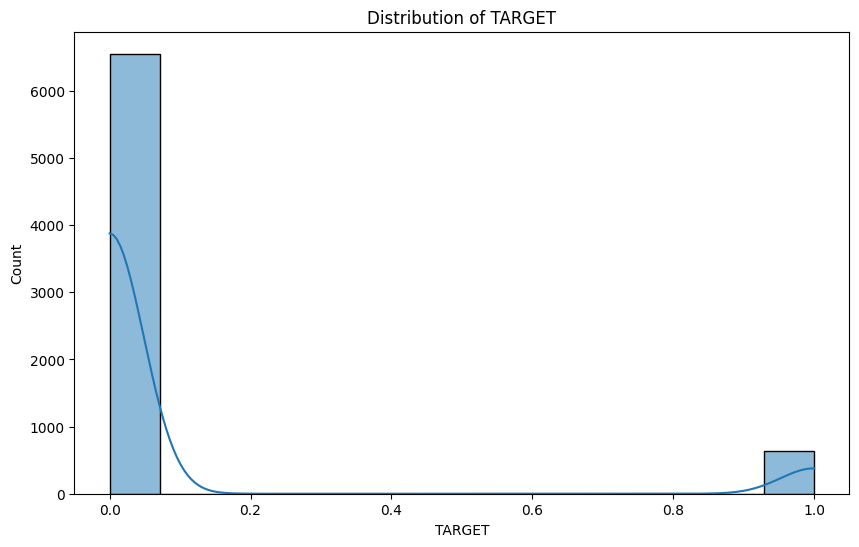

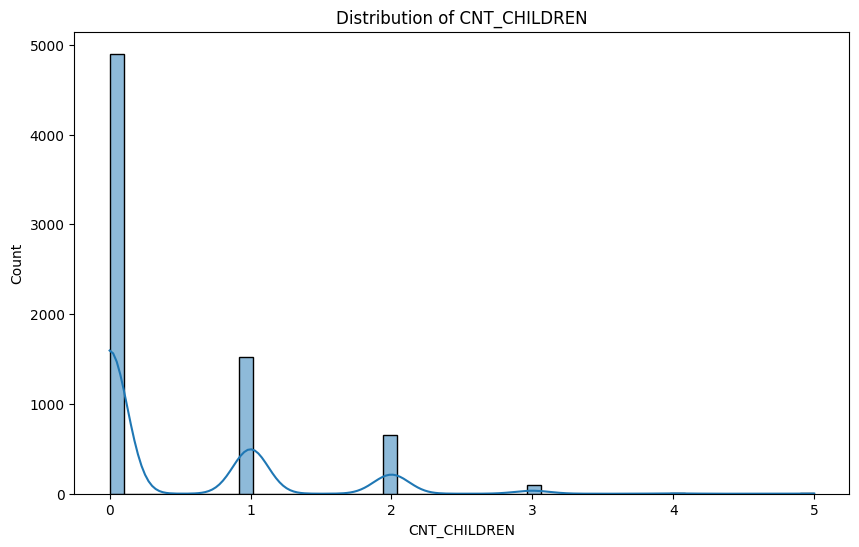

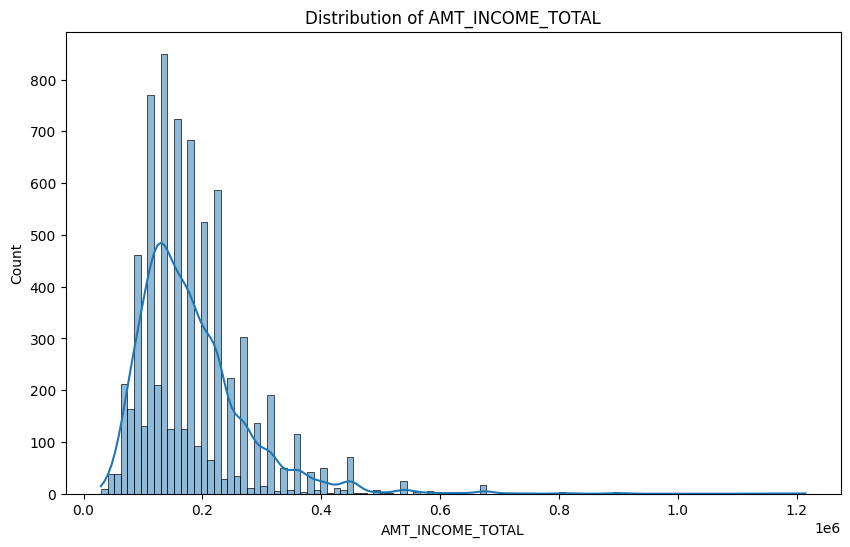

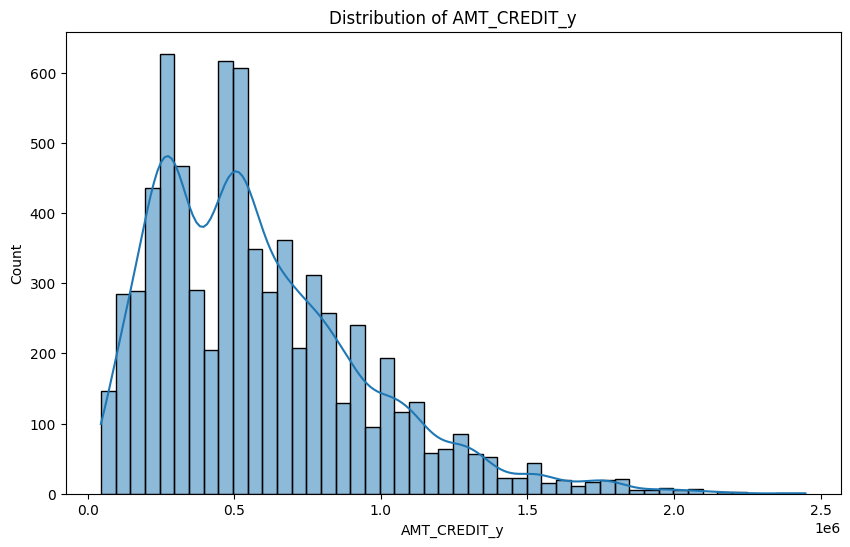

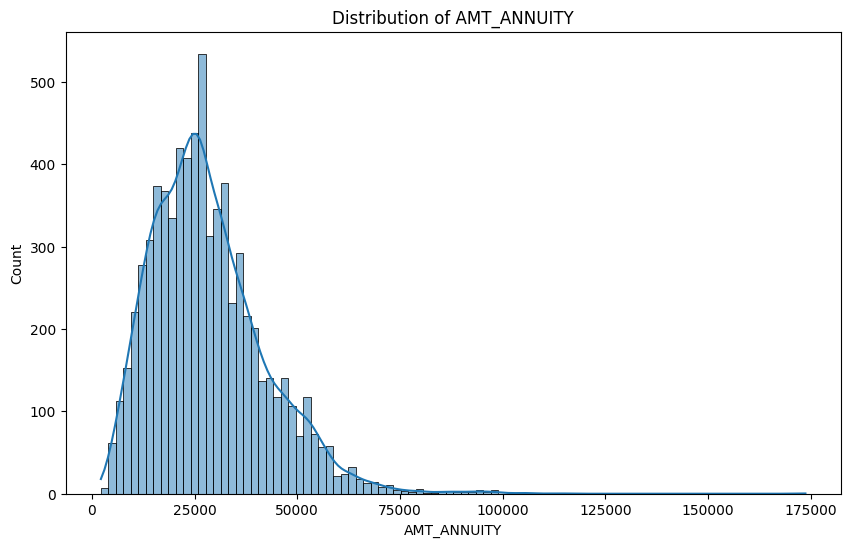

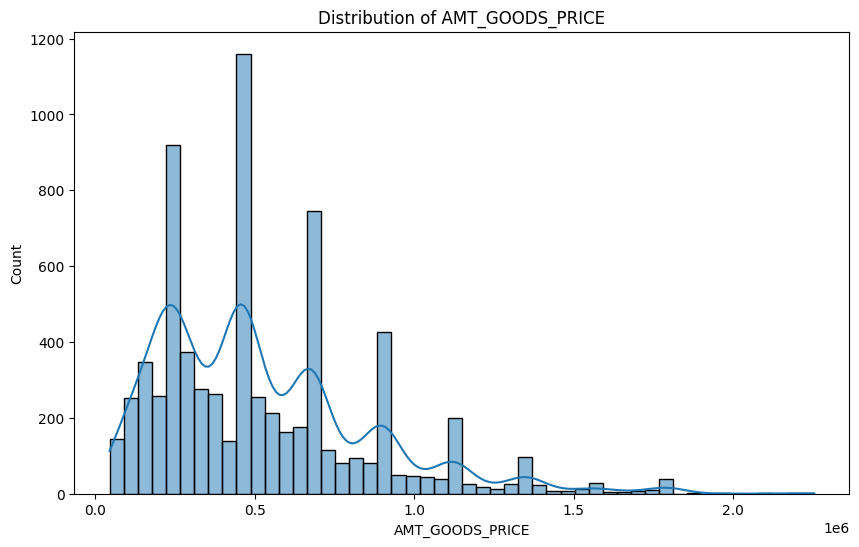

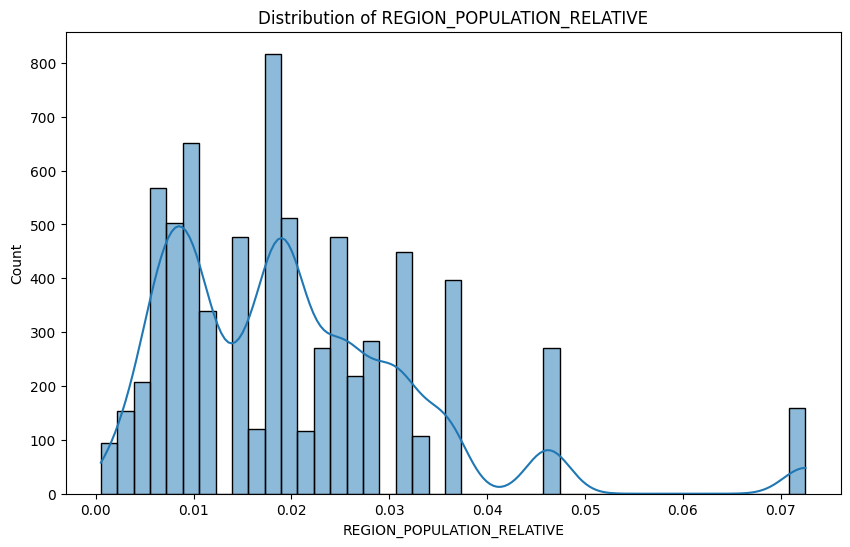

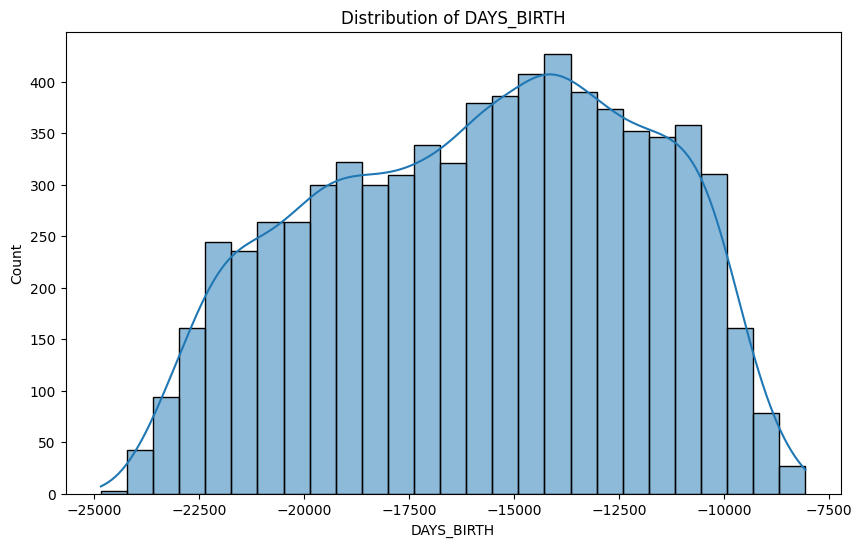

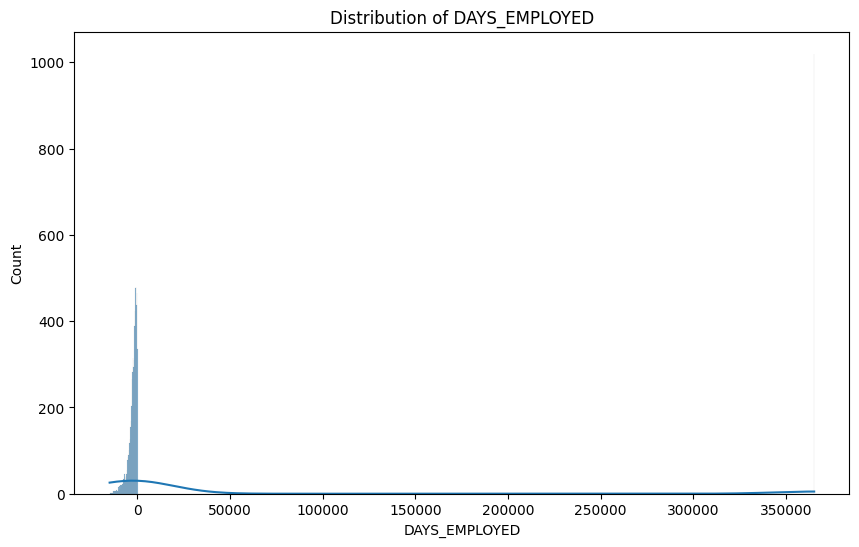

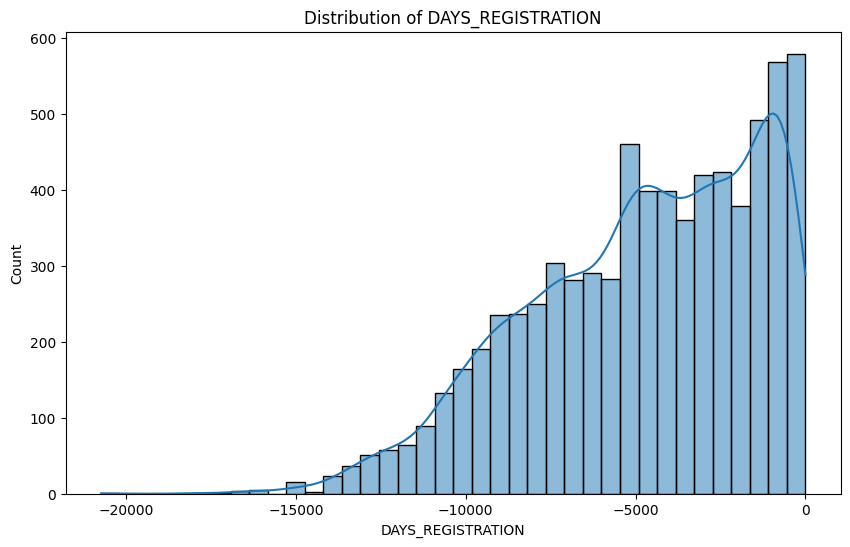

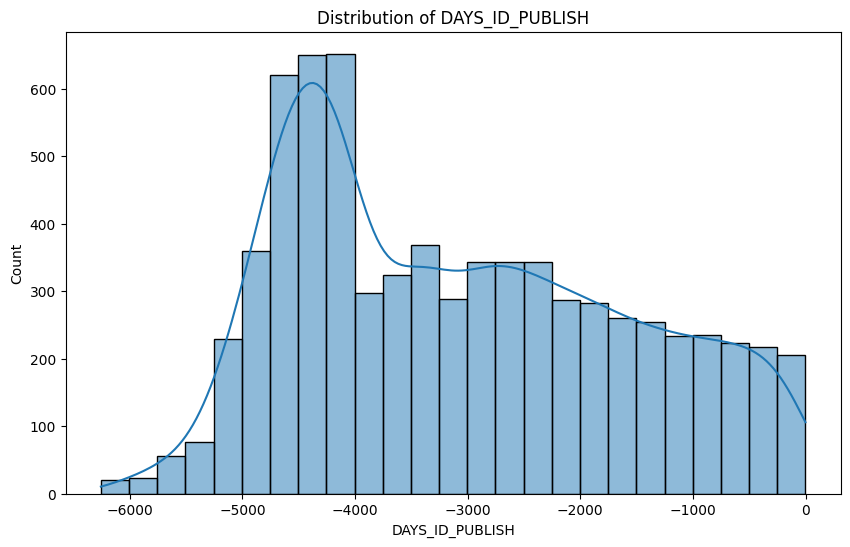

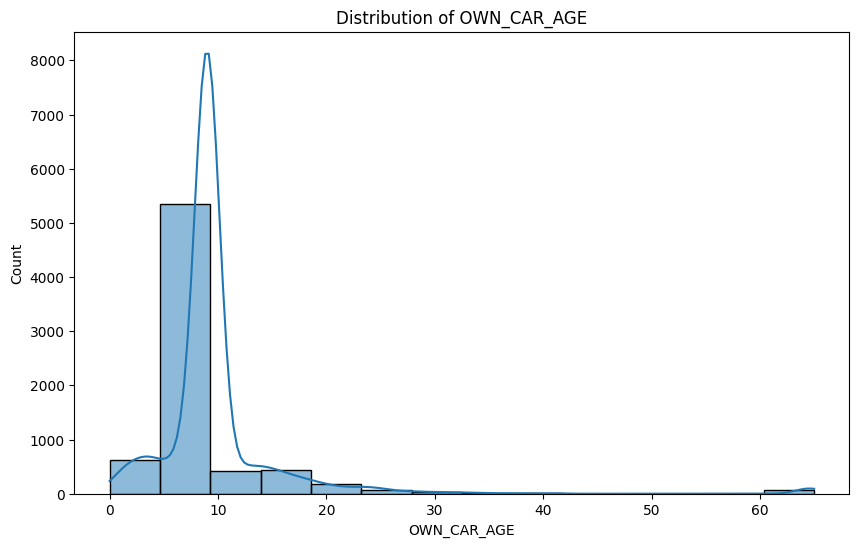

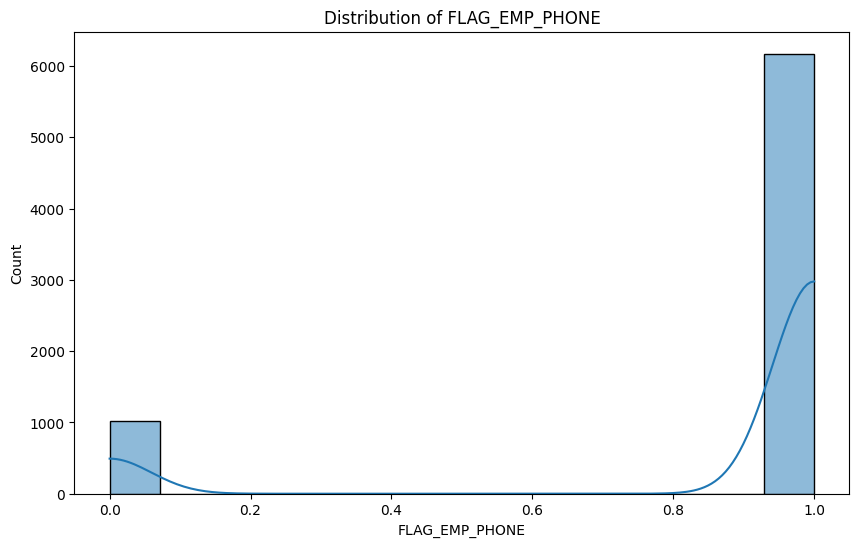

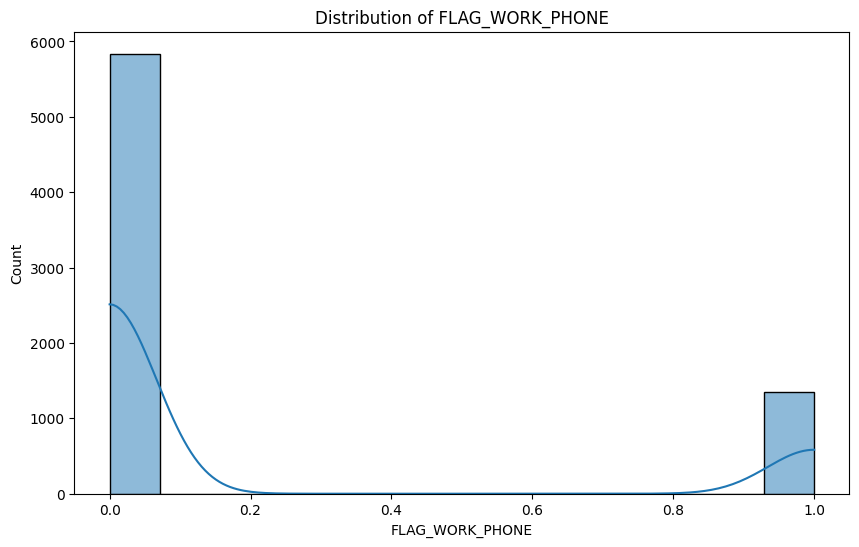

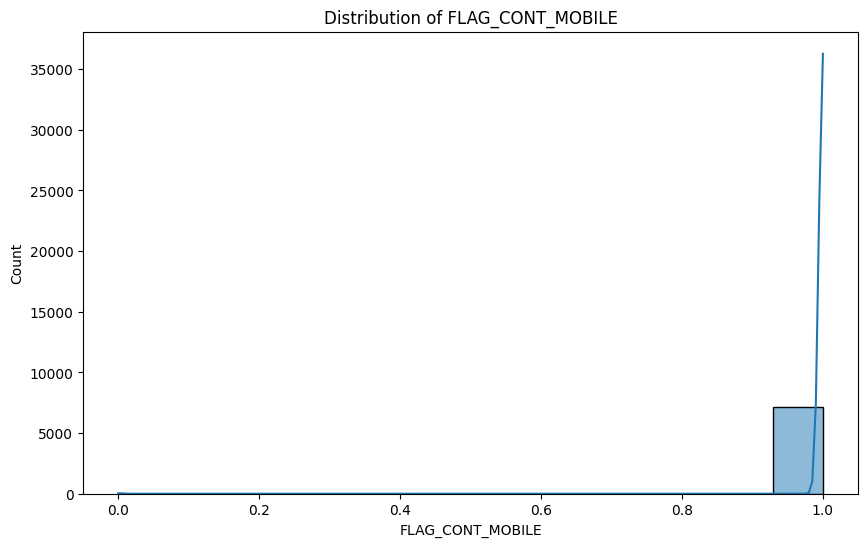

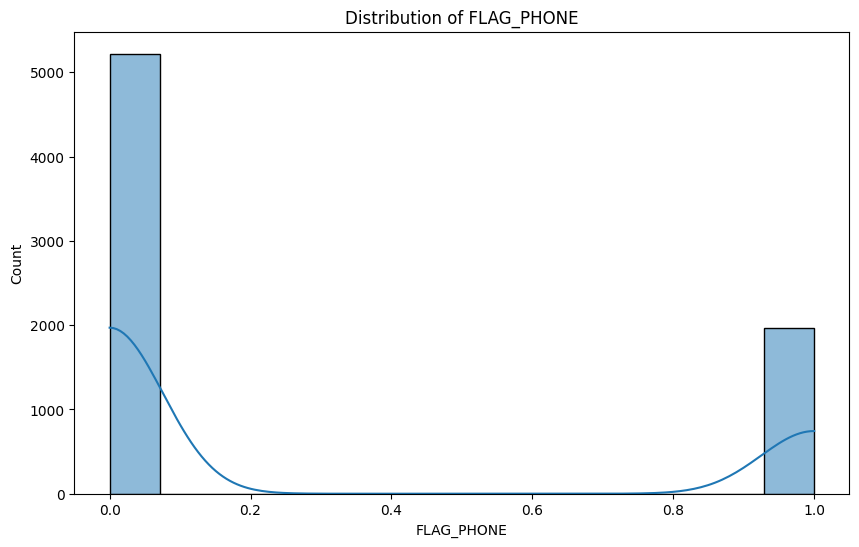

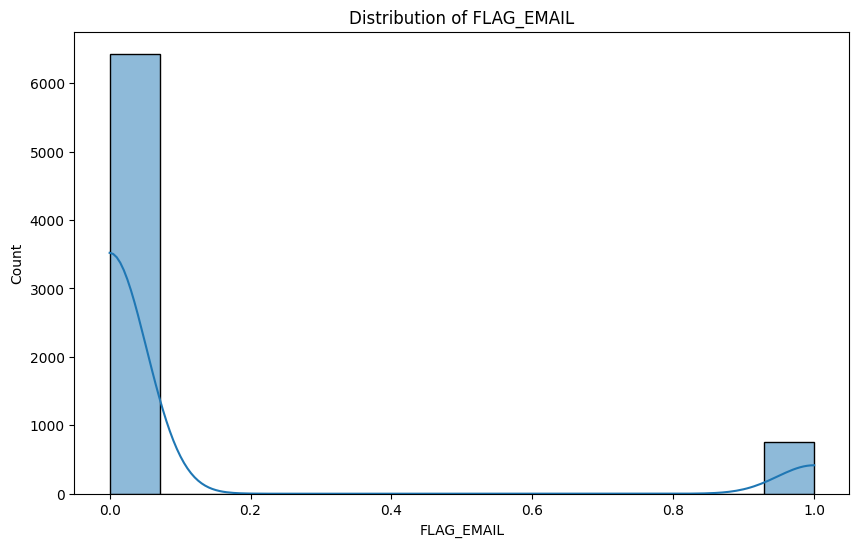

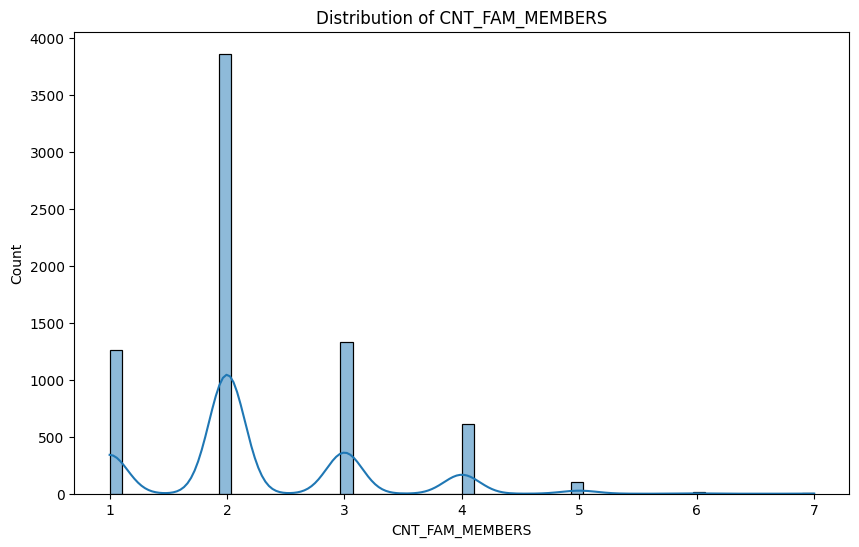

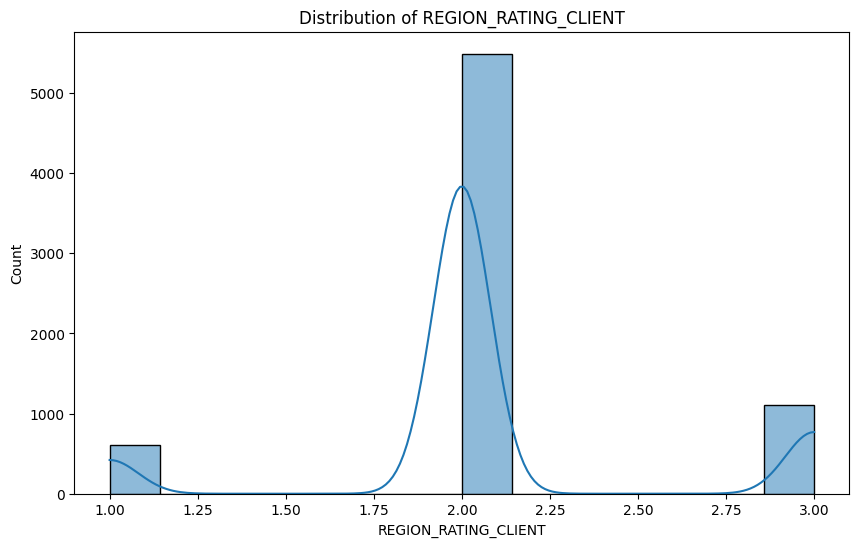

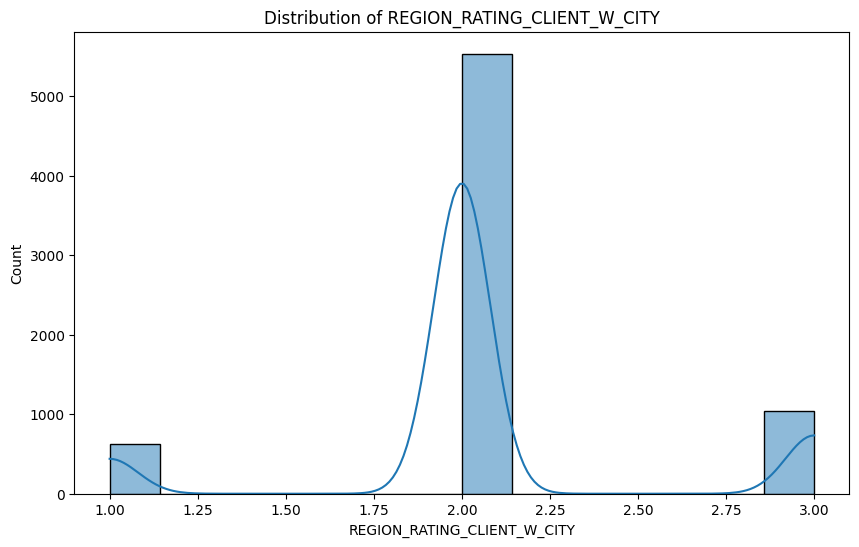

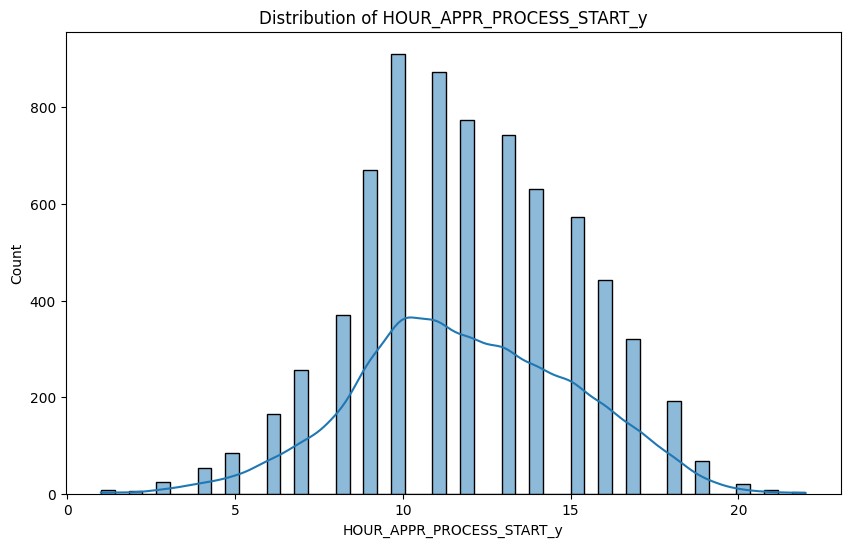

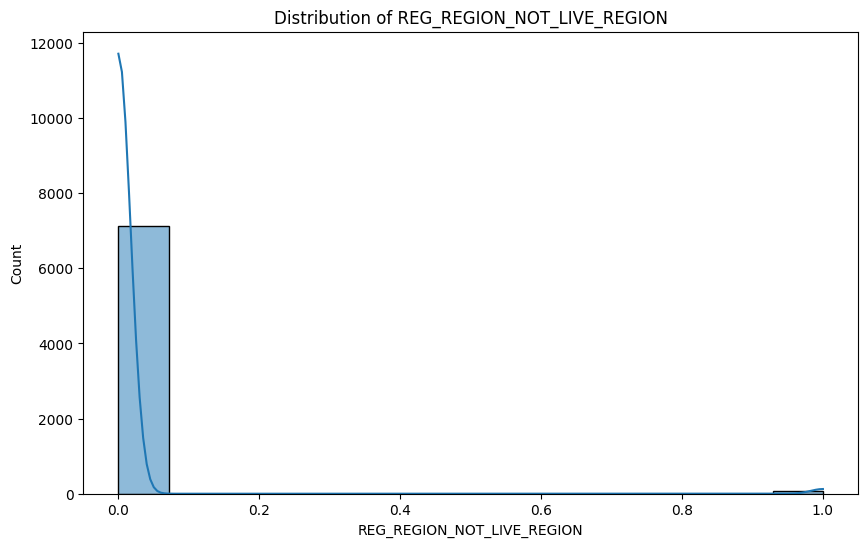

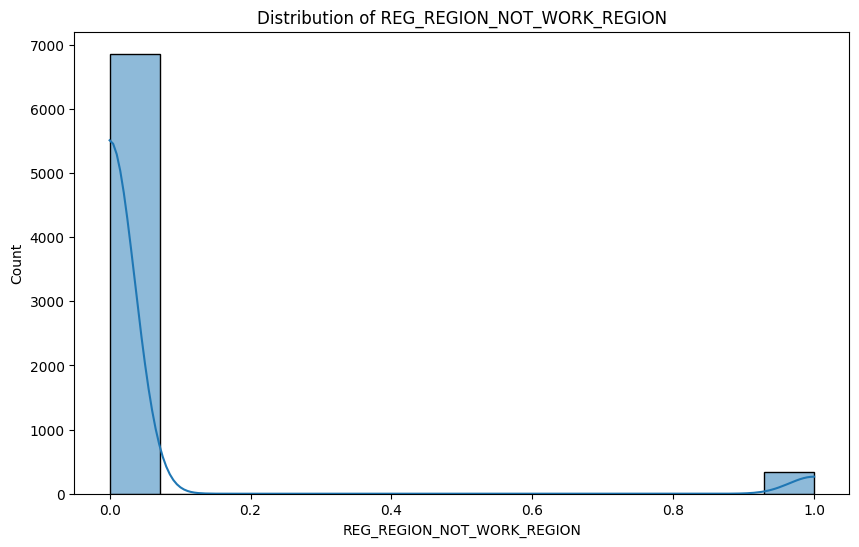

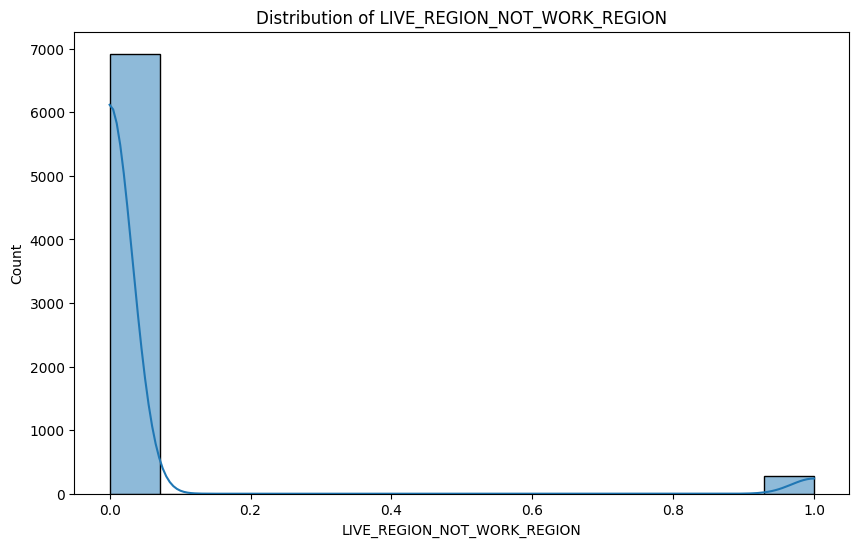

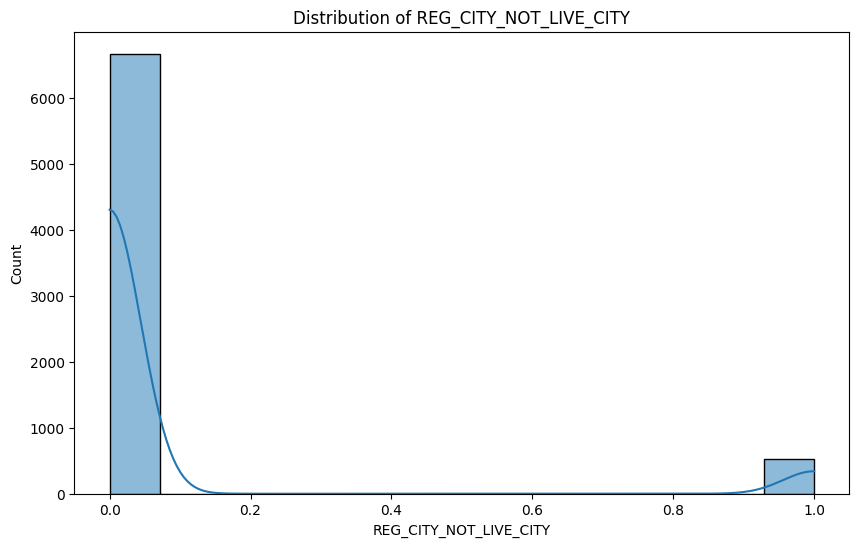

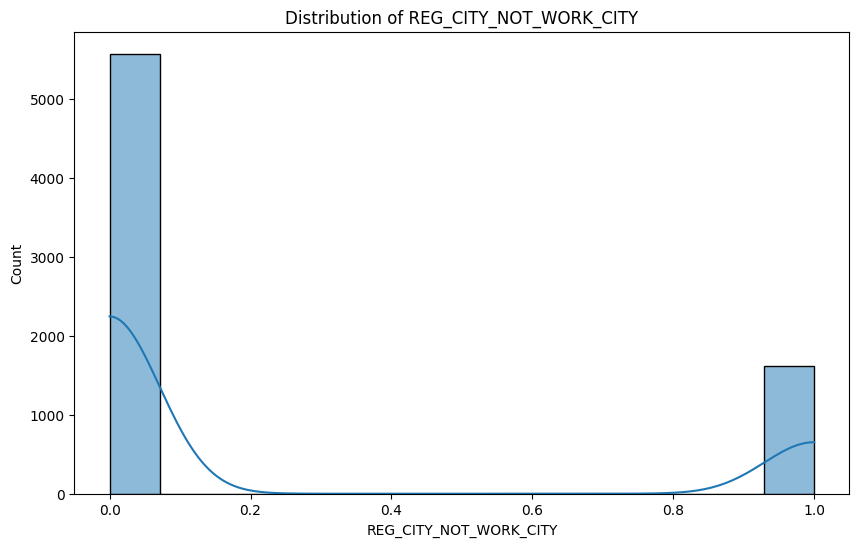

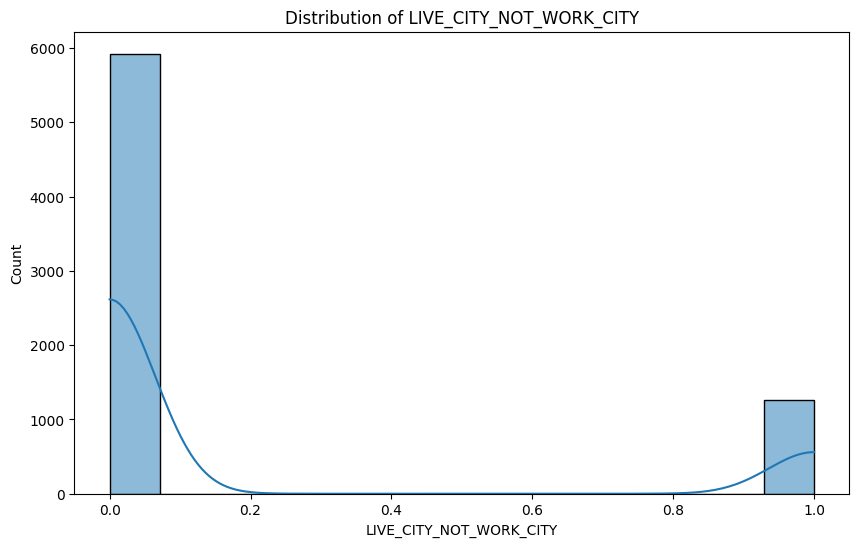

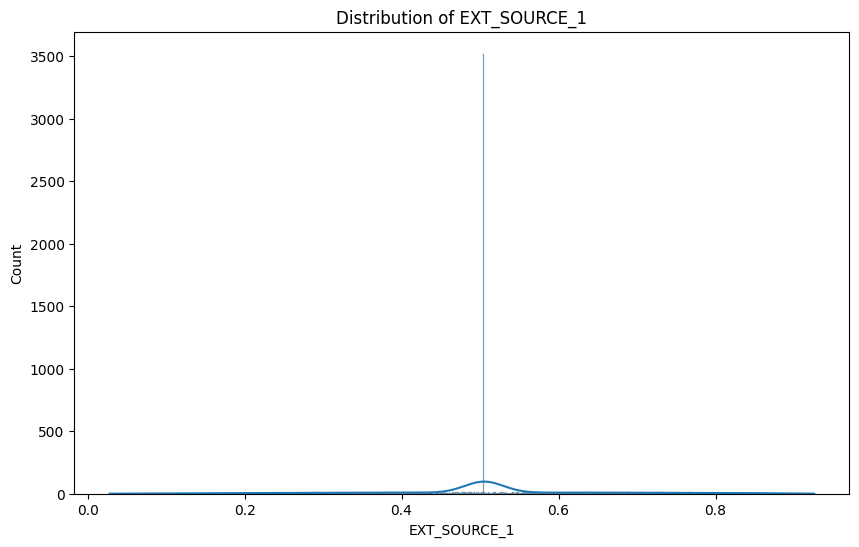

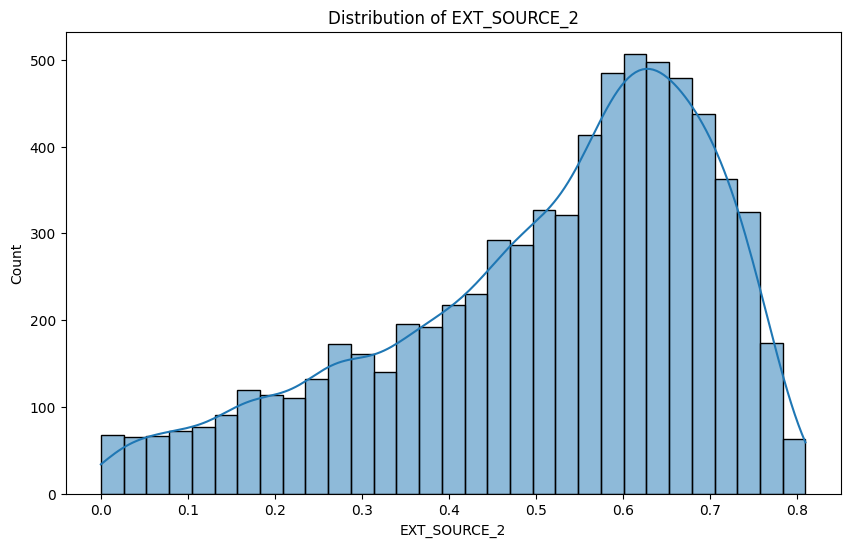

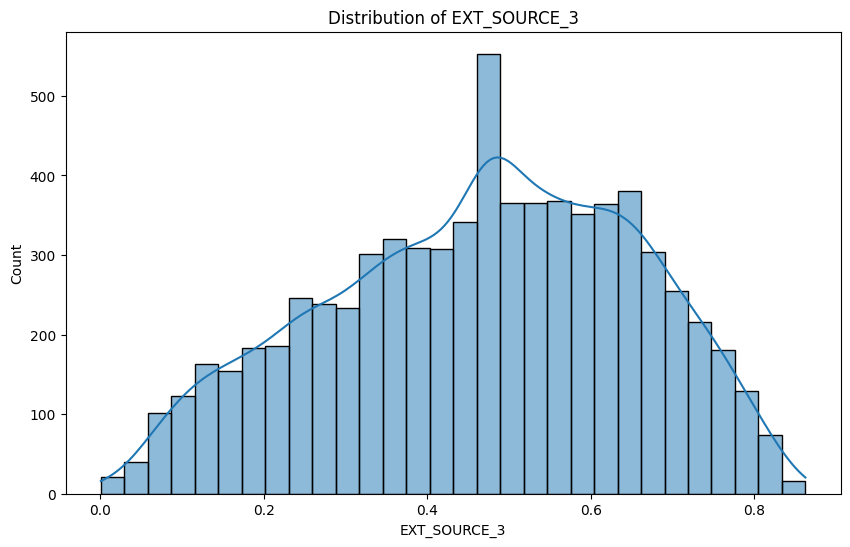

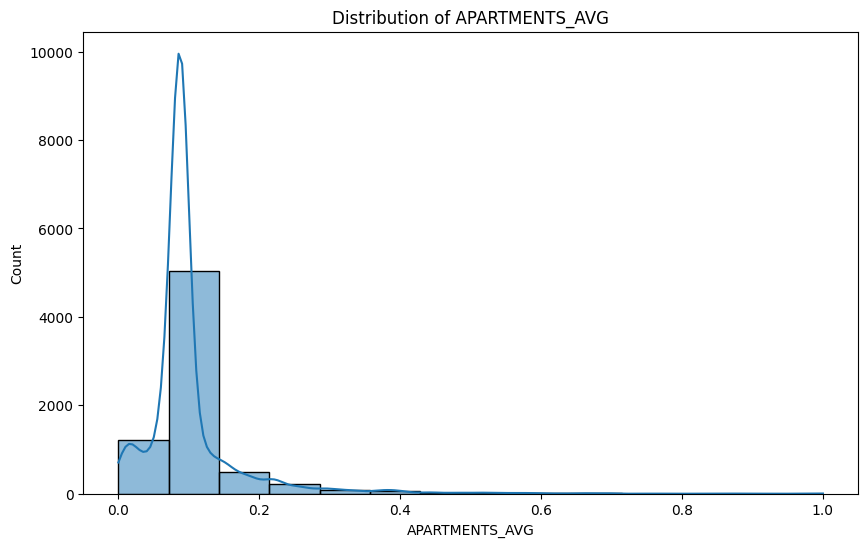

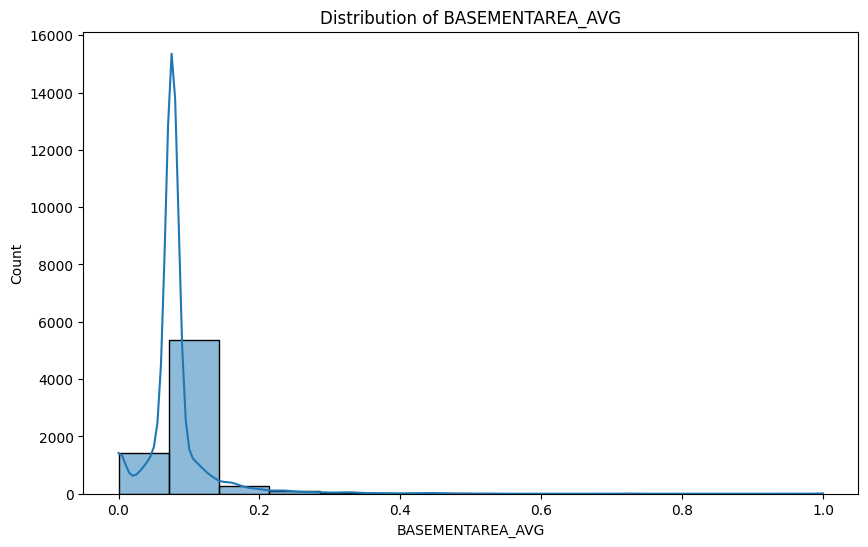

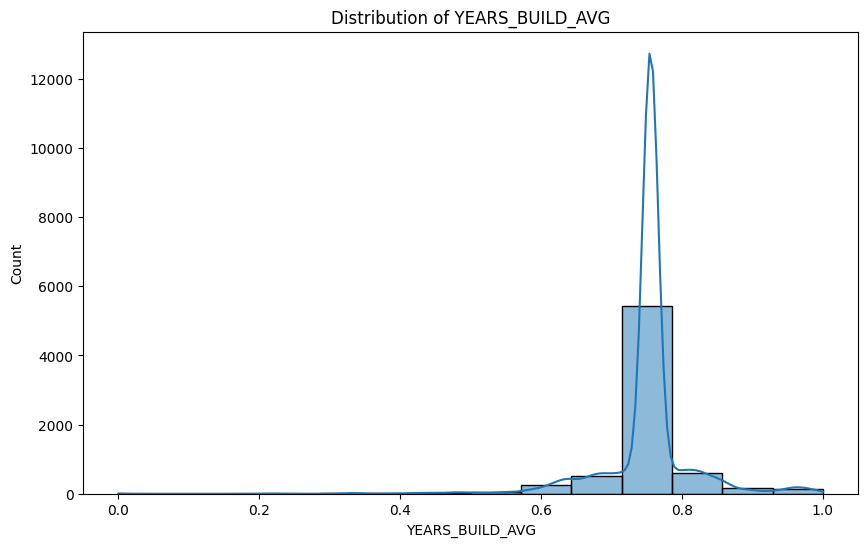

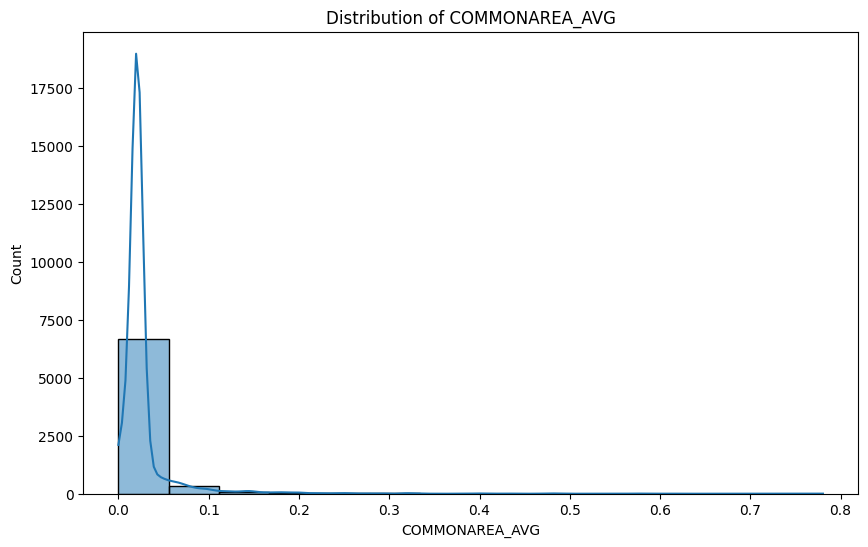

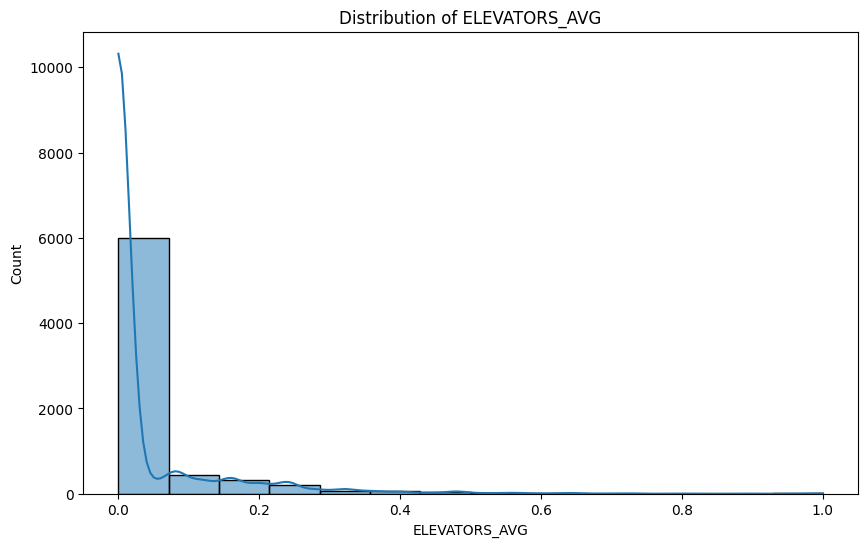

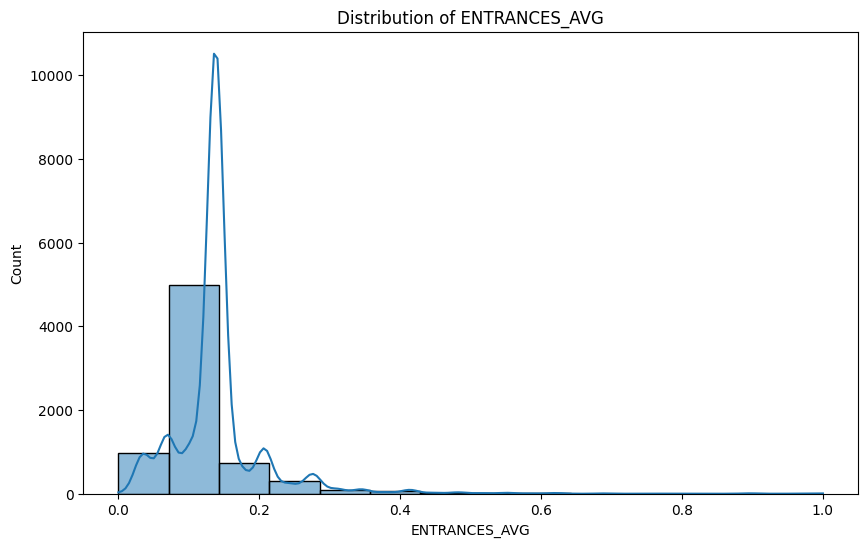

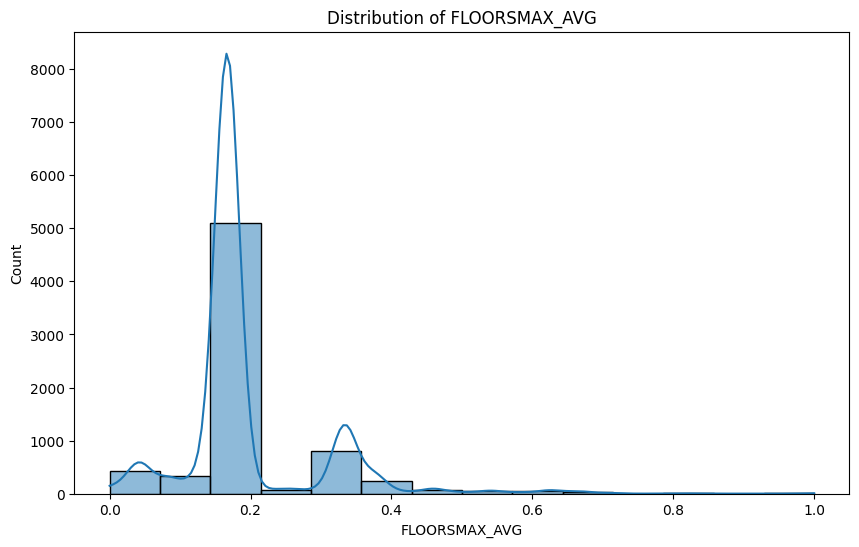

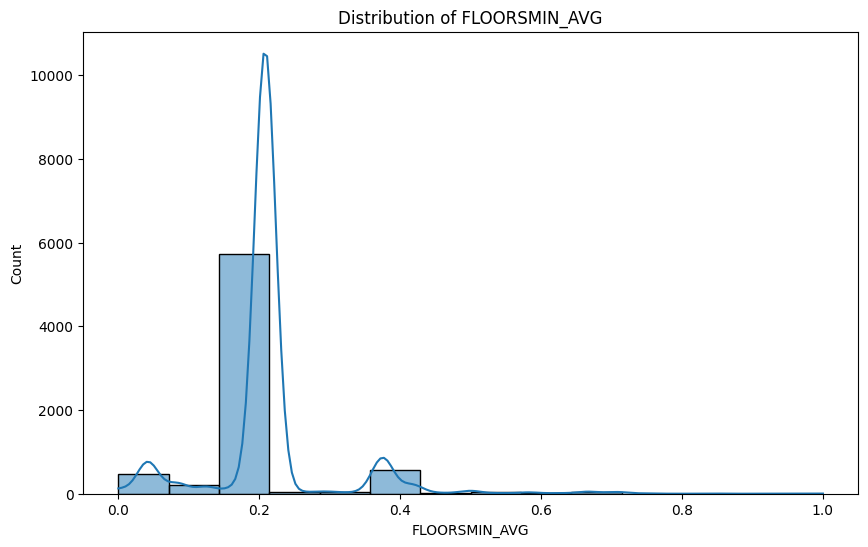

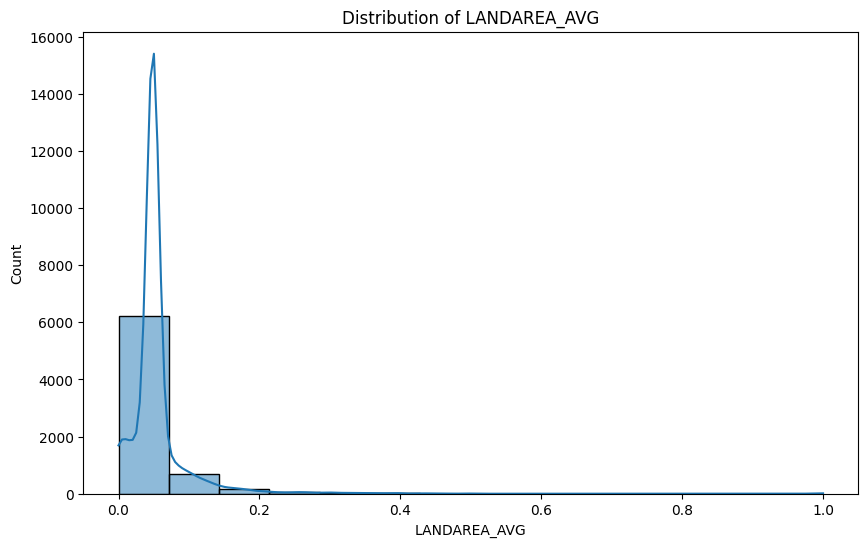

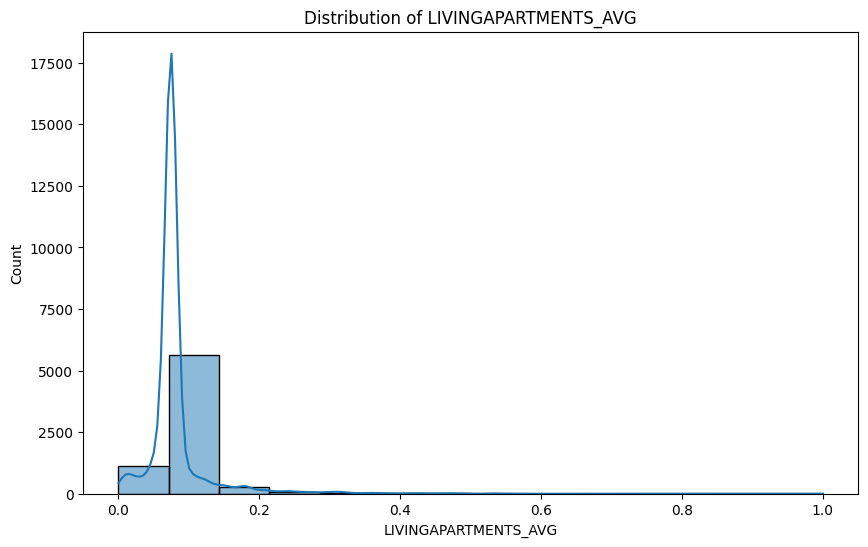

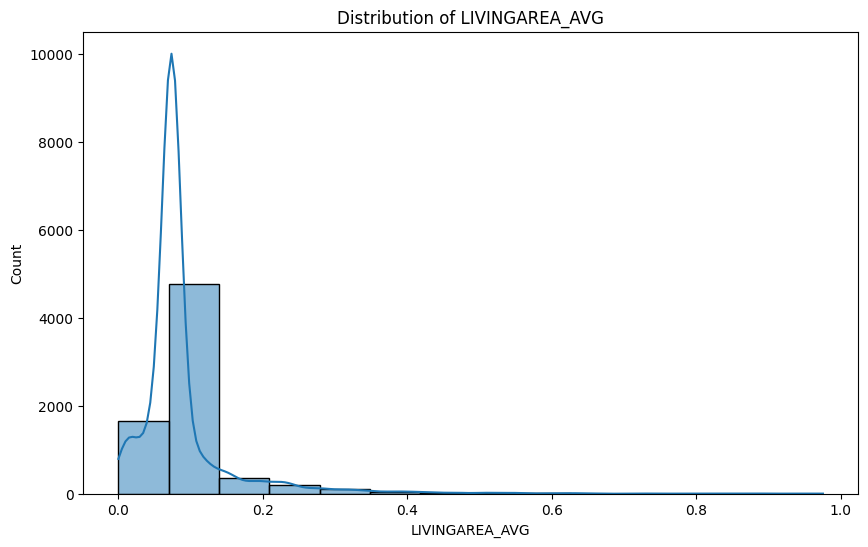

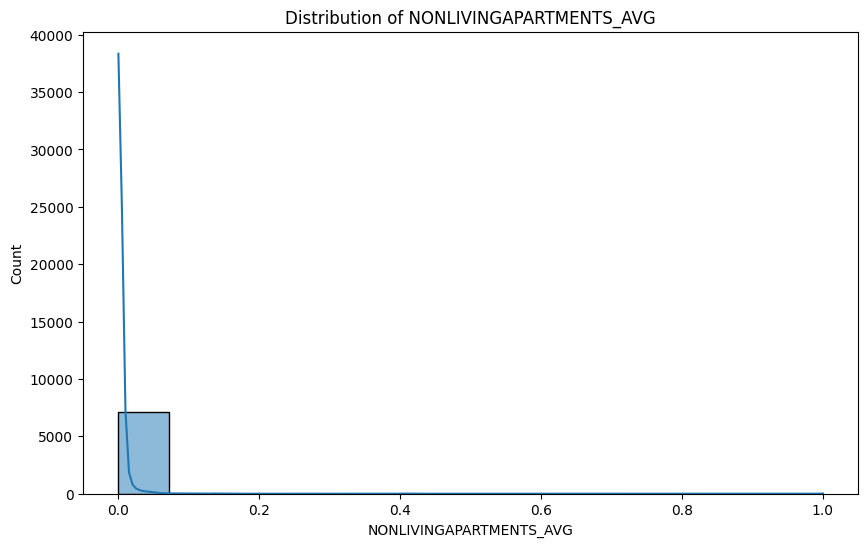

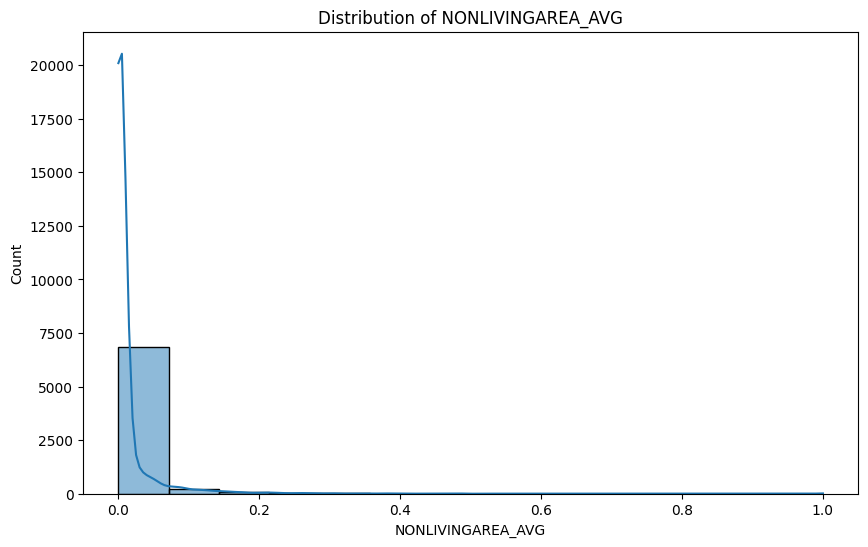

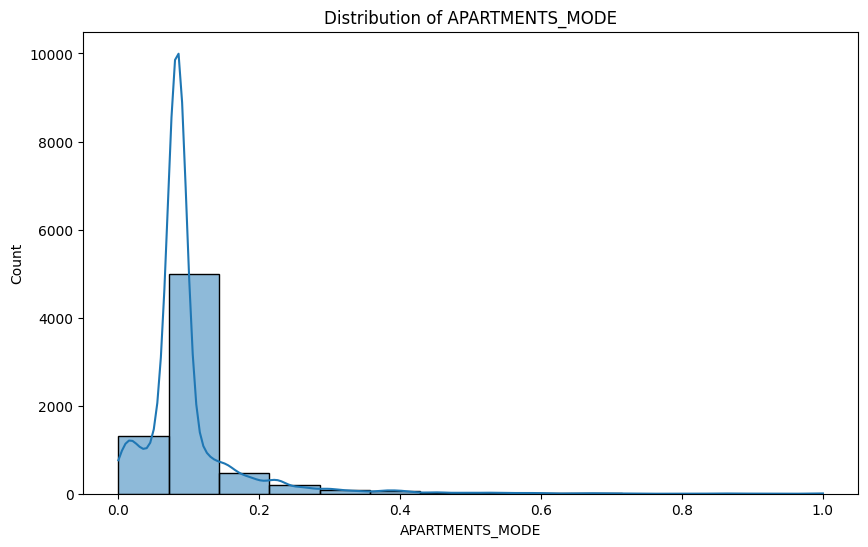

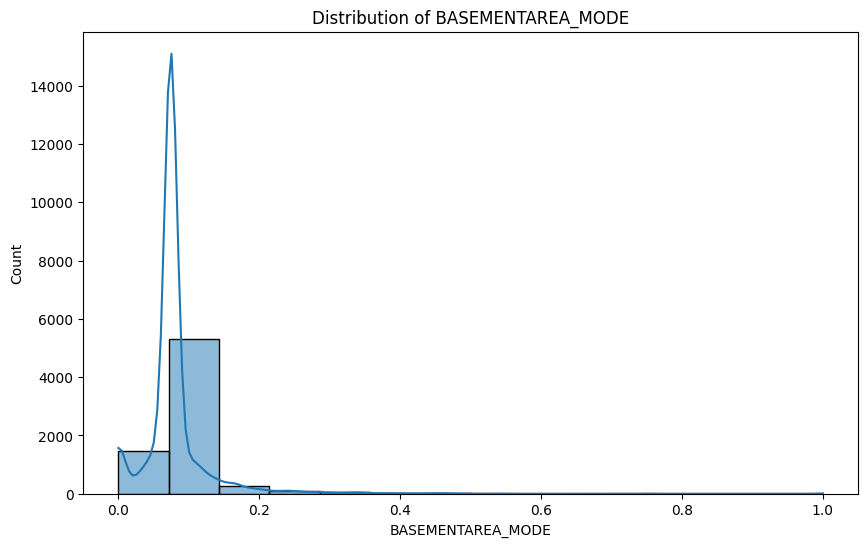

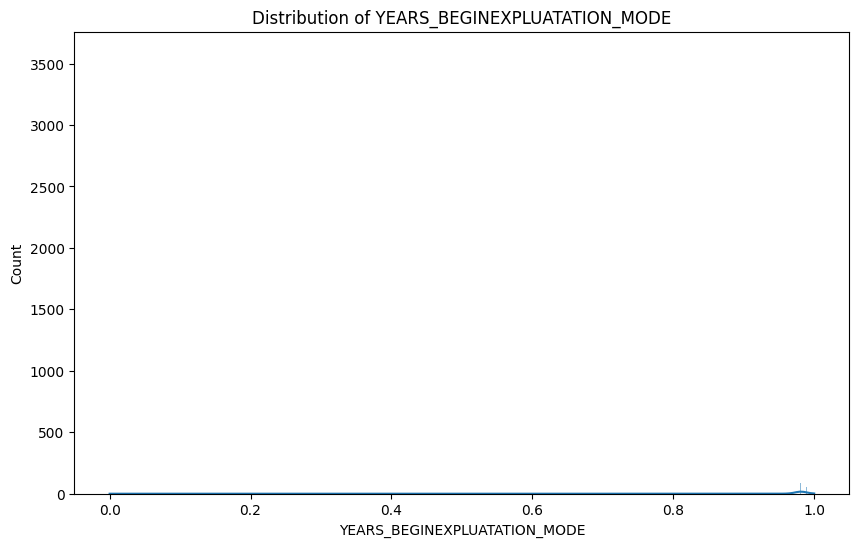

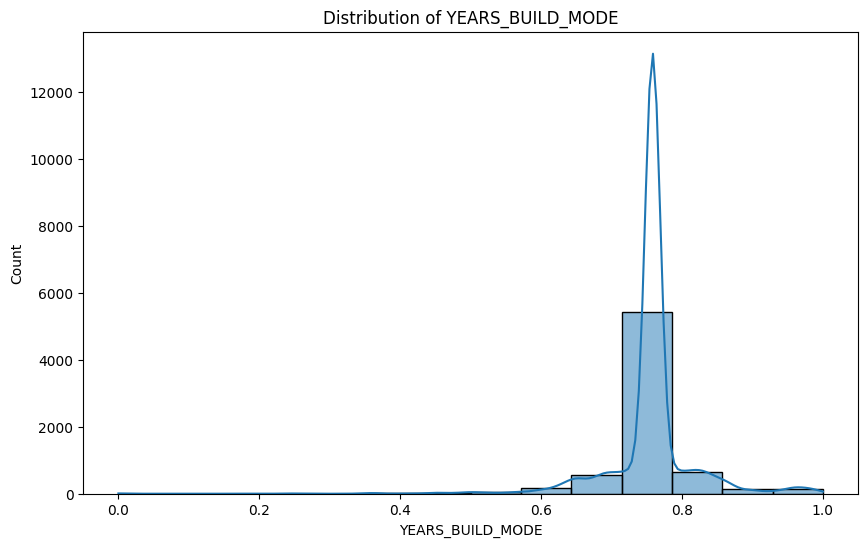

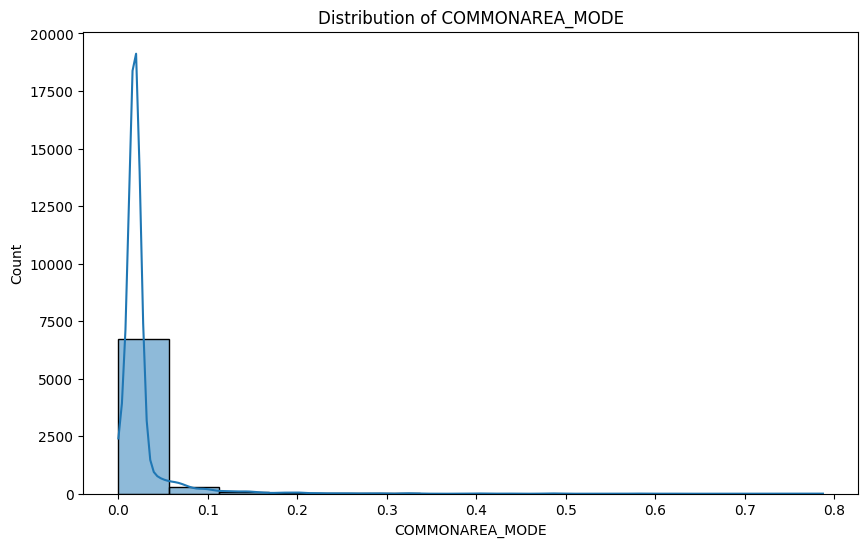

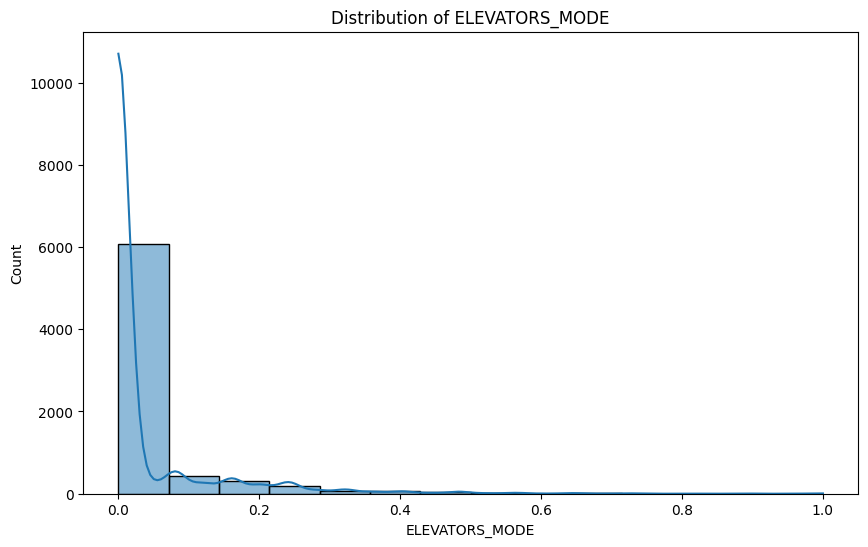

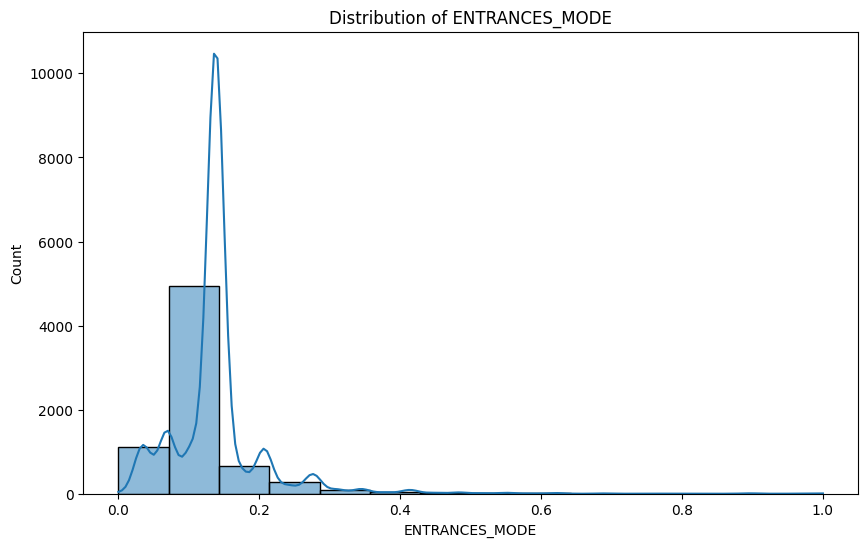

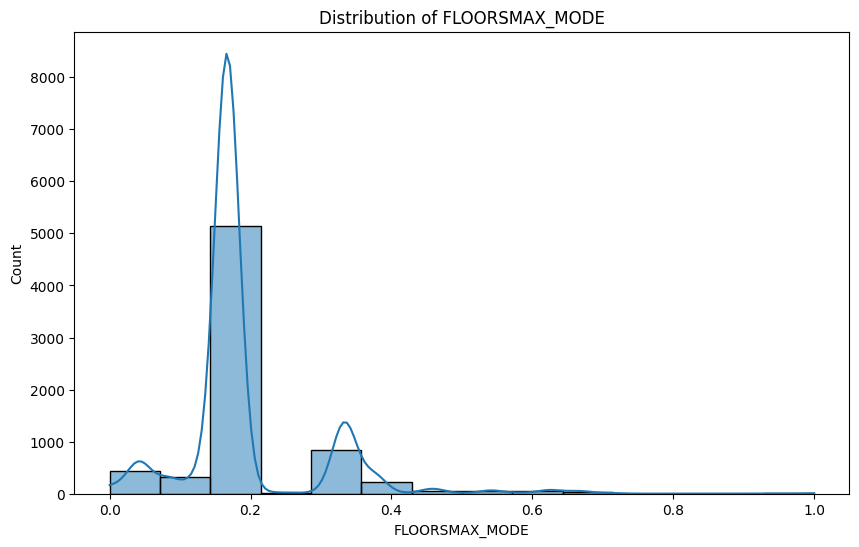

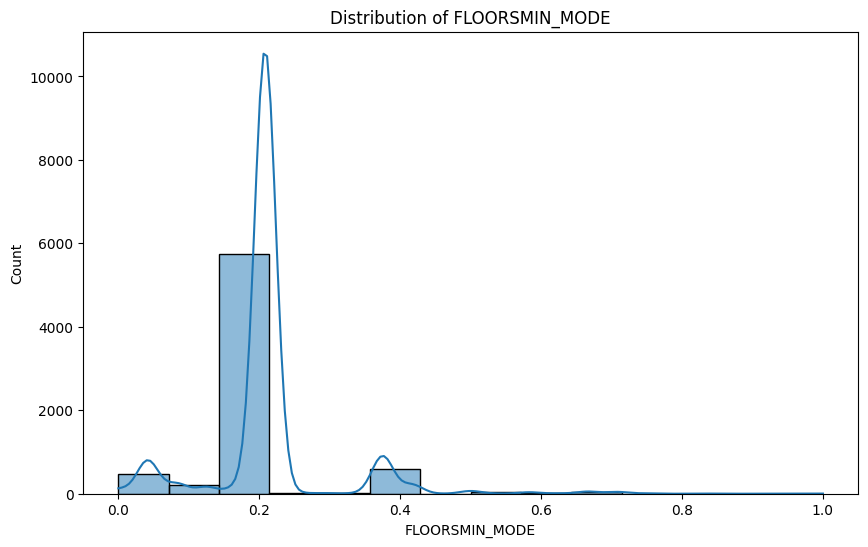

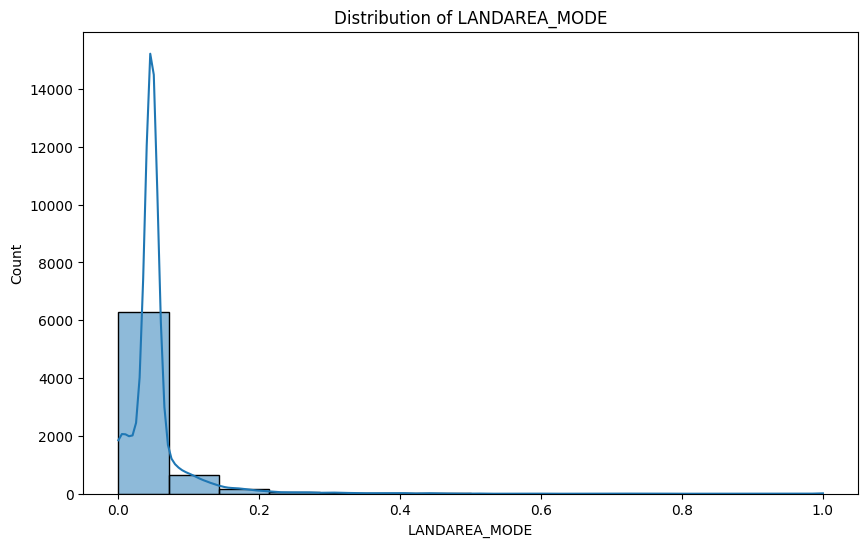

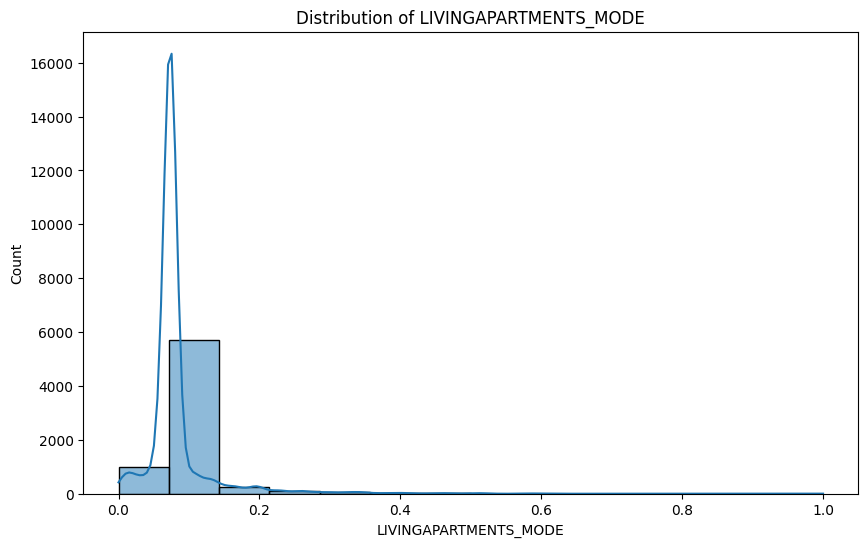

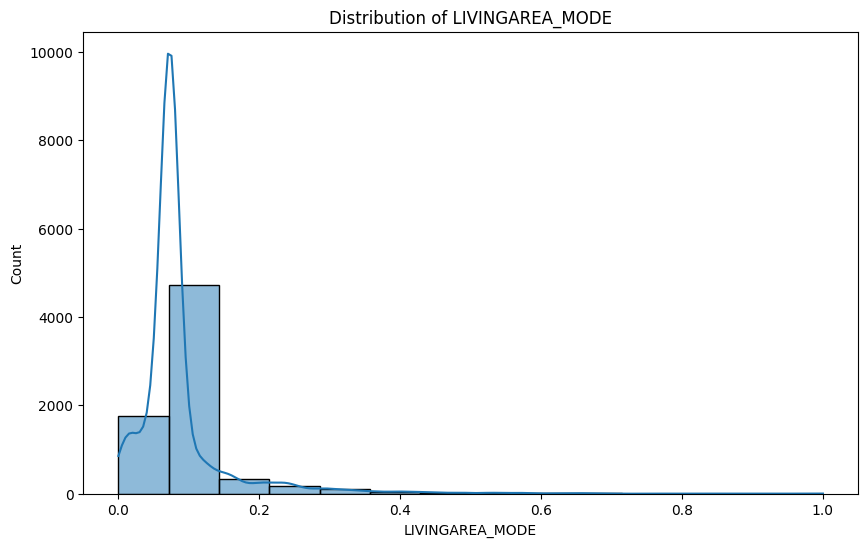

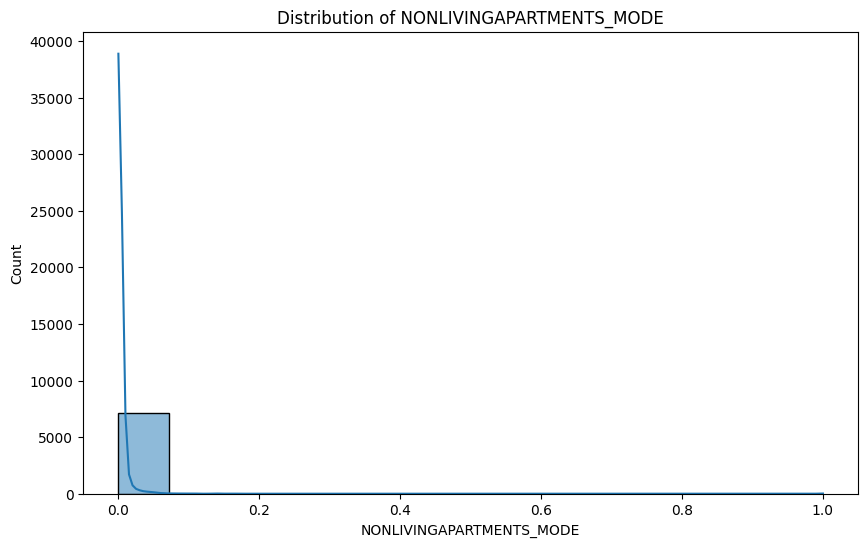

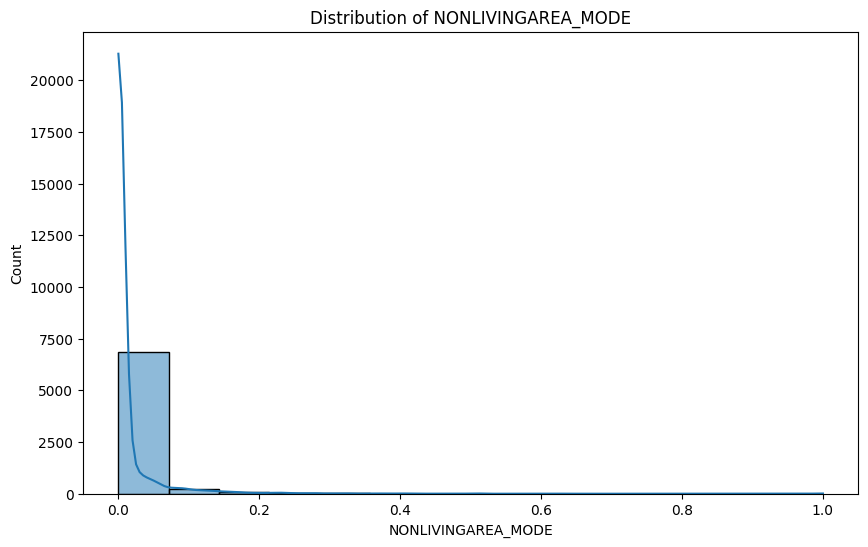

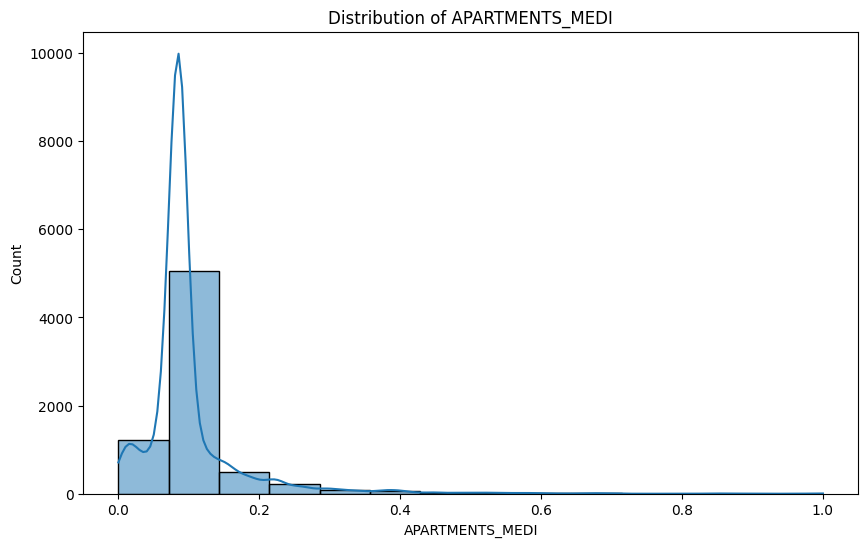

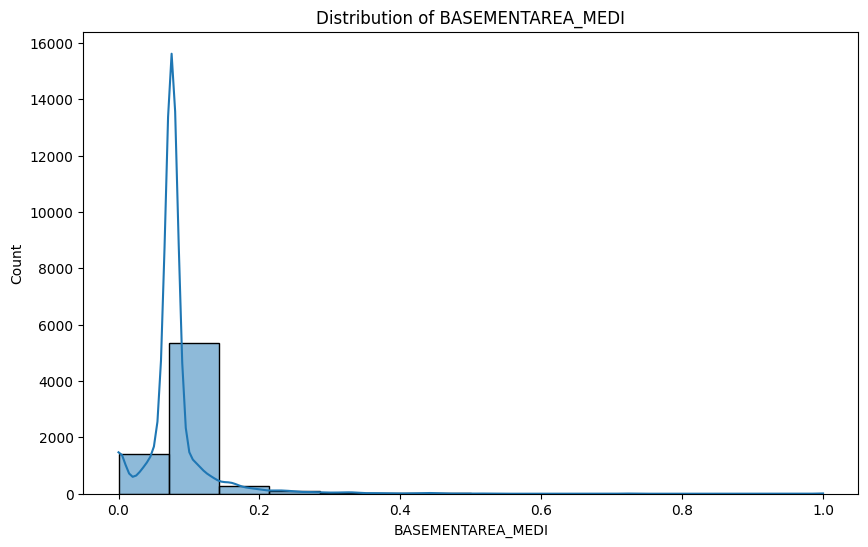

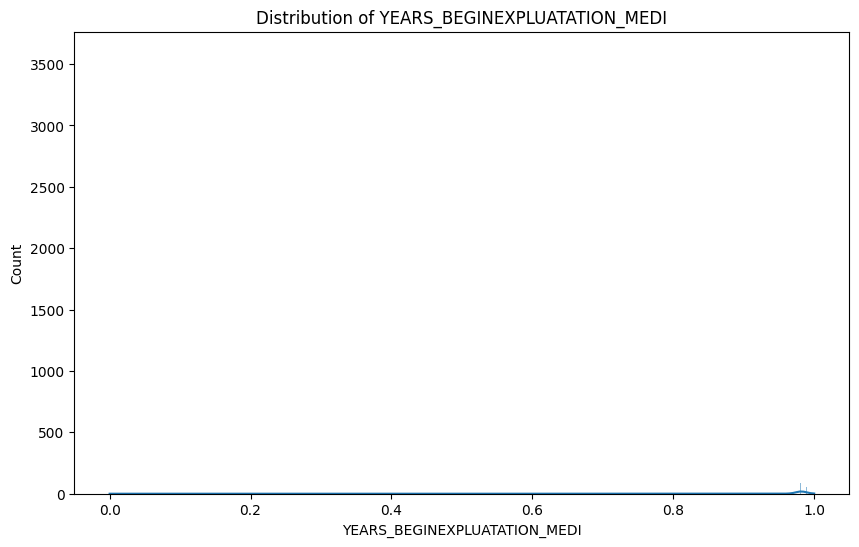

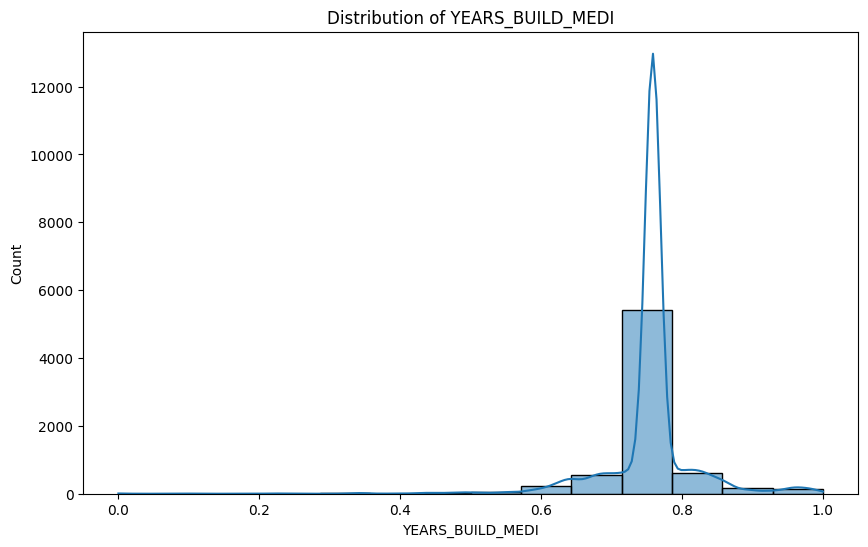

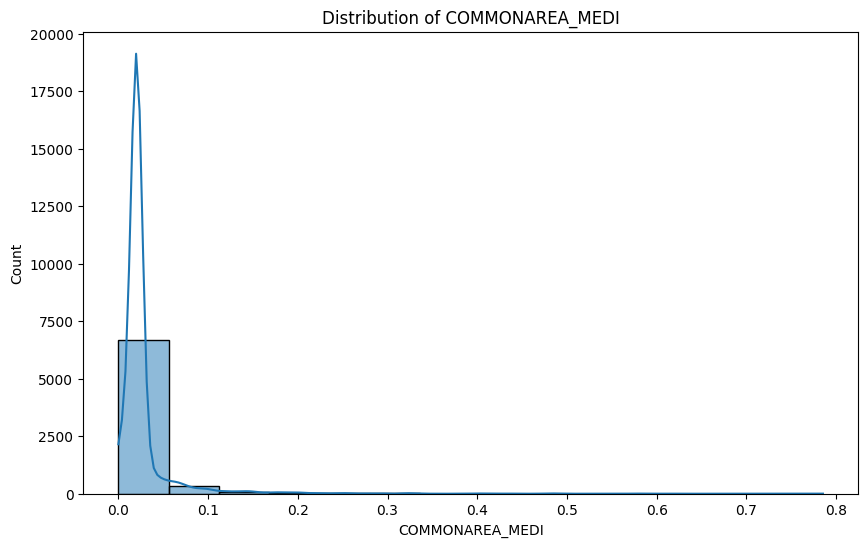

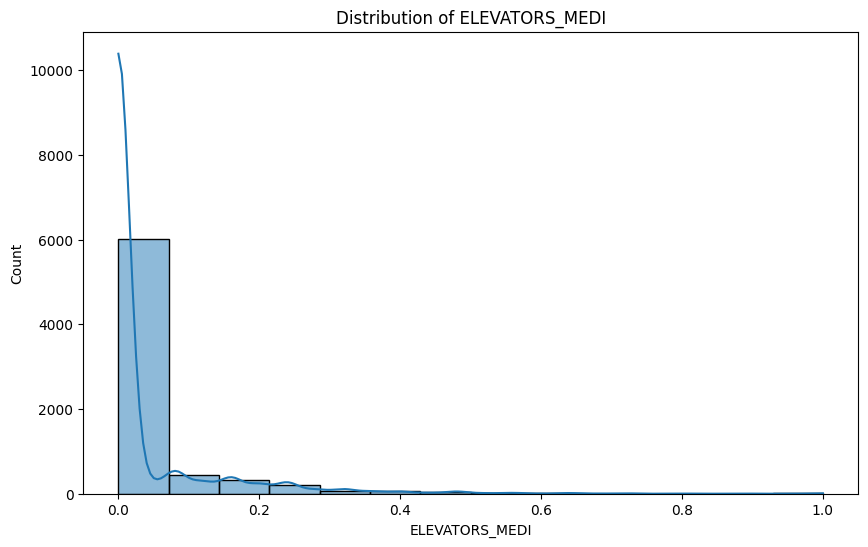

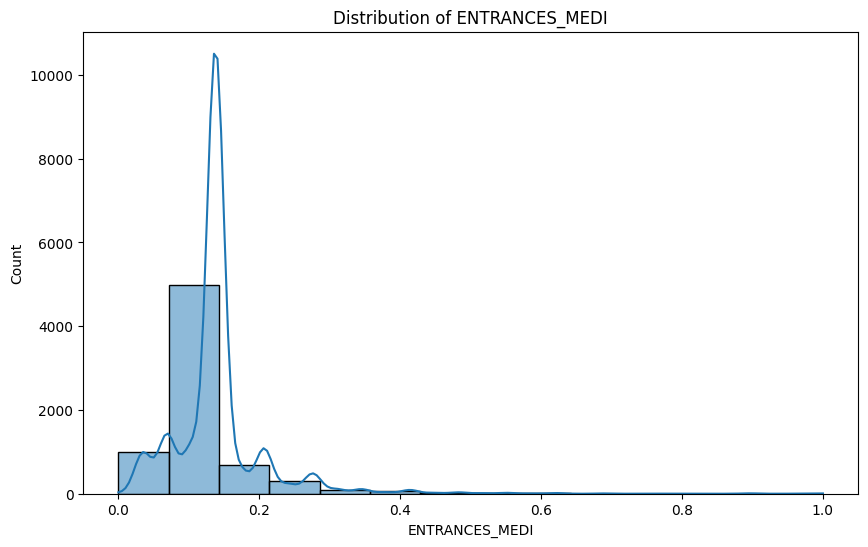

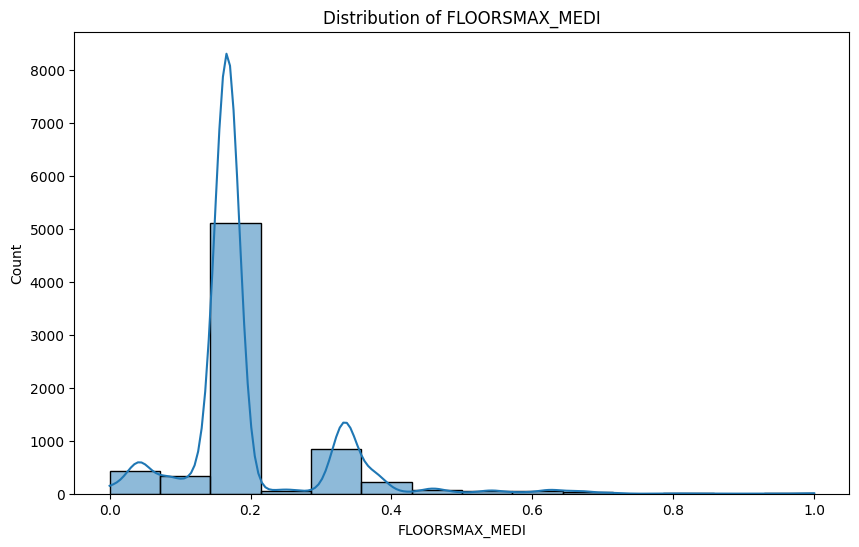

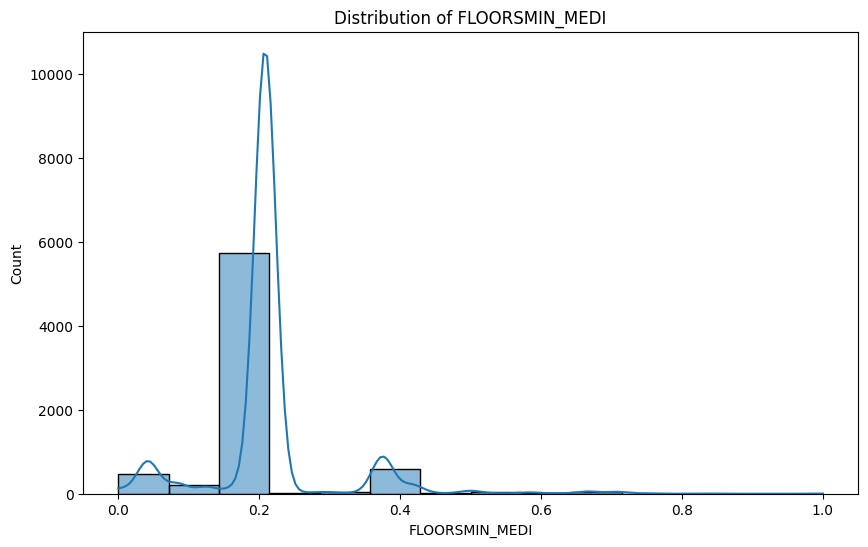

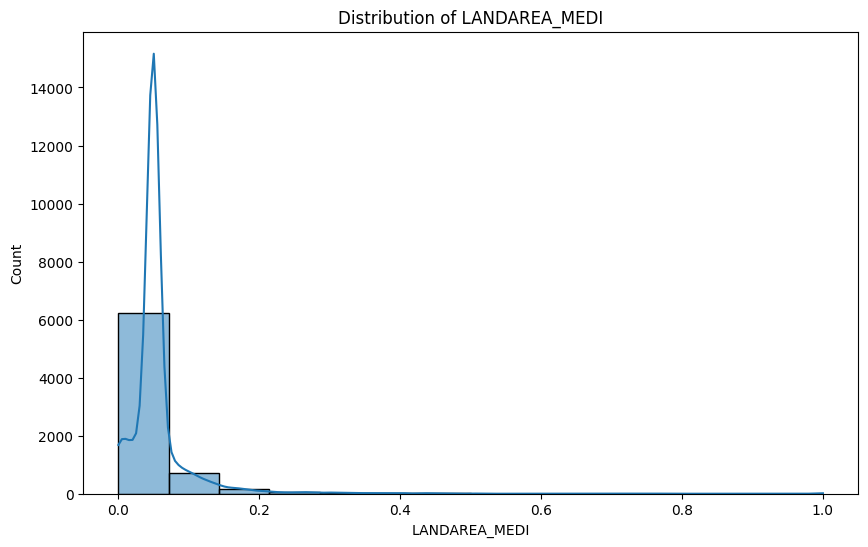

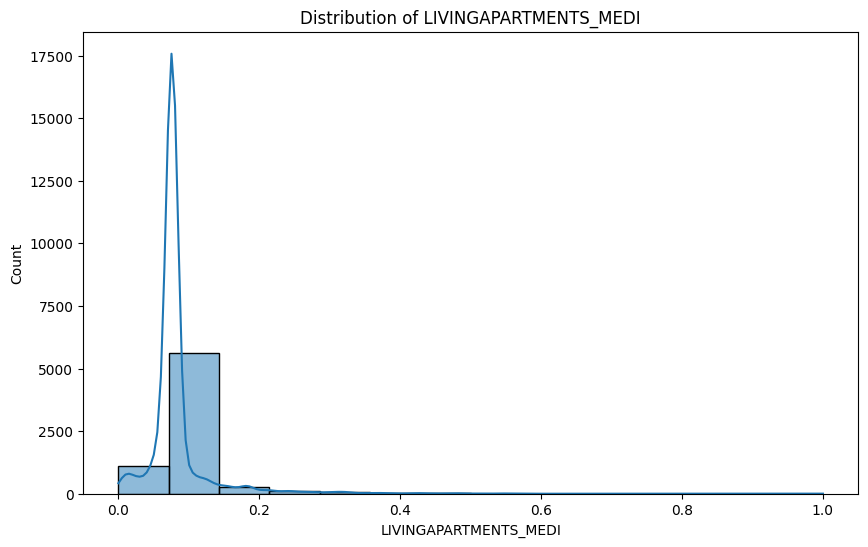

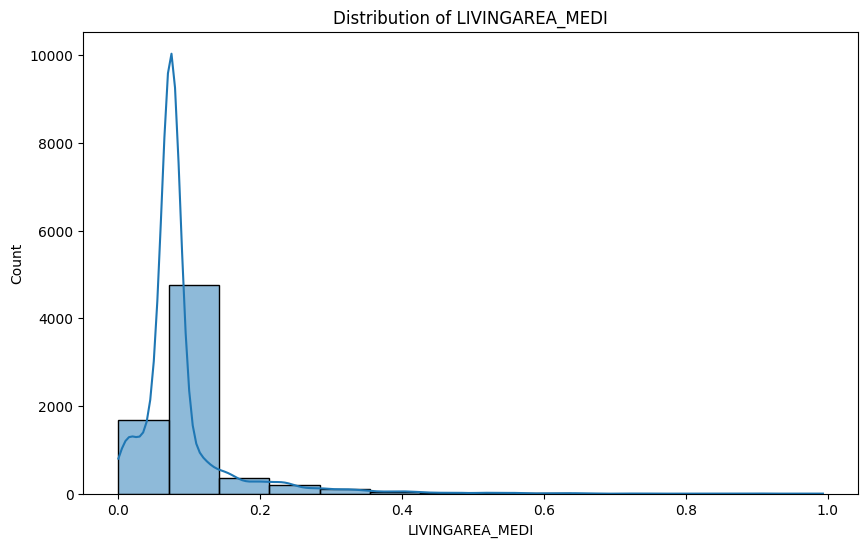

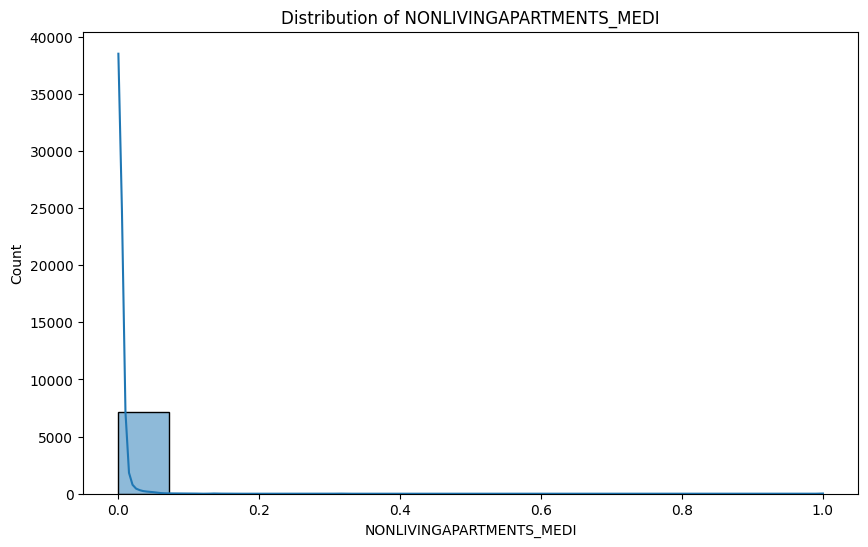

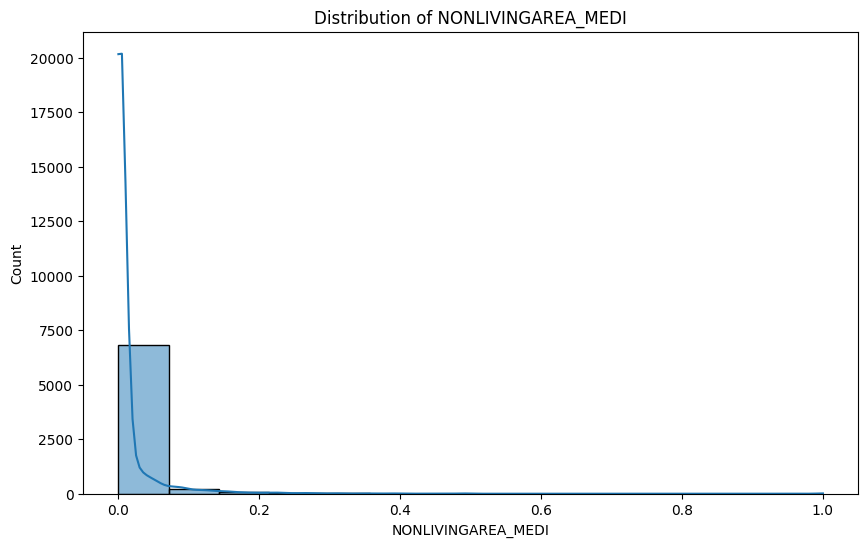

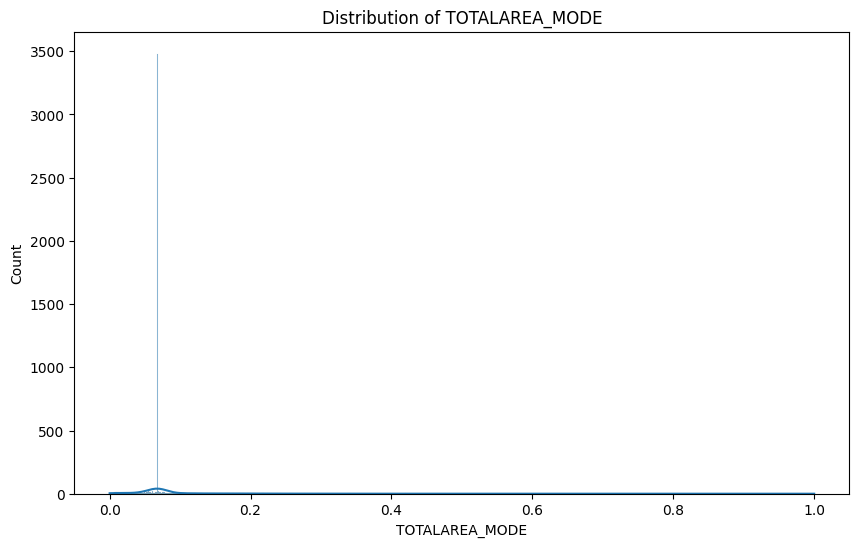

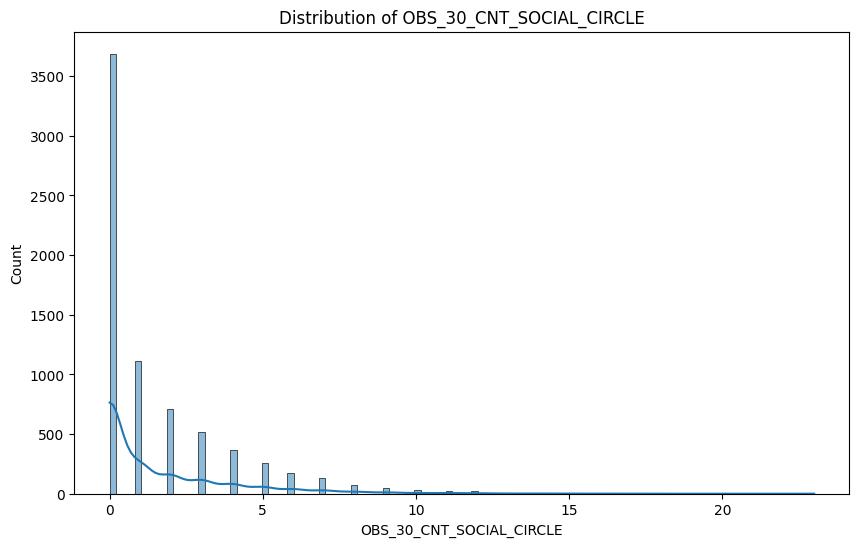

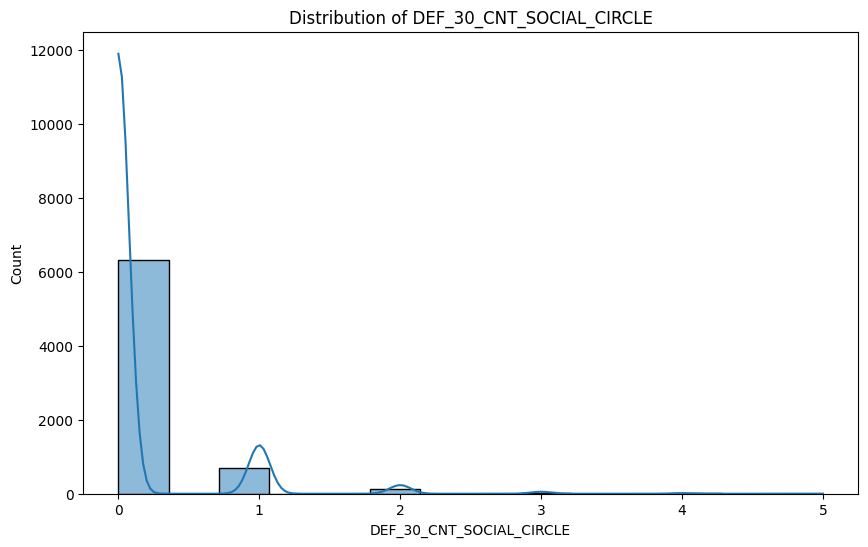

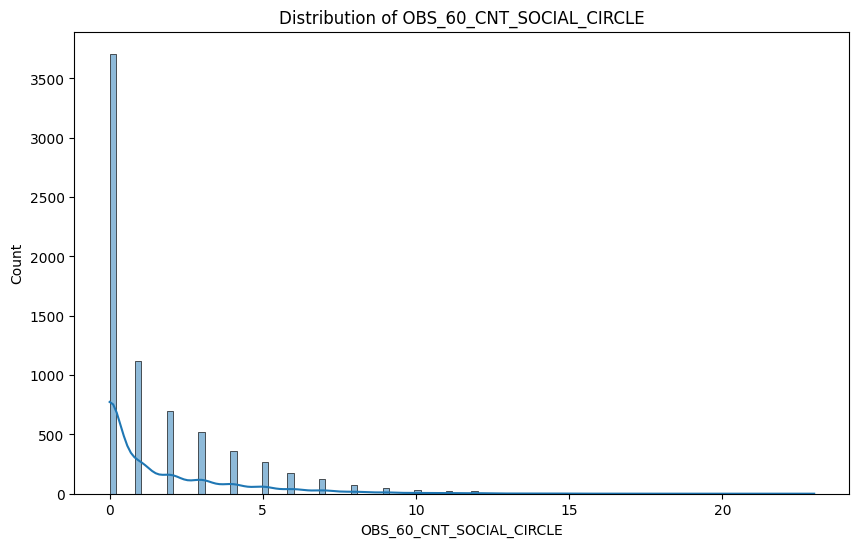

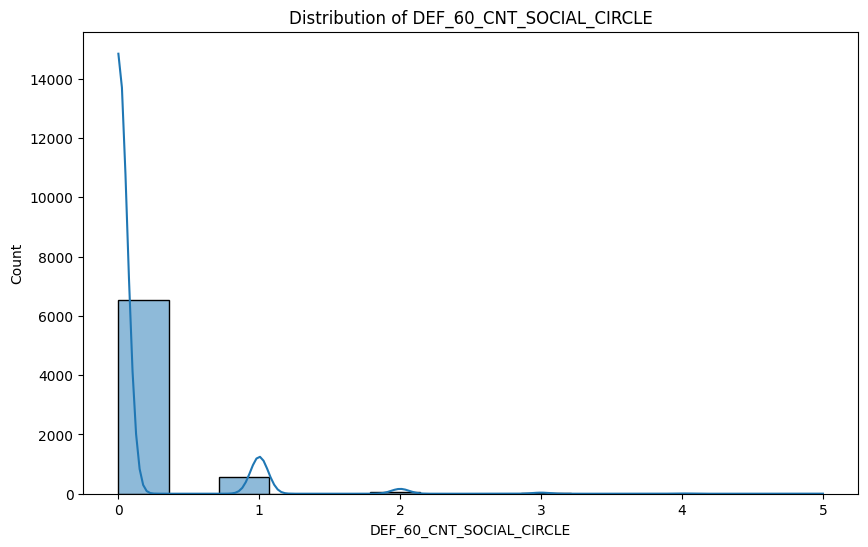

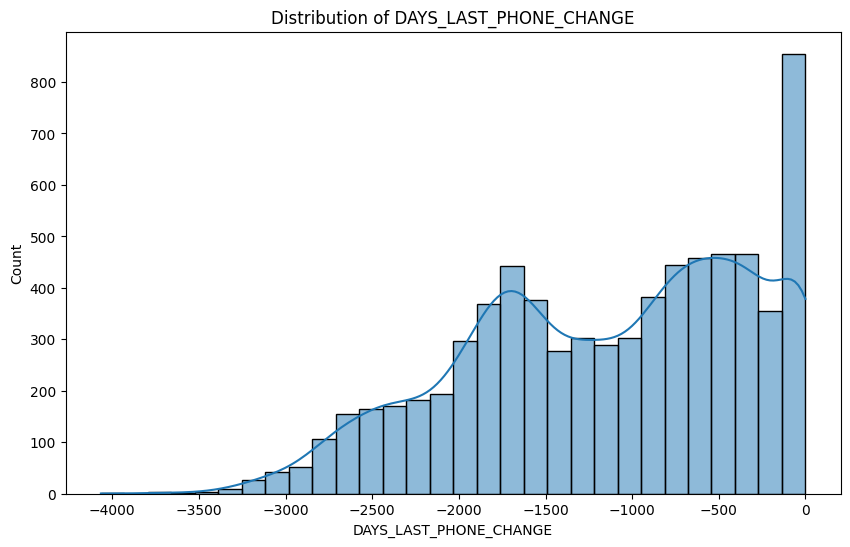

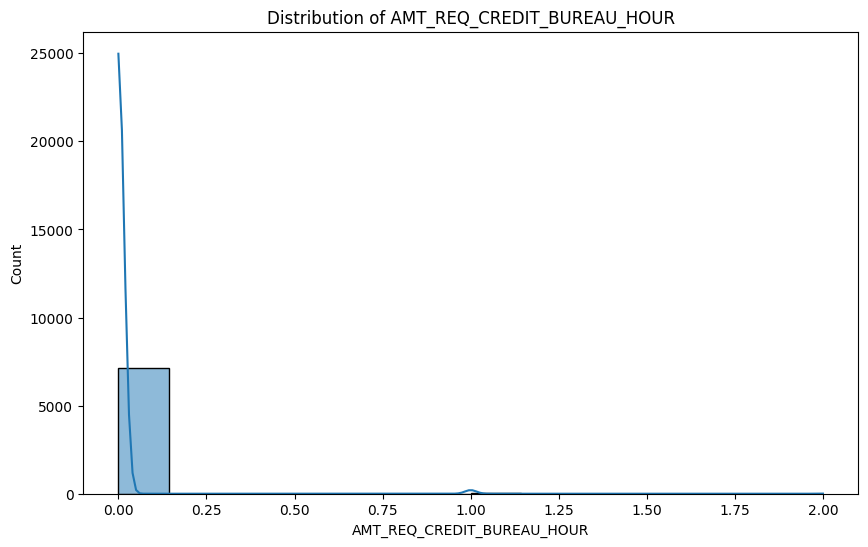

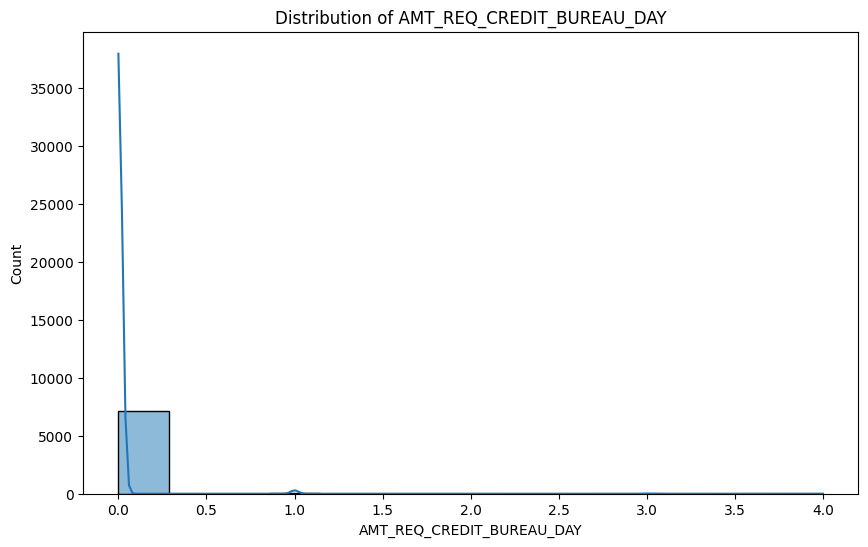

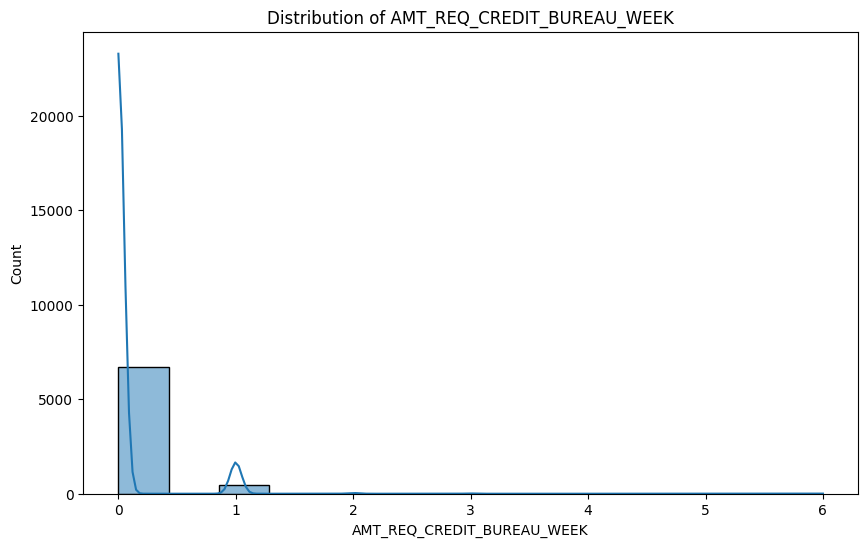

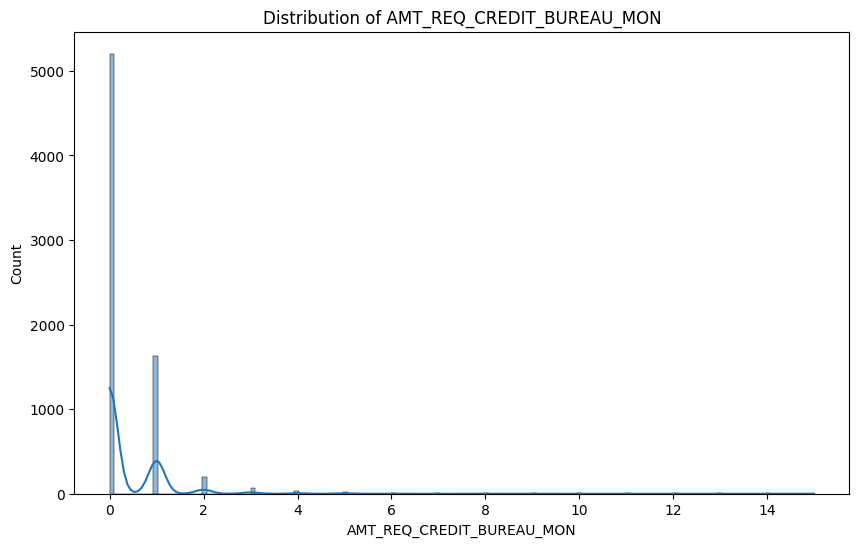

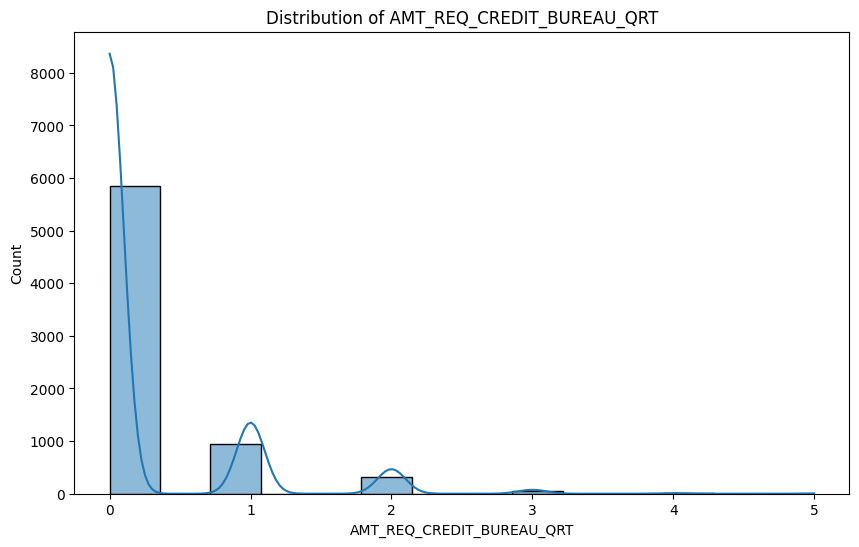

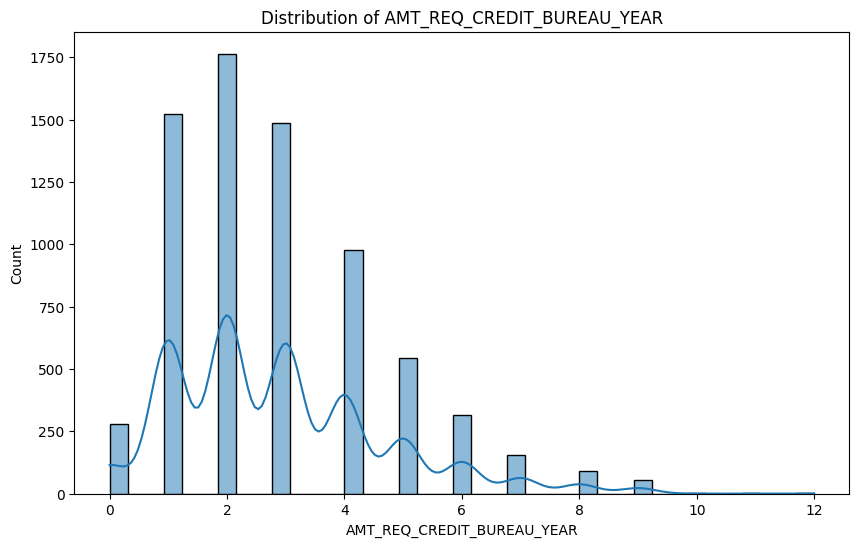

In [20]:
# Univariate Analysis - Numerical Features Distribution
for feature in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

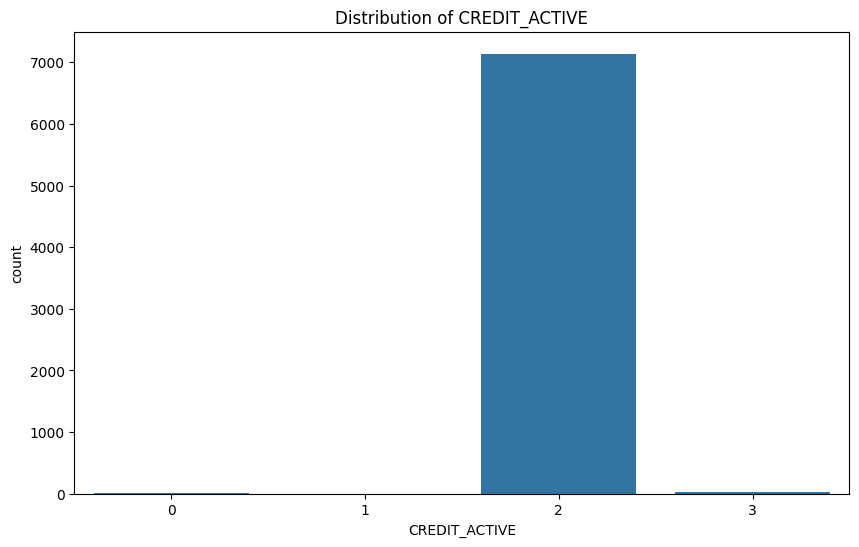

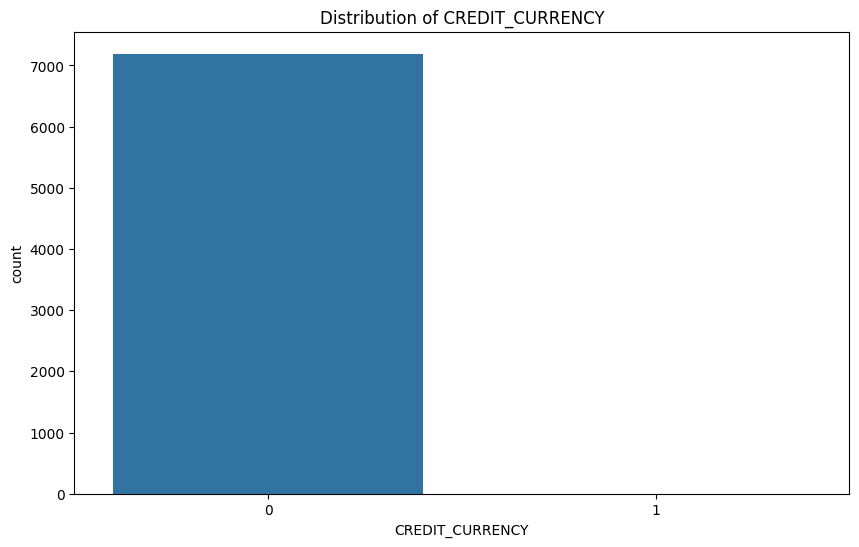

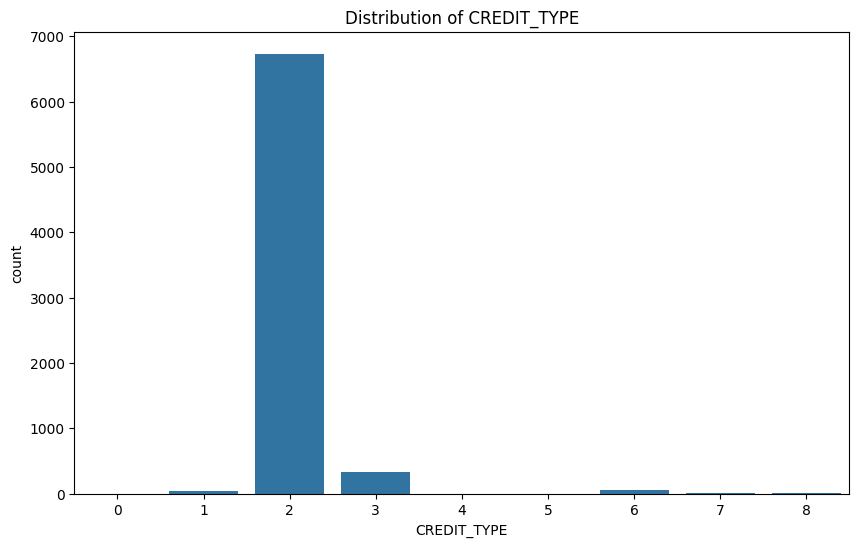

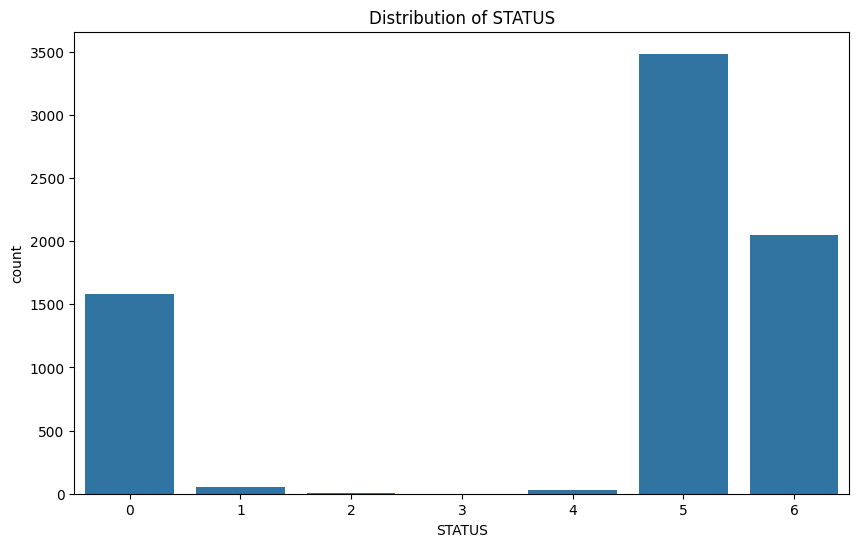

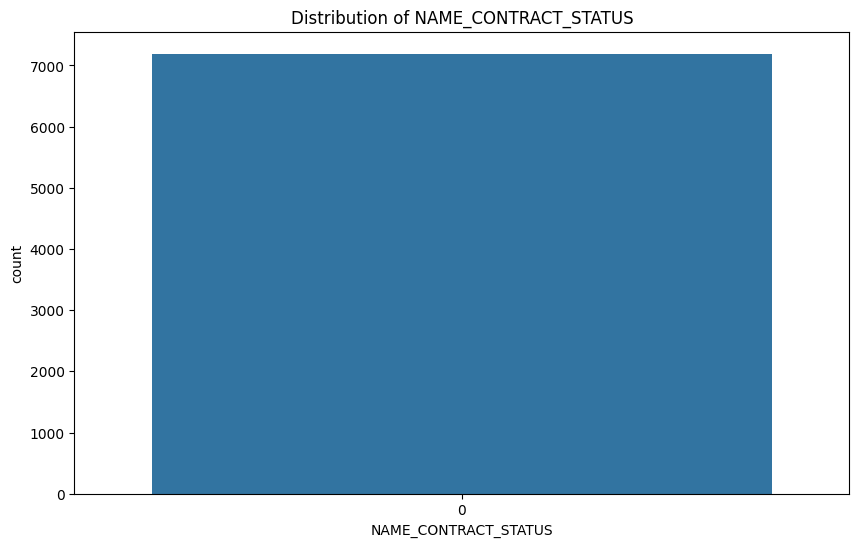

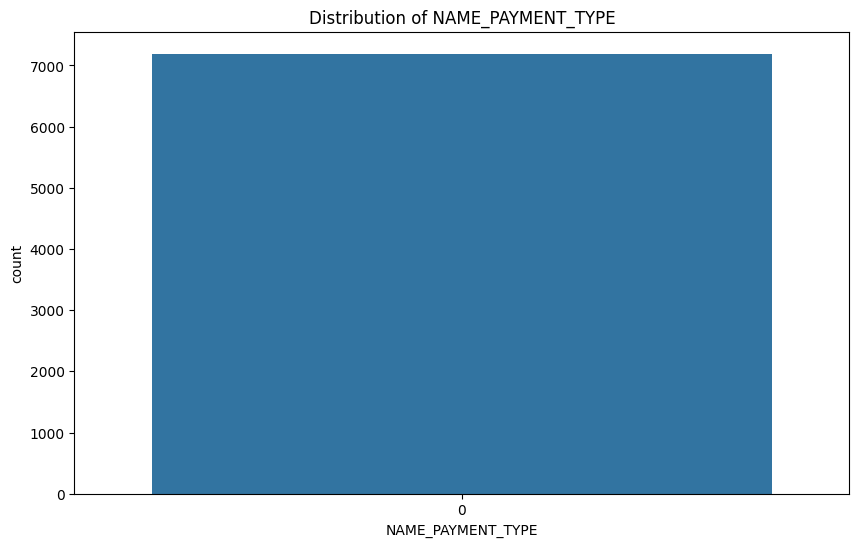

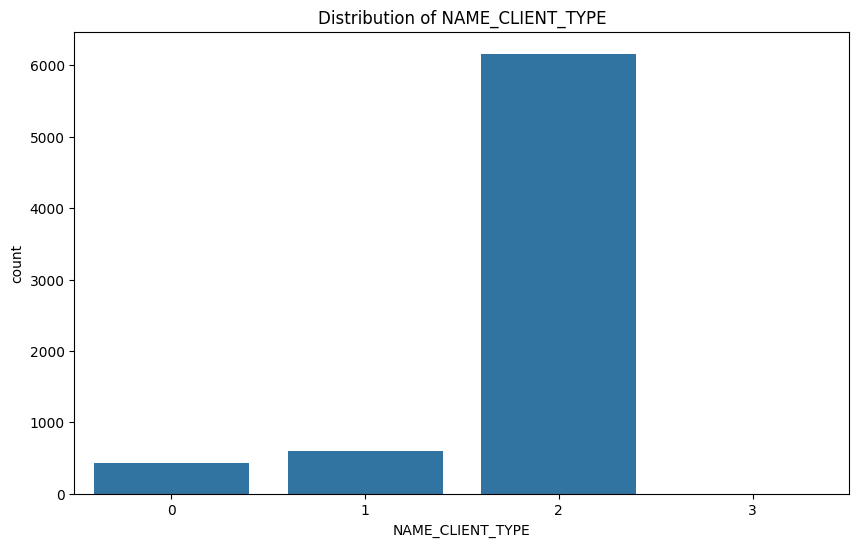

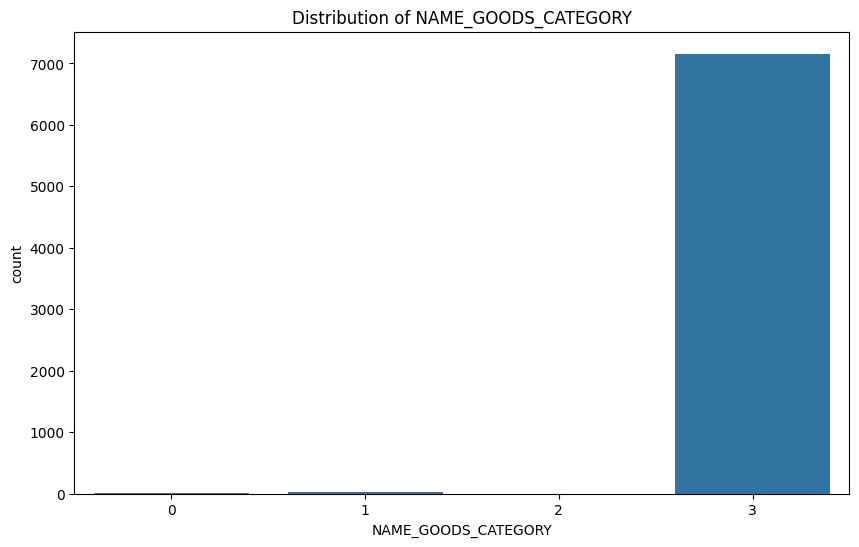

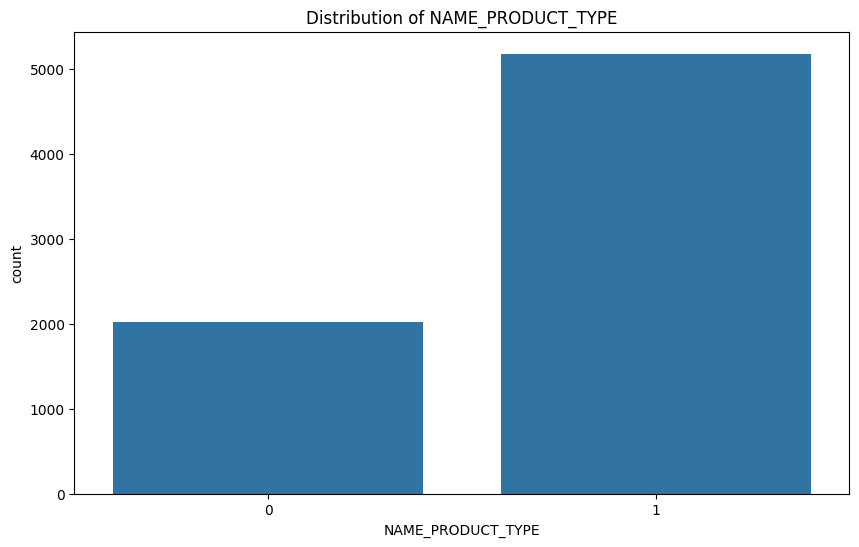

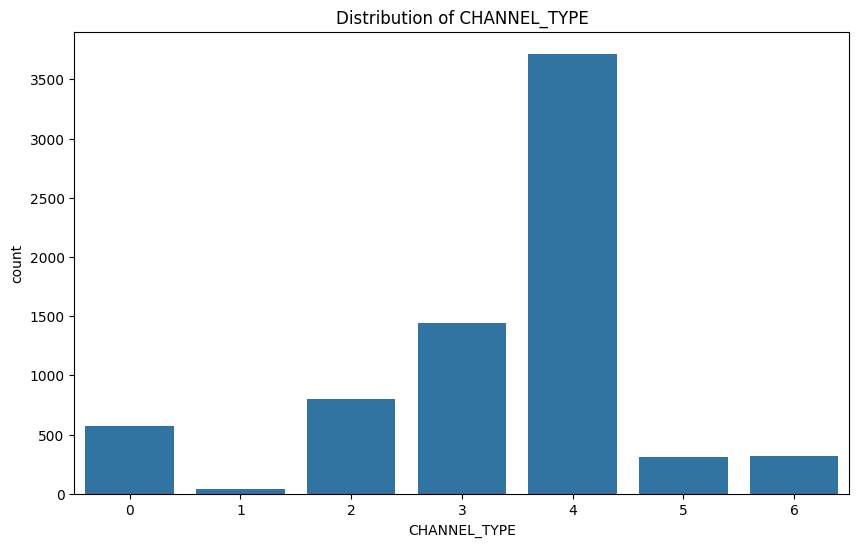

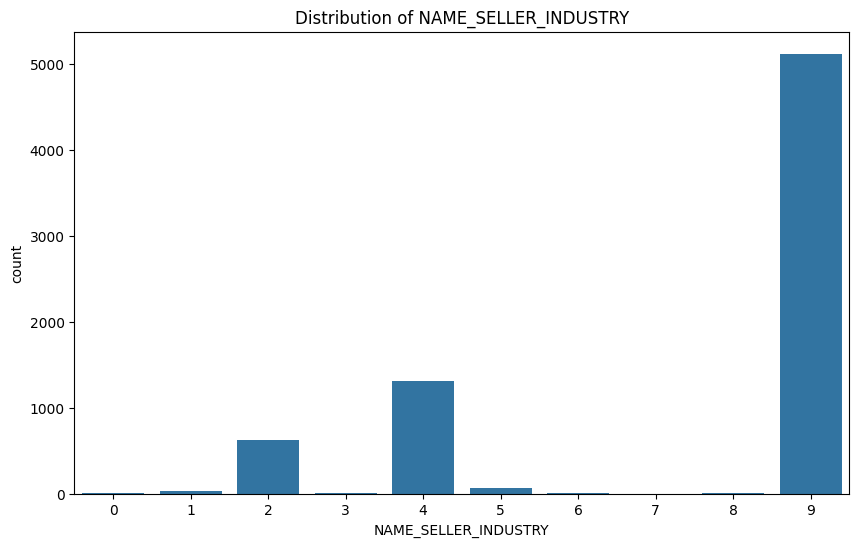

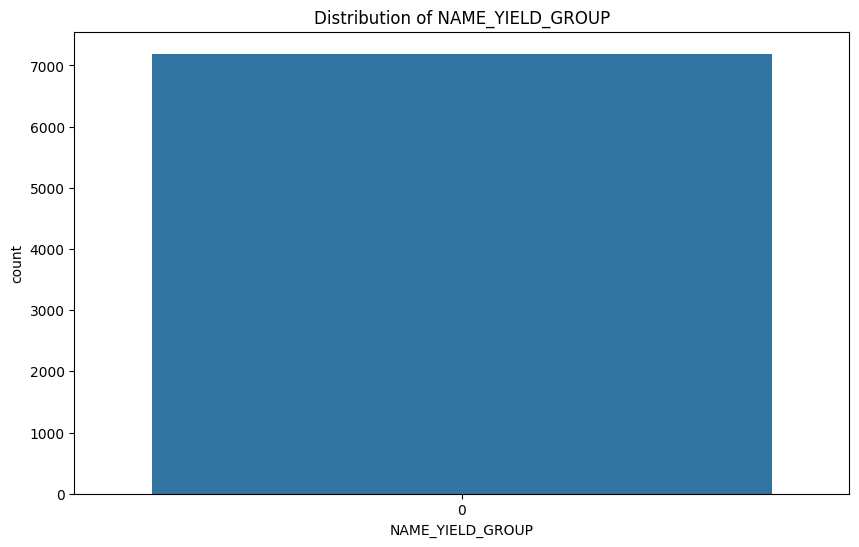

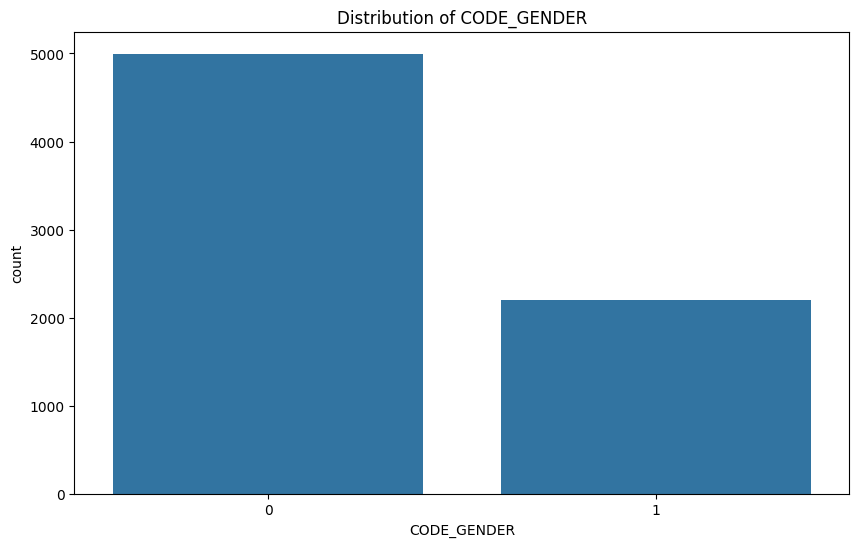

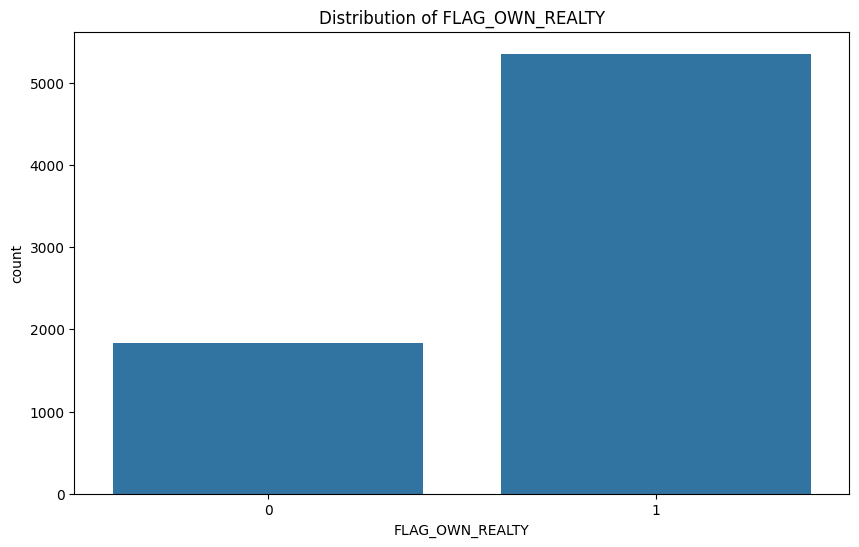

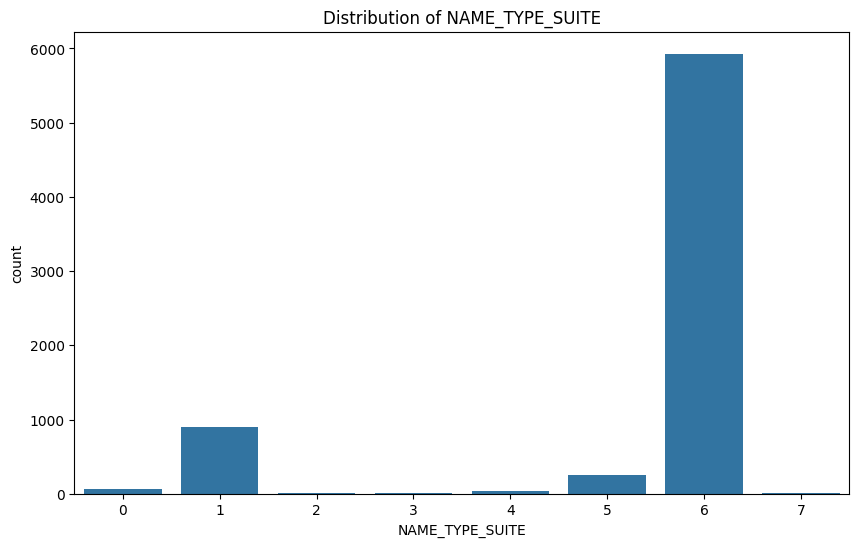

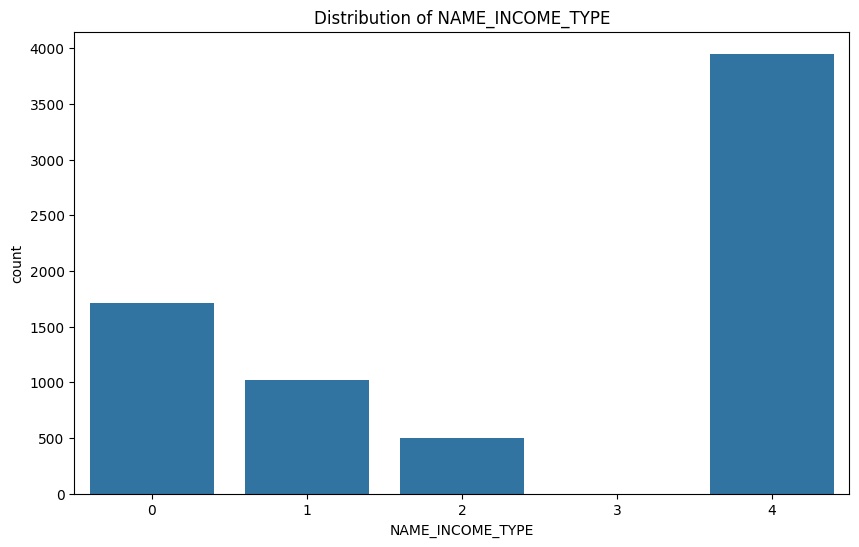

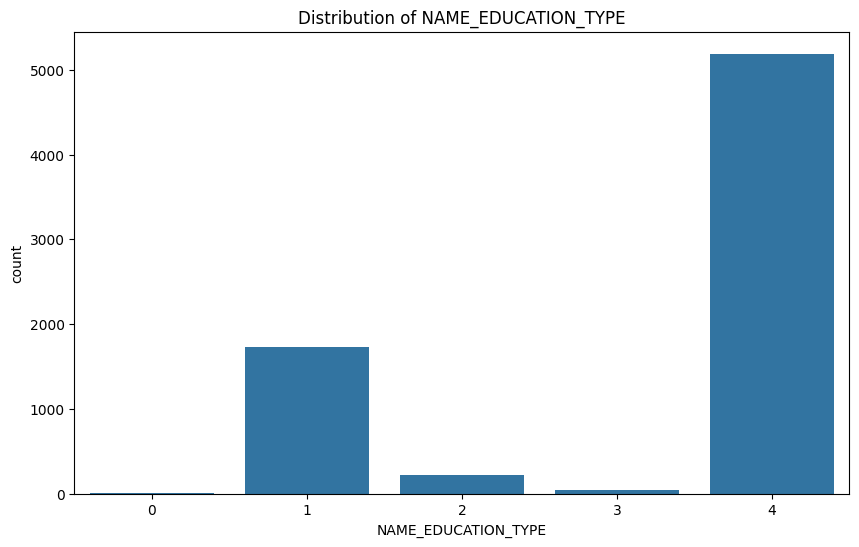

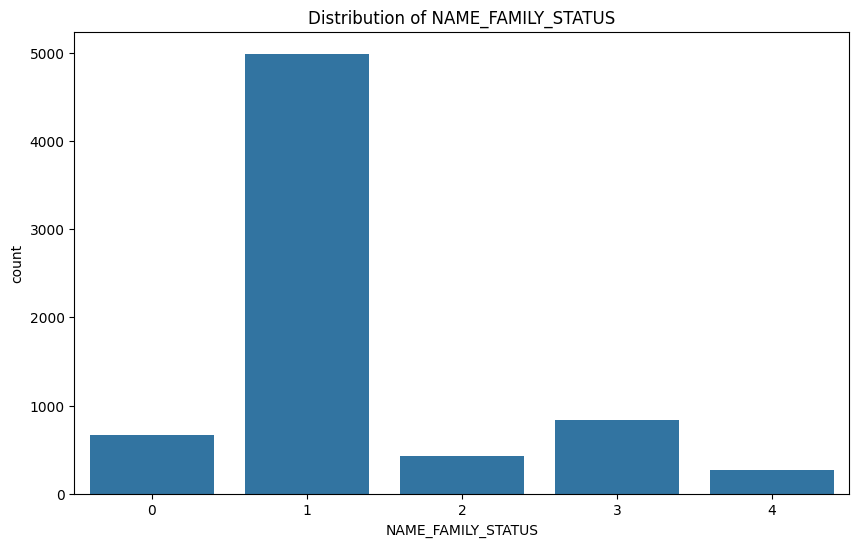

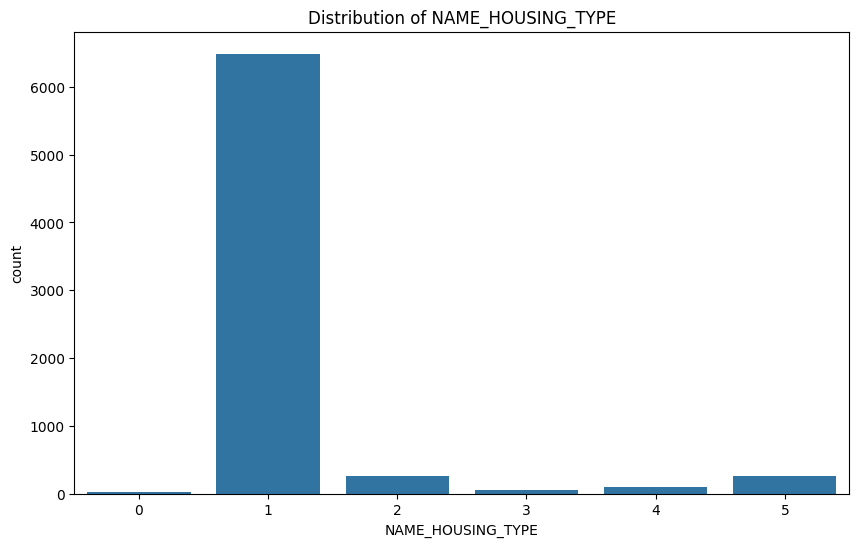

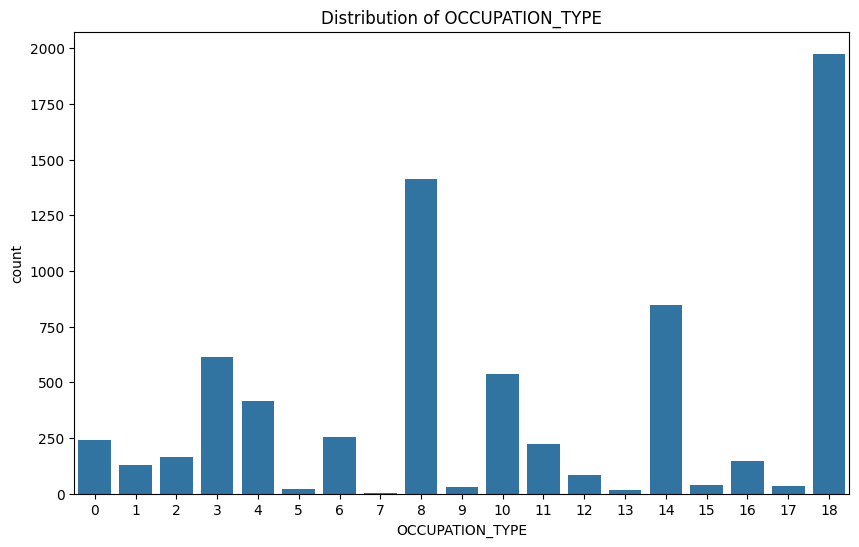

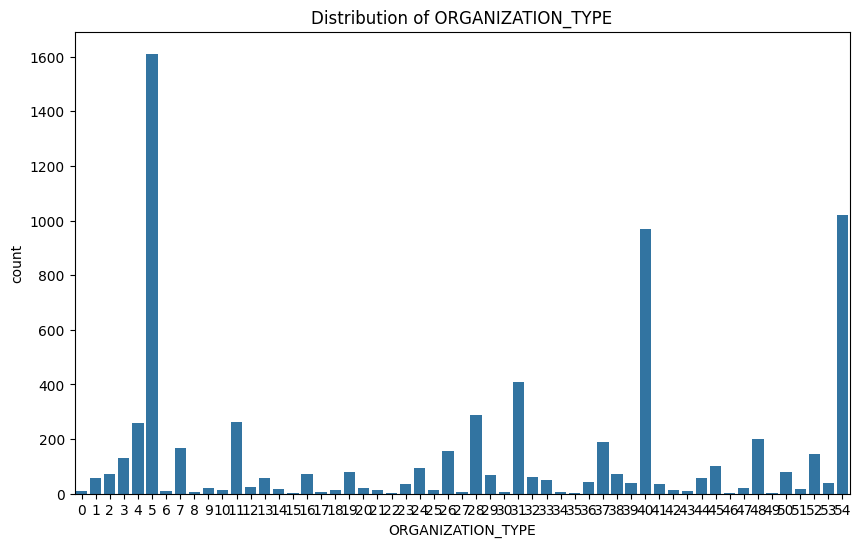

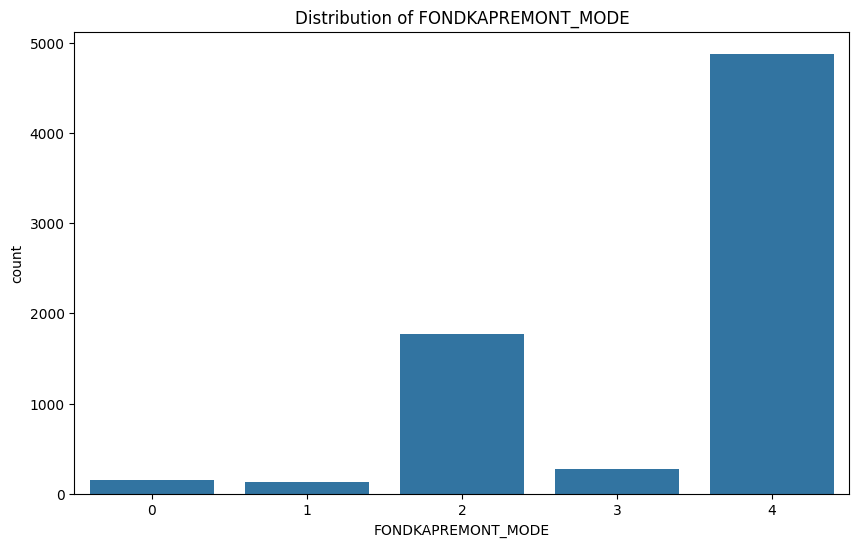

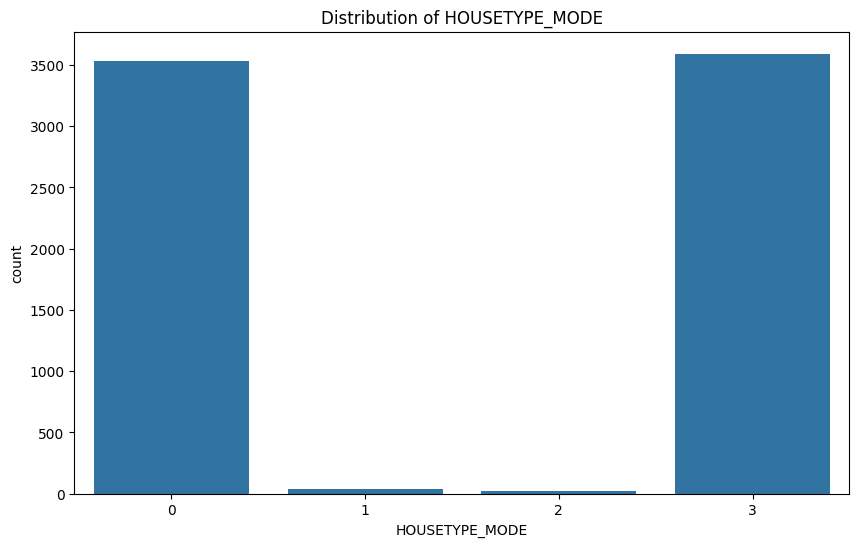

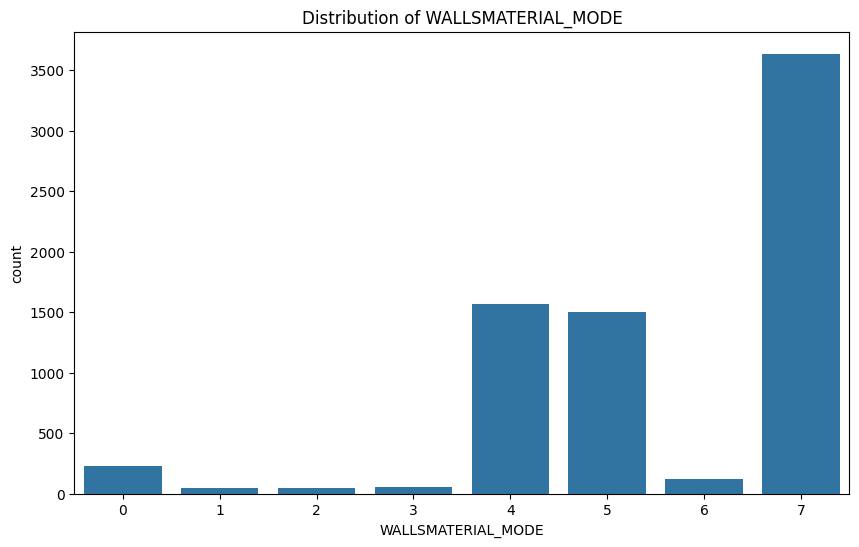

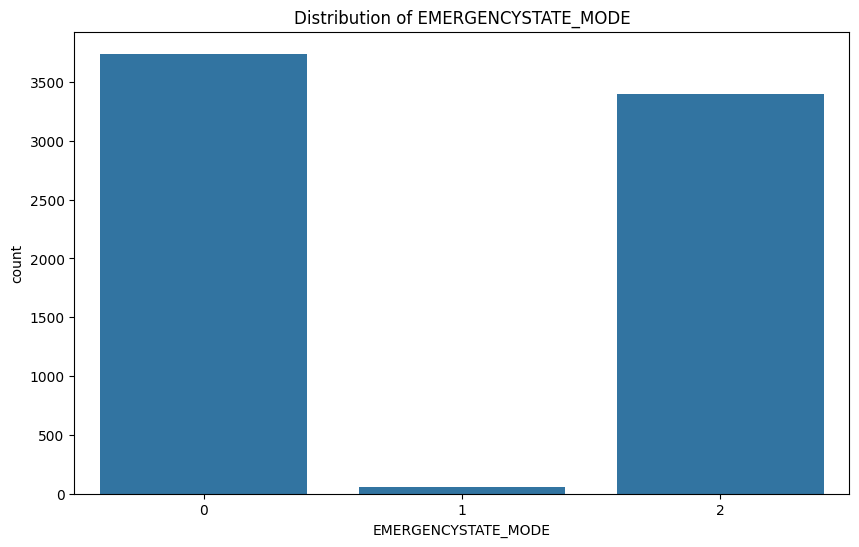

In [21]:
for feature in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=data[feature])
    plt.title(f'Distribution of {feature}')
    plt.show()

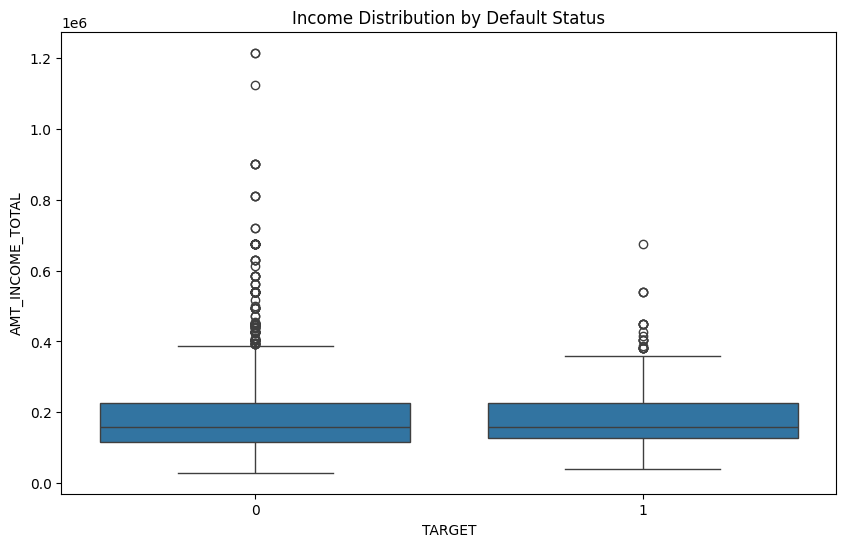

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=data)
plt.title('Income Distribution by Default Status')
plt.show()

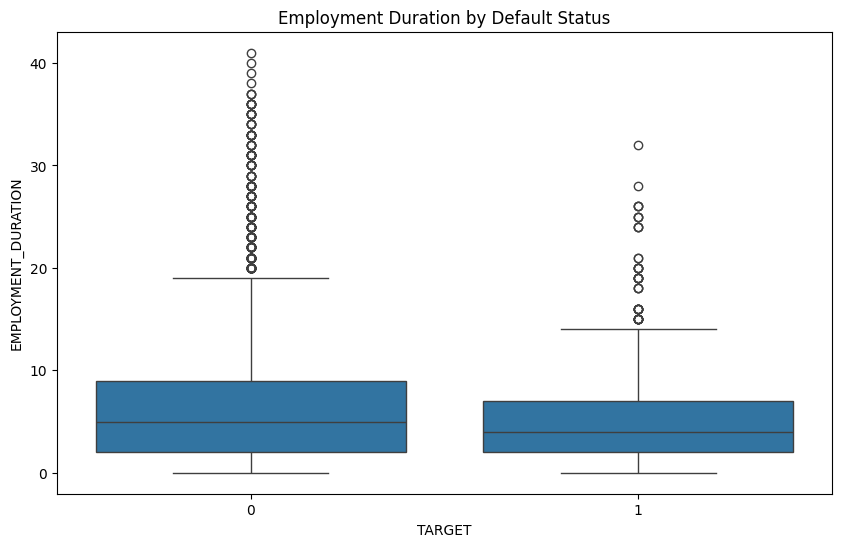

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='TARGET', y='EMPLOYMENT_DURATION', data=data)
plt.title('Employment Duration by Default Status')
plt.show()

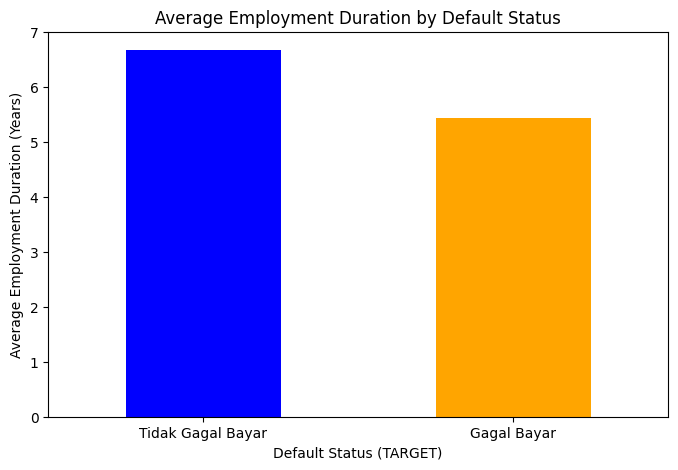

In [34]:
data['EMPLOYMENT_DURATION'] = data['EMPLOYMENT_DURATION'].replace(-1001, None)

data_clean = data.dropna(subset=['EMPLOYMENT_DURATION'])

avg_employment_duration = data_clean.groupby('TARGET')['EMPLOYMENT_DURATION'].mean()
avg_employment_duration.plot(kind='bar', color=['blue', 'orange'], figsize=(8, 5))
plt.title('Average Employment Duration by Default Status')
plt.xlabel('Default Status (TARGET)')
plt.ylabel('Average Employment Duration (Years)')
plt.xticks(ticks=[0, 1], labels=['Tidak Gagal Bayar', 'Gagal Bayar'], rotation=0)
plt.show()


Rata-rata penghasilan untuk 'Tidak Gagal Bayar': 182401.39653593773
Rata-rata penghasilan untuk 'Gagal Bayar': 179978.2394366197


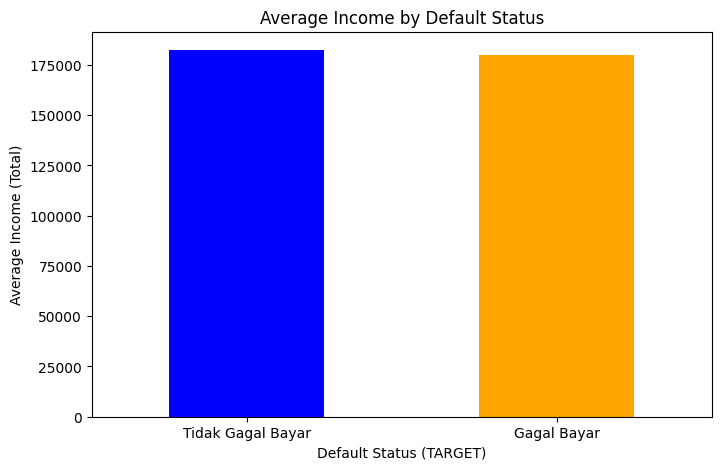

In [39]:
avg_income = data.groupby('TARGET')['AMT_INCOME_TOTAL'].mean()

print("Rata-rata penghasilan untuk 'Tidak Gagal Bayar':", avg_income[0])
print("Rata-rata penghasilan untuk 'Gagal Bayar':", avg_income[1])


avg_income.plot(kind='bar', color=['blue', 'orange'], figsize=(8, 5))
plt.title('Average Income by Default Status')
plt.xlabel('Default Status (TARGET)')
plt.ylabel('Average Income (Total)')
plt.xticks(ticks=[0, 1], labels=['Tidak Gagal Bayar', 'Gagal Bayar'], rotation=0)
plt.show()


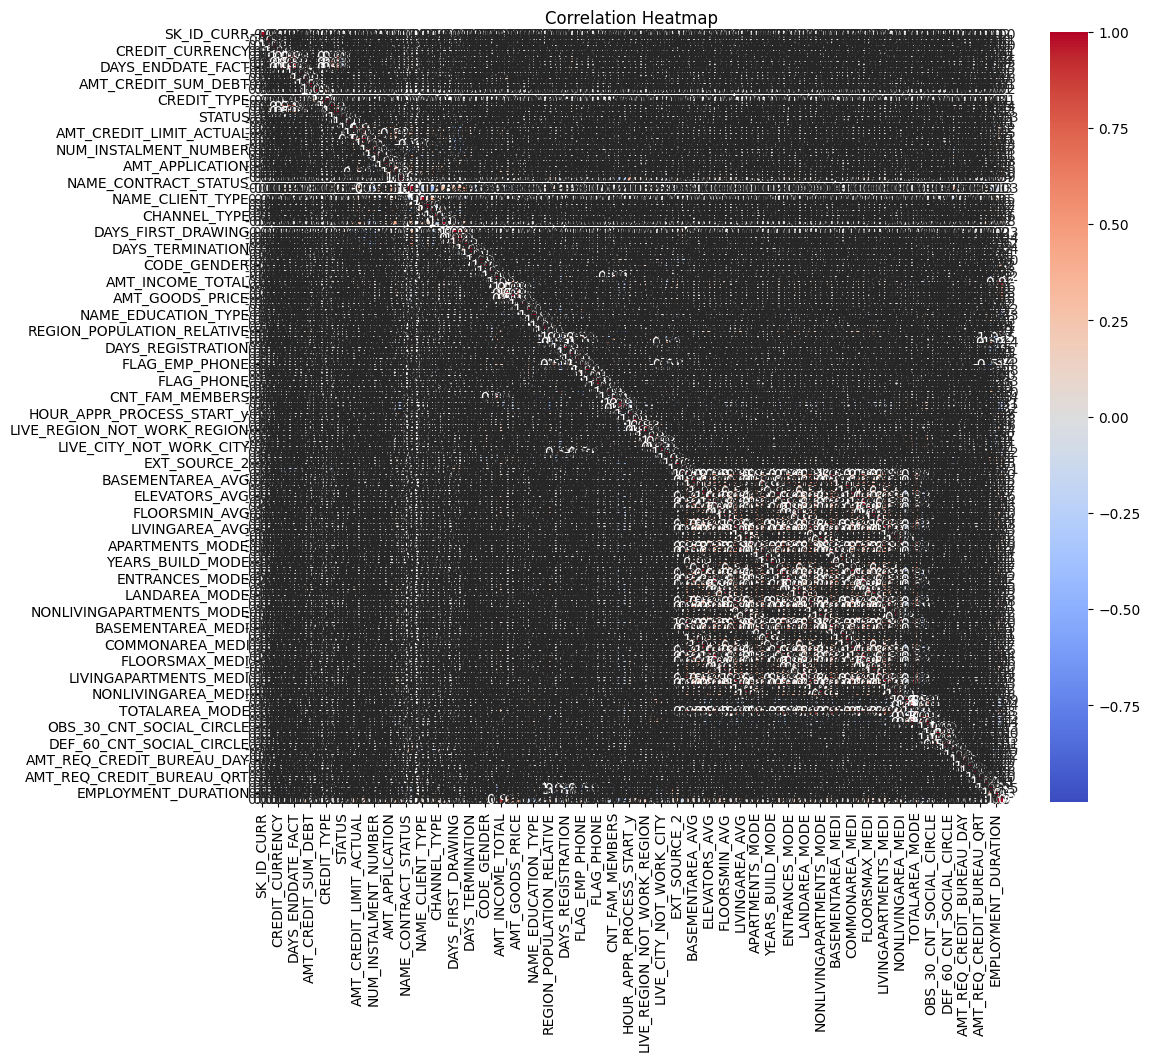

In [35]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Machine Learning Implementation and Evaluation

In [37]:
# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
y_pred_proba_log = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_log))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.69      1336
           1       0.68      0.71      0.69      1286

    accuracy                           0.69      2622
   macro avg       0.69      0.69      0.69      2622
weighted avg       0.69      0.69      0.69      2622

ROC-AUC Score: 0.7607811204961773


In [43]:
# Logistic Regression Training and Testing Score
train_score_log = log_reg_best.score(X_train, y_train)
test_score_log = log_reg_best.score(X_test, y_test)

print(f"Logistic Regression Training Score: {train_score_log:.2f}")
print(f"Logistic Regression Testing Score: {test_score_log:.2f}")

Logistic Regression Training Score: 0.69
Logistic Regression Testing Score: 0.69


In [38]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters for Logistic Regression:", grid_search.best_params_)

Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [27]:
# Retraining Logistic Regression with best parameters
log_reg_best = grid_search.best_estimator_
y_pred_log_best = log_reg_best.predict(X_test)
y_pred_proba_log_best = log_reg_best.predict_proba(X_test)[:, 1]

print("Logistic Regression After Hyperparameter Tuning:")
print(classification_report(y_test, y_pred_log_best))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_log_best))

Logistic Regression After Hyperparameter Tuning:
              precision    recall  f1-score   support

           0       0.71      0.67      0.69      1336
           1       0.68      0.71      0.69      1286

    accuracy                           0.69      2622
   macro avg       0.69      0.69      0.69      2622
weighted avg       0.69      0.69      0.69      2622

ROC-AUC Score: 0.7591770192119648


In [28]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_rf))

Random Forest Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1336
           1       0.95      0.91      0.93      1286

    accuracy                           0.93      2622
   macro avg       0.93      0.93      0.93      2622
weighted avg       0.93      0.93      0.93      2622

ROC-AUC Score: 0.9835012129706372


In [45]:
train_score_rf = rf.score(X_train, y_train)
test_score_rf = rf.score(X_test, y_test)

print(f"Random Forest Training Score: {train_score_rf:.2f}")
print(f"Random Forest Testing Score: {test_score_rf:.2f}")

Random Forest Training Score: 1.00
Random Forest Testing Score: 0.93


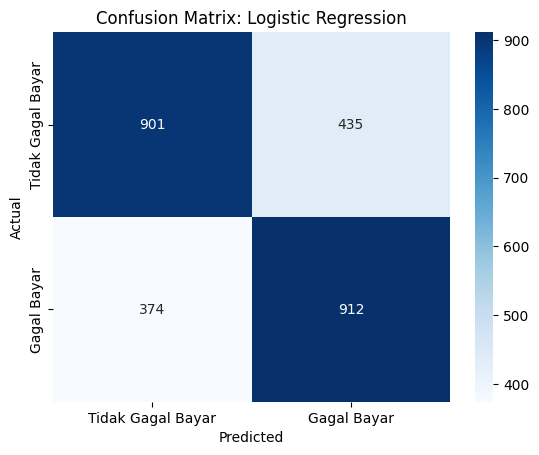

In [29]:
# Confusion Matrix for Logistic Regression
conf_matrix = confusion_matrix(y_test, y_pred_log_best)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Tidak Gagal Bayar', 'Gagal Bayar'],
            yticklabels=['Tidak Gagal Bayar', 'Gagal Bayar'])
plt.title('Confusion Matrix: Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

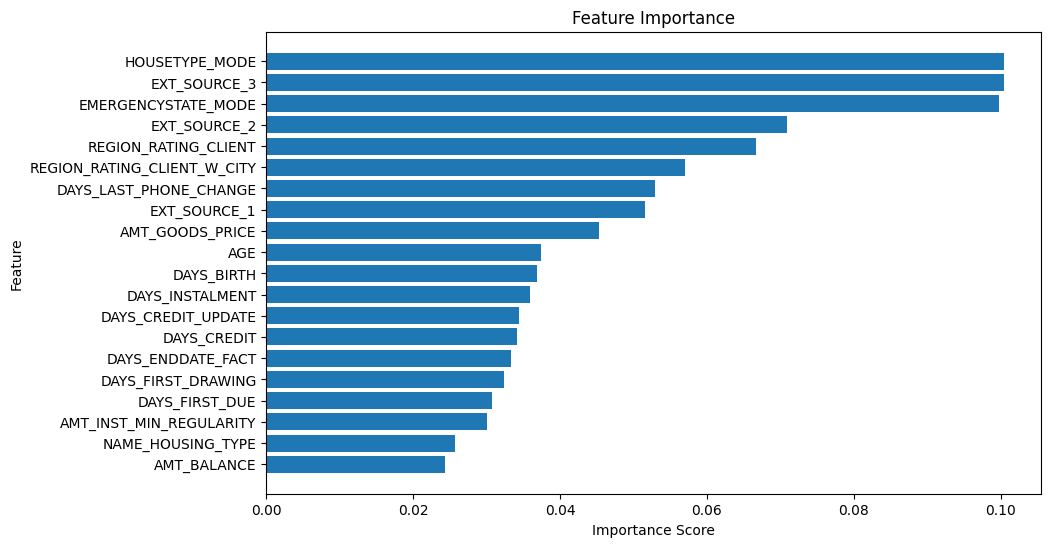

Top Relevant Features:
                        Feature  Importance
16               HOUSETYPE_MODE    0.100494
15                 EXT_SOURCE_3    0.100389
17          EMERGENCYSTATE_MODE    0.099700
14                 EXT_SOURCE_2    0.070877
11         REGION_RATING_CLIENT    0.066678
12  REGION_RATING_CLIENT_W_CITY    0.056997
18       DAYS_LAST_PHONE_CHANGE    0.052912
13                 EXT_SOURCE_1    0.051571
8               AMT_GOODS_PRICE    0.045353
19                          AGE    0.037372
10                   DAYS_BIRTH    0.036907
5               DAYS_INSTALMENT    0.035908
2            DAYS_CREDIT_UPDATE    0.034363
0                   DAYS_CREDIT    0.034143
1             DAYS_ENDDATE_FACT    0.033256
6            DAYS_FIRST_DRAWING    0.032325
7                DAYS_FIRST_DUE    0.030743
4       AMT_INST_MIN_REGULARITY    0.030004
9             NAME_HOUSING_TYPE    0.025653
3                   AMT_BALANCE    0.024356


In [30]:
# Visualize Feature Importance (Random Forest)
feature_importance = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

print("Top Relevant Features:")
print(importance_df)